- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

In [4]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

In [5]:
#First Model
def create_model():
    model = Sequential()
    model.add(Dense(
        32, 
        activation='swish', 
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)))
    #model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='swish'))
    model.add(Dropout(0.2))
    #model.add(Dense(128,activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    optimizer=RMSprop()
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',auc_roc])
    return model

In [6]:
# Wrap Keras model so it can be used by scikit-learn
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=32, verbose=1)
kears_estimator = KerasClassifier(build_fn=create_model,epochs=200, batch_size=128, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [7]:
# vif thresholds to apply to data and labels before grid search pipeline
#vif_thresholds = [0, 5]
vif_thresholds = [0]

# we want to actually select a certain percentage of features of whatever remains
# after vif thresholding.  So we will calculate these in the loop based on the number
# of features in data, and add to the parameters dictionary before the grid search
#features__k_ratios = np.array([0.25, 0.5, 0.75, 1.0])
features__k_ratios = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.5])

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None

# search over vif threshold meta parameters, create separate df from vif_threshold
# for otherwise identical grid searches
for vif_threshold in vif_thresholds:
    # display progress
    print('')
    print('=' * 50)
    print('Starting vif meta-parameter condition: vif_threshold: ', vif_threshold)
    
    # pipeline to apply vif threshold selection
    vif_pipeline = Pipeline(
      [
        ('vif',      VIFThresholdTransformer(score_threshold=vif_threshold)),
      ]
    )
 
    df_vif_features = vif_pipeline.transform(df_features)
    num_trials, num_features = df_vif_features.shape
    print('   Number of trials: ', num_trials, ' Number of Features: ', num_features)
    
    parameters = {
        'scaling__type_of_scaling': ['standard'],
        'outlier__outlier_threshold': [0.0, 3.0],
        'features__k': [12],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        'balance__balancer_type': ['allknn', 'smote-enn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        #'model__batch_size': [8, 16, 24, 32, 40, 48],#usually multiple of 8
        #'model__epochs':[100,150,200],
        #'model__batch_size': [60],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

    # set feature selection k correctly
    features__k = features__k_ratios * num_features
    features__k = features__k.astype(int) 
    parameters['features__k'] = features__k.tolist()

    # Estimator Pipeline
    pipeline = Pipeline(
      [
        ('progress', GridSearchProgressHack(verbose=False)),
        ('scaling',  FeatureScalerTransformer()),
        ('outlier',  WinsorizationOutlierTransformer()),
        ('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        ('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
    # Cross Validation Splitter
    cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
    search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        refit = 'roc_auc',
        verbose = 1
    )
    search.fit(df_vif_features, mind_wandered_label, groups=participant_ids)
    
    # append results onto the dataframe collecting the results.  Need to add
    # a feature column to this dataframe for the vif vit condition here
    df = pd.DataFrame(data=search.cv_results_)
    df['param__vif_score_threshold'] = vif_threshold
    
    if best_estimator is None:
        df_result = df
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_
    else:
        df_result = df_result.append(df, ignore_index=True)
        if search.best_score_ > best_score:
            best_estimator = search.best_estimator_
            best_score = search.best_score_
            best_params = search.best_params_
            best_index = search.best_index_  # todo this is only the index of this search


Starting vif meta-parameter condition: vif_threshold:  0
   Number of trials:  4076  Number of Features:  62
Fitting 5 folds for each of 24 candidates, totalling 120 fits
0001 Epoch 1/200
14/14 [==============================] - 3s 23ms/step - loss: 0.6998 - accuracy: 0.5703 - auc_roc: 0.5873
Epoch 2/200
14/14 [==============================] - 0s 24ms/step - loss: 0.6141 - accuracy: 0.6586 - auc_roc: 0.7206
Epoch 3/200
14/14 [==============================] - 0s 22ms/step - loss: 0.5982 - accuracy: 0.6900 - auc_roc: 0.7528
Epoch 4/200
14/14 [==============================] - 0s 23ms/step - loss: 0.5698 - accuracy: 0.7260 - auc_roc: 0.7782
Epoch 5/200
14/14 [==============================] - 0s 24ms/step - loss: 0.5690 - accuracy: 0.6976 - auc_roc: 0.7729
Epoch 6/200
14/14 [==============================] - 0s 24ms/step - loss: 0.5597 - accuracy: 0.7286 - auc_roc: 0.7936
Epoch 7/200
14/14 [==============================] - 0s 24ms/step - loss: 0.5655 - accuracy: 0.7135 - auc_roc: 0.77

14/14 [==============================] - 0s 25ms/step - loss: 0.5095 - accuracy: 0.7572 - auc_roc: 0.8268
Epoch 69/200
14/14 [==============================] - 0s 24ms/step - loss: 0.5142 - accuracy: 0.7500 - auc_roc: 0.8190
Epoch 70/200
14/14 [==============================] - 0s 24ms/step - loss: 0.4870 - accuracy: 0.7647 - auc_roc: 0.8412
Epoch 71/200
14/14 [==============================] - 0s 25ms/step - loss: 0.5067 - accuracy: 0.7510 - auc_roc: 0.8259
Epoch 72/200
14/14 [==============================] - 0s 24ms/step - loss: 0.4916 - accuracy: 0.7638 - auc_roc: 0.8363
Epoch 73/200
14/14 [==============================] - 0s 28ms/step - loss: 0.4931 - accuracy: 0.7591 - auc_roc: 0.8388
Epoch 74/200
14/14 [==============================] - 0s 26ms/step - loss: 0.5081 - accuracy: 0.7599 - auc_roc: 0.8262
Epoch 75/200
14/14 [==============================] - 0s 29ms/step - loss: 0.4979 - accuracy: 0.7510 - auc_roc: 0.8357
Epoch 76/200
14/14 [==============================] - 0s 27ms

14/14 [==============================] - 1s 40ms/step - loss: 0.4896 - accuracy: 0.7609 - auc_roc: 0.8411
Epoch 137/200
14/14 [==============================] - 1s 39ms/step - loss: 0.4864 - accuracy: 0.7586 - auc_roc: 0.8415
Epoch 138/200
14/14 [==============================] - 1s 40ms/step - loss: 0.4799 - accuracy: 0.7727 - auc_roc: 0.8474
Epoch 139/200
14/14 [==============================] - 1s 42ms/step - loss: 0.5065 - accuracy: 0.7554 - auc_roc: 0.8251
Epoch 140/200
14/14 [==============================] - 1s 40ms/step - loss: 0.4783 - accuracy: 0.7629 - auc_roc: 0.8447
Epoch 141/200
14/14 [==============================] - 0s 32ms/step - loss: 0.4906 - accuracy: 0.7693 - auc_roc: 0.8433
Epoch 142/200
14/14 [==============================] - 0s 31ms/step - loss: 0.4800 - accuracy: 0.7664 - auc_roc: 0.8494
Epoch 143/200
14/14 [==============================] - 0s 34ms/step - loss: 0.5000 - accuracy: 0.7675 - auc_roc: 0.8372
Epoch 144/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 2s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 17ms/step
0002 Epoch 1/200
15/15 [==============================] - 28s 64ms/step - loss: 0.7682 - accuracy: 0.5696 - auc_roc: 0.7644
Epoch 2/200
15/15 [==============================] - 1s 62ms/step - loss: 0.6455 - accuracy: 0.6616 - auc_roc: 0.6936
Epoch 3/200
15/15 [==============================] - 1s 63ms/step - loss: 0.5997 - accuracy: 0.7124 - auc_roc: 0.7479
Epoch 4/200
15/15 [==============================] - 1s 71ms/step - loss: 0.5966 - accuracy: 0.6855 - auc_roc: 0.7477
Epoch 5/200
15/15 [==============================] - 1s 57ms/step - loss: 0.5926 - accuracy: 0.7040 - auc_roc: 0.7572
Epoch 6/200
15/15 [==============================] - 1s 62ms/step - loss: 0.5637 - accuracy: 0.7190 - auc_roc: 0.7812
Epoch 7/200
15/15 [==============================] - 1s 66ms/step - loss: 0.5688 - accuracy: 0.7092 - auc_roc: 0.7722
Epoch 8/200
15/15 [==============================] - 1s 74ms/step - loss: 0.5625 - accuracy: 0.7089 - auc_roc: 0.781

15/15 [==============================] - 1s 68ms/step - loss: 0.5162 - accuracy: 0.7493 - auc_roc: 0.8244
Epoch 70/200
15/15 [==============================] - 1s 67ms/step - loss: 0.5197 - accuracy: 0.7333 - auc_roc: 0.8158
Epoch 71/200
15/15 [==============================] - 1s 63ms/step - loss: 0.5182 - accuracy: 0.7515 - auc_roc: 0.8207
Epoch 72/200
15/15 [==============================] - 1s 63ms/step - loss: 0.5266 - accuracy: 0.7338 - auc_roc: 0.8094
Epoch 73/200
15/15 [==============================] - 1s 66ms/step - loss: 0.5271 - accuracy: 0.7430 - auc_roc: 0.8175
Epoch 74/200
15/15 [==============================] - 1s 67ms/step - loss: 0.5199 - accuracy: 0.7528 - auc_roc: 0.8179
Epoch 75/200
15/15 [==============================] - 1s 69ms/step - loss: 0.5285 - accuracy: 0.7445 - auc_roc: 0.8063
Epoch 76/200
15/15 [==============================] - 1s 65ms/step - loss: 0.5252 - accuracy: 0.7417 - auc_roc: 0.8158
Epoch 77/200
15/15 [==============================] - 1s 61ms

15/15 [==============================] - 1s 54ms/step - loss: 0.5051 - accuracy: 0.7436 - auc_roc: 0.8262
Epoch 138/200
15/15 [==============================] - 1s 53ms/step - loss: 0.4900 - accuracy: 0.7716 - auc_roc: 0.8413
Epoch 139/200
15/15 [==============================] - 1s 61ms/step - loss: 0.4929 - accuracy: 0.7597 - auc_roc: 0.8350
Epoch 140/200
15/15 [==============================] - 1s 48ms/step - loss: 0.4937 - accuracy: 0.7708 - auc_roc: 0.8328
Epoch 141/200
15/15 [==============================] - 1s 58ms/step - loss: 0.4906 - accuracy: 0.7660 - auc_roc: 0.8407
Epoch 142/200
15/15 [==============================] - 1s 56ms/step - loss: 0.4955 - accuracy: 0.7506 - auc_roc: 0.8353
Epoch 143/200
15/15 [==============================] - 1s 62ms/step - loss: 0.4993 - accuracy: 0.7622 - auc_roc: 0.8293
Epoch 144/200
15/15 [==============================] - 1s 45ms/step - loss: 0.5060 - accuracy: 0.7629 - auc_roc: 0.8254
Epoch 145/200
15/15 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 2s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 17ms/step
0003 Epoch 1/200
14/14 [==============================] - 26s 71ms/step - loss: 0.7563 - accuracy: 0.4900 - auc_roc: 0.7624
Epoch 2/200
14/14 [==============================] - 1s 78ms/step - loss: 0.6406 - accuracy: 0.6391 - auc_roc: 0.6893
Epoch 3/200
14/14 [==============================] - 1s 75ms/step - loss: 0.6257 - accuracy: 0.6666 - auc_roc: 0.7240
Epoch 4/200
14/14 [==============================] - 1s 69ms/step - loss: 0.6037 - accuracy: 0.6946 - auc_roc: 0.7485
Epoch 5/200
14/14 [==============================] - 1s 73ms/step - loss: 0.5848 - accuracy: 0.7025 - auc_roc: 0.7642
Epoch 6/200
14/14 [==============================] - 1s 73ms/step - loss: 0.6043 - accuracy: 0.6966 - auc_roc: 0.7438
Epoch 7/200
14/14 [==============================] - 1s 70ms/step - loss: 0.5943 - accuracy: 0.7100 - auc_roc: 0.7570
Epoch 8/200
14/14 [==============================] - 1s 72ms/step - loss: 0.5798 - accuracy: 0.7121 - auc_roc: 0.770

14/14 [==============================] - 1s 60ms/step - loss: 0.5293 - accuracy: 0.7469 - auc_roc: 0.8162
Epoch 70/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5224 - accuracy: 0.7480 - auc_roc: 0.8176
Epoch 71/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5295 - accuracy: 0.7385 - auc_roc: 0.8144
Epoch 72/200
14/14 [==============================] - 1s 69ms/step - loss: 0.5329 - accuracy: 0.7409 - auc_roc: 0.8098
Epoch 73/200
14/14 [==============================] - 1s 69ms/step - loss: 0.5102 - accuracy: 0.7444 - auc_roc: 0.8267
Epoch 74/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5340 - accuracy: 0.7360 - auc_roc: 0.8085
Epoch 75/200
14/14 [==============================] - 1s 69ms/step - loss: 0.5388 - accuracy: 0.7350 - auc_roc: 0.8015
Epoch 76/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5075 - accuracy: 0.7596 - auc_roc: 0.8294
Epoch 77/200
14/14 [==============================] - 1s 64ms

14/14 [==============================] - 1s 72ms/step - loss: 0.4976 - accuracy: 0.7549 - auc_roc: 0.8330
Epoch 138/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5007 - accuracy: 0.7519 - auc_roc: 0.8319
Epoch 139/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5008 - accuracy: 0.7574 - auc_roc: 0.8280
Epoch 140/200
14/14 [==============================] - 1s 74ms/step - loss: 0.4971 - accuracy: 0.7544 - auc_roc: 0.8363
Epoch 141/200
14/14 [==============================] - 1s 73ms/step - loss: 0.5027 - accuracy: 0.7663 - auc_roc: 0.8321
Epoch 142/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5146 - accuracy: 0.7448 - auc_roc: 0.8179
Epoch 143/200
14/14 [==============================] - 1s 71ms/step - loss: 0.4978 - accuracy: 0.7551 - auc_roc: 0.8360
Epoch 144/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5041 - accuracy: 0.7546 - auc_roc: 0.8290
Epoch 145/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 5ms/step
0004 Epoch 1/200
14/14 [==============================] - 28s 57ms/step - loss: 0.6552 - accuracy: 0.6294 - auc_roc: 0.7925
Epoch 2/200
14/14 [==============================] - 1s 63ms/step - loss: 0.6001 - accuracy: 0.6981 - auc_roc: 0.7460
Epoch 3/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5925 - accuracy: 0.6939 - auc_roc: 0.7520
Epoch 4/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5742 - accuracy: 0.7226 - auc_roc: 0.7729
Epoch 5/200
14/14 [==============================] - 1s 73ms/step - loss: 0.5936 - accuracy: 0.7124 - auc_roc: 0.7650
Epoch 6/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5811 - accuracy: 0.6919 - auc_roc: 0.7615
Epoch 7/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5685 - accuracy: 0.7178 - auc_roc: 0.7730
Epoch 8/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5648 - accuracy: 0.7239 - auc_roc: 0.7880

14/14 [==============================] - 1s 49ms/step - loss: 0.5245 - accuracy: 0.7513 - auc_roc: 0.8154
Epoch 70/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5461 - accuracy: 0.7347 - auc_roc: 0.7953
Epoch 71/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5187 - accuracy: 0.7509 - auc_roc: 0.8248
Epoch 72/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5562 - accuracy: 0.7316 - auc_roc: 0.7952
Epoch 73/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5111 - accuracy: 0.7477 - auc_roc: 0.8235
Epoch 74/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5518 - accuracy: 0.7144 - auc_roc: 0.7853
Epoch 75/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5218 - accuracy: 0.7488 - auc_roc: 0.8179
Epoch 76/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5274 - accuracy: 0.7420 - auc_roc: 0.8139
Epoch 77/200
14/14 [==============================] - 1s 47ms

14/14 [==============================] - 1s 50ms/step - loss: 0.5278 - accuracy: 0.7472 - auc_roc: 0.8102
Epoch 138/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5076 - accuracy: 0.7542 - auc_roc: 0.8304
Epoch 139/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5233 - accuracy: 0.7445 - auc_roc: 0.8113
Epoch 140/200
14/14 [==============================] - 1s 52ms/step - loss: 0.5109 - accuracy: 0.7616 - auc_roc: 0.8236
Epoch 141/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5049 - accuracy: 0.7612 - auc_roc: 0.8284
Epoch 142/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5090 - accuracy: 0.7520 - auc_roc: 0.8307
Epoch 143/200
14/14 [==============================] - 1s 50ms/step - loss: 0.5159 - accuracy: 0.7594 - auc_roc: 0.8247
Epoch 144/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5002 - accuracy: 0.7719 - auc_roc: 0.8350
Epoch 145/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 26ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 7ms/step
0005 Epoch 1/200
14/14 [==============================] - 12s 46ms/step - loss: 0.8053 - accuracy: 0.4791 - auc_roc: 0.7489
Epoch 2/200
14/14 [==============================] - 1s 55ms/step - loss: 0.6413 - accuracy: 0.6563 - auc_roc: 0.7000
Epoch 3/200
14/14 [==============================] - 1s 50ms/step - loss: 0.5964 - accuracy: 0.6869 - auc_roc: 0.7507
Epoch 4/200
14/14 [==============================] - 1s 48ms/step - loss: 0.5703 - accuracy: 0.7212 - auc_roc: 0.7772
Epoch 5/200
14/14 [==============================] - 1s 49ms/step - loss: 0.5858 - accuracy: 0.7167 - auc_roc: 0.7758
Epoch 6/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5488 - accuracy: 0.7190 - auc_roc: 0.7952
Epoch 7/200
14/14 [==============================] - 1s 46ms/step - loss: 0.5785 - accuracy: 0.7112 - auc_roc: 0.7714
Epoch 8/200
14/14 [==============================] - 1s 49ms/step - loss: 0.5734 - accuracy: 0.7021 - auc_roc: 0.7762

14/14 [==============================] - 1s 77ms/step - loss: 0.4980 - accuracy: 0.7601 - auc_roc: 0.8332
Epoch 70/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5106 - accuracy: 0.7576 - auc_roc: 0.8257
Epoch 71/200
14/14 [==============================] - 1s 71ms/step - loss: 0.5075 - accuracy: 0.7493 - auc_roc: 0.8258
Epoch 72/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5119 - accuracy: 0.7450 - auc_roc: 0.8238
Epoch 73/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5038 - accuracy: 0.7473 - auc_roc: 0.8275
Epoch 74/200
14/14 [==============================] - 1s 64ms/step - loss: 0.4937 - accuracy: 0.7577 - auc_roc: 0.8363
Epoch 75/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5189 - accuracy: 0.7528 - auc_roc: 0.8161
Epoch 76/200
14/14 [==============================] - 1s 70ms/step - loss: 0.5108 - accuracy: 0.7433 - auc_roc: 0.8245
Epoch 77/200
14/14 [==============================] - 1s 63ms

14/14 [==============================] - 1s 71ms/step - loss: 0.5004 - accuracy: 0.7448 - auc_roc: 0.8284
Epoch 138/200
14/14 [==============================] - 1s 70ms/step - loss: 0.4894 - accuracy: 0.7593 - auc_roc: 0.8366
Epoch 139/200
14/14 [==============================] - 1s 64ms/step - loss: 0.4934 - accuracy: 0.7560 - auc_roc: 0.8372
Epoch 140/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4778 - accuracy: 0.7808 - auc_roc: 0.8485
Epoch 141/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4865 - accuracy: 0.7626 - auc_roc: 0.8428
Epoch 142/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4993 - accuracy: 0.7463 - auc_roc: 0.8310
Epoch 143/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4755 - accuracy: 0.7720 - auc_roc: 0.8479
Epoch 144/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5045 - accuracy: 0.7487 - auc_roc: 0.8310
Epoch 145/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 15ms/step
0006 Epoch 1/200
14/14 [==============================] - 21s 43ms/step - loss: 0.7493 - accuracy: 0.5310 - auc_roc: 0.7722
Epoch 2/200
14/14 [==============================] - 1s 47ms/step - loss: 0.6234 - accuracy: 0.6732 - auc_roc: 0.7266
Epoch 3/200
14/14 [==============================] - 1s 44ms/step - loss: 0.6013 - accuracy: 0.7001 - auc_roc: 0.7477
Epoch 4/200
14/14 [==============================] - 1s 44ms/step - loss: 0.5906 - accuracy: 0.6968 - auc_roc: 0.7613
Epoch 5/200
14/14 [==============================] - 1s 44ms/step - loss: 0.5845 - accuracy: 0.7057 - auc_roc: 0.7614
Epoch 6/200
14/14 [==============================] - 1s 52ms/step - loss: 0.5701 - accuracy: 0.7067 - auc_roc: 0.7740
Epoch 7/200
14/14 [==============================] - 1s 41ms/step - loss: 0.5765 - accuracy: 0.7154 - auc_roc: 0.7736
Epoch 8/200
14/14 [==============================] - 1s 38ms/step - loss: 0.5535 - accuracy: 0.7229 - auc_roc: 0.795

14/14 [==============================] - 1s 59ms/step - loss: 0.5045 - accuracy: 0.7517 - auc_roc: 0.8261
Epoch 70/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5180 - accuracy: 0.7458 - auc_roc: 0.8228
Epoch 71/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4974 - accuracy: 0.7670 - auc_roc: 0.8347
Epoch 72/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5011 - accuracy: 0.7650 - auc_roc: 0.8319
Epoch 73/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4760 - accuracy: 0.7743 - auc_roc: 0.8496
Epoch 74/200
14/14 [==============================] - 1s 51ms/step - loss: 0.5144 - accuracy: 0.7401 - auc_roc: 0.8203
Epoch 75/200
14/14 [==============================] - 1s 60ms/step - loss: 0.4893 - accuracy: 0.7610 - auc_roc: 0.8434
Epoch 76/200
14/14 [==============================] - 1s 64ms/step - loss: 0.4906 - accuracy: 0.7664 - auc_roc: 0.8371
Epoch 77/200
14/14 [==============================] - 1s 54ms

14/14 [==============================] - 1s 65ms/step - loss: 0.4775 - accuracy: 0.7628 - auc_roc: 0.8415
Epoch 138/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4880 - accuracy: 0.7541 - auc_roc: 0.8369
Epoch 139/200
14/14 [==============================] - 1s 77ms/step - loss: 0.4874 - accuracy: 0.7569 - auc_roc: 0.8399
Epoch 140/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4811 - accuracy: 0.7824 - auc_roc: 0.8425
Epoch 141/200
14/14 [==============================] - 1s 68ms/step - loss: 0.4861 - accuracy: 0.7596 - auc_roc: 0.8356
Epoch 142/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4608 - accuracy: 0.7750 - auc_roc: 0.8567
Epoch 143/200
14/14 [==============================] - 1s 69ms/step - loss: 0.4768 - accuracy: 0.7871 - auc_roc: 0.8506
Epoch 144/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4926 - accuracy: 0.7587 - auc_roc: 0.8398
Epoch 145/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 3ms/step
0007 Epoch 1/200
15/15 [==============================] - 21s 52ms/step - loss: 0.8296 - accuracy: 0.4860 - auc_roc: 0.7428
Epoch 2/200
15/15 [==============================] - 1s 58ms/step - loss: 0.6291 - accuracy: 0.6429 - auc_roc: 0.7029
Epoch 3/200
15/15 [==============================] - 1s 59ms/step - loss: 0.5886 - accuracy: 0.6895 - auc_roc: 0.7607
Epoch 4/200
15/15 [==============================] - 1s 49ms/step - loss: 0.5778 - accuracy: 0.7055 - auc_roc: 0.7666
Epoch 5/200
15/15 [==============================] - 1s 56ms/step - loss: 0.5745 - accuracy: 0.7020 - auc_roc: 0.7640
Epoch 6/200
15/15 [==============================] - 1s 52ms/step - loss: 0.5579 - accuracy: 0.7240 - auc_roc: 0.7803
Epoch 7/200
15/15 [==============================] - 1s 58ms/step - loss: 0.5717 - accuracy: 0.7119 - auc_roc: 0.7736
Epoch 8/200
15/15 [==============================] - 1s 67ms/step - loss: 0.5564 - accuracy: 0.7166 - auc_roc: 0.7804

15/15 [==============================] - 1s 64ms/step - loss: 0.4953 - accuracy: 0.7524 - auc_roc: 0.8357
Epoch 70/200
15/15 [==============================] - 1s 61ms/step - loss: 0.5019 - accuracy: 0.7588 - auc_roc: 0.8286
Epoch 71/200
15/15 [==============================] - 1s 61ms/step - loss: 0.5082 - accuracy: 0.7556 - auc_roc: 0.8238
Epoch 72/200
15/15 [==============================] - 1s 69ms/step - loss: 0.4943 - accuracy: 0.7613 - auc_roc: 0.8351
Epoch 73/200
15/15 [==============================] - 1s 62ms/step - loss: 0.5151 - accuracy: 0.7361 - auc_roc: 0.8133
Epoch 74/200
15/15 [==============================] - 1s 70ms/step - loss: 0.5214 - accuracy: 0.7508 - auc_roc: 0.8135
Epoch 75/200
15/15 [==============================] - 1s 59ms/step - loss: 0.5023 - accuracy: 0.7473 - auc_roc: 0.8285
Epoch 76/200
15/15 [==============================] - 1s 61ms/step - loss: 0.5072 - accuracy: 0.7525 - auc_roc: 0.8198
Epoch 77/200
15/15 [==============================] - 1s 59ms

15/15 [==============================] - 1s 47ms/step - loss: 0.4788 - accuracy: 0.7715 - auc_roc: 0.8465
Epoch 138/200
15/15 [==============================] - 1s 45ms/step - loss: 0.4995 - accuracy: 0.7537 - auc_roc: 0.8287
Epoch 139/200
15/15 [==============================] - 1s 49ms/step - loss: 0.5117 - accuracy: 0.7487 - auc_roc: 0.8207
Epoch 140/200
15/15 [==============================] - 1s 49ms/step - loss: 0.4937 - accuracy: 0.7569 - auc_roc: 0.8368
Epoch 141/200
15/15 [==============================] - 1s 40ms/step - loss: 0.4924 - accuracy: 0.7595 - auc_roc: 0.8269
Epoch 142/200
15/15 [==============================] - 1s 59ms/step - loss: 0.4820 - accuracy: 0.7689 - auc_roc: 0.8395
Epoch 143/200
15/15 [==============================] - 1s 48ms/step - loss: 0.4976 - accuracy: 0.7631 - auc_roc: 0.8304
Epoch 144/200
15/15 [==============================] - 1s 52ms/step - loss: 0.4974 - accuracy: 0.7518 - auc_roc: 0.8322
Epoch 145/200
15/15 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 16ms/step
0008 Epoch 1/200
14/14 [==============================] - 24s 44ms/step - loss: 0.7335 - accuracy: 0.5559 - auc_roc: 0.7840
Epoch 2/200
14/14 [==============================] - 1s 61ms/step - loss: 0.6271 - accuracy: 0.6735 - auc_roc: 0.7253
Epoch 3/200
14/14 [==============================] - 1s 52ms/step - loss: 0.6025 - accuracy: 0.7029 - auc_roc: 0.7551
Epoch 4/200
14/14 [==============================] - 1s 53ms/step - loss: 0.6064 - accuracy: 0.6869 - auc_roc: 0.7437
Epoch 5/200
14/14 [==============================] - 1s 49ms/step - loss: 0.5982 - accuracy: 0.6952 - auc_roc: 0.7506
Epoch 6/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5734 - accuracy: 0.7342 - auc_roc: 0.7824
Epoch 7/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5603 - accuracy: 0.7257 - auc_roc: 0.7888
Epoch 8/200
14/14 [==============================] - 1s 50ms/step - loss: 0.5772 - accuracy: 0.7054 - auc_roc: 0.770

14/14 [==============================] - 1s 52ms/step - loss: 0.5104 - accuracy: 0.7562 - auc_roc: 0.8233
Epoch 70/200
14/14 [==============================] - 1s 47ms/step - loss: 0.5289 - accuracy: 0.7443 - auc_roc: 0.8105
Epoch 71/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5058 - accuracy: 0.7638 - auc_roc: 0.8282
Epoch 72/200
14/14 [==============================] - 1s 50ms/step - loss: 0.5218 - accuracy: 0.7596 - auc_roc: 0.8202
Epoch 73/200
14/14 [==============================] - 1s 47ms/step - loss: 0.5009 - accuracy: 0.7574 - auc_roc: 0.8379
Epoch 74/200
14/14 [==============================] - 1s 47ms/step - loss: 0.5013 - accuracy: 0.7563 - auc_roc: 0.8298
Epoch 75/200
14/14 [==============================] - 1s 44ms/step - loss: 0.5076 - accuracy: 0.7533 - auc_roc: 0.8277
Epoch 76/200
14/14 [==============================] - 1s 50ms/step - loss: 0.5375 - accuracy: 0.7469 - auc_roc: 0.8120
Epoch 77/200
14/14 [==============================] - 1s 48ms

14/14 [==============================] - 1s 59ms/step - loss: 0.5182 - accuracy: 0.7549 - auc_roc: 0.8181
Epoch 138/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5002 - accuracy: 0.7486 - auc_roc: 0.8297
Epoch 139/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5093 - accuracy: 0.7493 - auc_roc: 0.8269
Epoch 140/200
14/14 [==============================] - 1s 60ms/step - loss: 0.4798 - accuracy: 0.7769 - auc_roc: 0.8497
Epoch 141/200
14/14 [==============================] - 1s 67ms/step - loss: 0.5031 - accuracy: 0.7550 - auc_roc: 0.8309
Epoch 142/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5067 - accuracy: 0.7562 - auc_roc: 0.8262
Epoch 143/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4845 - accuracy: 0.7772 - auc_roc: 0.8466
Epoch 144/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4994 - accuracy: 0.7588 - auc_roc: 0.8291
Epoch 145/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 2s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 12ms/step
0009 Epoch 1/200
14/14 [==============================] - 24s 54ms/step - loss: 0.8101 - accuracy: 0.4552 - auc_roc: 0.7453
Epoch 2/200
14/14 [==============================] - 1s 53ms/step - loss: 0.6140 - accuracy: 0.6602 - auc_roc: 0.7193
Epoch 3/200
14/14 [==============================] - 1s 44ms/step - loss: 0.5839 - accuracy: 0.7081 - auc_roc: 0.7590
Epoch 4/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5867 - accuracy: 0.7079 - auc_roc: 0.7598
Epoch 5/200
14/14 [==============================] - 1s 43ms/step - loss: 0.5736 - accuracy: 0.7135 - auc_roc: 0.7697
Epoch 6/200
14/14 [==============================] - 1s 52ms/step - loss: 0.5699 - accuracy: 0.7141 - auc_roc: 0.7752
Epoch 7/200
14/14 [==============================] - 1s 50ms/step - loss: 0.5593 - accuracy: 0.7325 - auc_roc: 0.7868
Epoch 8/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5532 - accuracy: 0.7274 - auc_roc: 0.787

14/14 [==============================] - 1s 49ms/step - loss: 0.5059 - accuracy: 0.7597 - auc_roc: 0.8261
Epoch 69/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5104 - accuracy: 0.7494 - auc_roc: 0.8264
Epoch 70/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5367 - accuracy: 0.7381 - auc_roc: 0.8039
Epoch 71/200
14/14 [==============================] - 1s 52ms/step - loss: 0.5392 - accuracy: 0.7391 - auc_roc: 0.8023
Epoch 72/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5394 - accuracy: 0.7403 - auc_roc: 0.7994
Epoch 73/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5227 - accuracy: 0.7490 - auc_roc: 0.8154
Epoch 74/200
14/14 [==============================] - 1s 52ms/step - loss: 0.5311 - accuracy: 0.7364 - auc_roc: 0.8087
Epoch 75/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5033 - accuracy: 0.7574 - auc_roc: 0.8306
Epoch 76/200
14/14 [==============================] - 1s 50ms

14/14 [==============================] - 1s 69ms/step - loss: 0.4959 - accuracy: 0.7570 - auc_roc: 0.8390
Epoch 137/200
14/14 [==============================] - 1s 73ms/step - loss: 0.5321 - accuracy: 0.7330 - auc_roc: 0.8034
Epoch 138/200
14/14 [==============================] - 1s 70ms/step - loss: 0.4915 - accuracy: 0.7599 - auc_roc: 0.8388
Epoch 139/200
14/14 [==============================] - 1s 71ms/step - loss: 0.4883 - accuracy: 0.7702 - auc_roc: 0.8425
Epoch 140/200
14/14 [==============================] - 1s 77ms/step - loss: 0.5017 - accuracy: 0.7623 - auc_roc: 0.8312
Epoch 141/200
14/14 [==============================] - 1s 73ms/step - loss: 0.5088 - accuracy: 0.7624 - auc_roc: 0.8283
Epoch 142/200
14/14 [==============================] - 1s 71ms/step - loss: 0.5008 - accuracy: 0.7652 - auc_roc: 0.8318
Epoch 143/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4949 - accuracy: 0.7606 - auc_roc: 0.8374
Epoch 144/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 2ms/step
0010 Epoch 1/200
14/14 [==============================] - 23s 59ms/step - loss: 0.6796 - accuracy: 0.5987 - auc_roc: 0.7876
Epoch 2/200
14/14 [==============================] - 1s 76ms/step - loss: 0.5968 - accuracy: 0.6964 - auc_roc: 0.7499
Epoch 3/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5855 - accuracy: 0.7037 - auc_roc: 0.7644
Epoch 4/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5676 - accuracy: 0.7131 - auc_roc: 0.7787
Epoch 5/200
14/14 [==============================] - 1s 70ms/step - loss: 0.5875 - accuracy: 0.7089 - auc_roc: 0.7656
Epoch 6/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5683 - accuracy: 0.7252 - auc_roc: 0.7827
Epoch 7/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5769 - accuracy: 0.7133 - auc_roc: 0.7733
Epoch 8/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5530 - accuracy: 0.7237 - auc_roc: 0.7943

14/14 [==============================] - 1s 58ms/step - loss: 0.5053 - accuracy: 0.7559 - auc_roc: 0.8275
Epoch 70/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4985 - accuracy: 0.7552 - auc_roc: 0.8341
Epoch 71/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4933 - accuracy: 0.7546 - auc_roc: 0.8363
Epoch 72/200
14/14 [==============================] - 1s 47ms/step - loss: 0.5171 - accuracy: 0.7591 - auc_roc: 0.8188
Epoch 73/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5131 - accuracy: 0.7517 - auc_roc: 0.8207
Epoch 74/200
14/14 [==============================] - 1s 48ms/step - loss: 0.5214 - accuracy: 0.7518 - auc_roc: 0.8145
Epoch 75/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4857 - accuracy: 0.7718 - auc_roc: 0.8440
Epoch 76/200
14/14 [==============================] - 1s 51ms/step - loss: 0.5062 - accuracy: 0.7416 - auc_roc: 0.8291
Epoch 77/200
14/14 [==============================] - 1s 47ms

14/14 [==============================] - 1s 60ms/step - loss: 0.4691 - accuracy: 0.7786 - auc_roc: 0.8550
Epoch 138/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4881 - accuracy: 0.7728 - auc_roc: 0.8416
Epoch 139/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4937 - accuracy: 0.7565 - auc_roc: 0.8364
Epoch 140/200
14/14 [==============================] - 1s 50ms/step - loss: 0.5157 - accuracy: 0.7565 - auc_roc: 0.8221
Epoch 141/200
14/14 [==============================] - 1s 60ms/step - loss: 0.4964 - accuracy: 0.7524 - auc_roc: 0.8341
Epoch 142/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4753 - accuracy: 0.7730 - auc_roc: 0.8454
Epoch 143/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5042 - accuracy: 0.7599 - auc_roc: 0.8343
Epoch 144/200
14/14 [==============================] - 1s 49ms/step - loss: 0.4758 - accuracy: 0.7710 - auc_roc: 0.8460
Epoch 145/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 2s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 12ms/step
0011 Epoch 1/200
14/14 [==============================] - 21s 49ms/step - loss: 0.6539 - accuracy: 0.6125 - auc_roc: 0.8042
Epoch 2/200
14/14 [==============================] - 1s 57ms/step - loss: 0.6224 - accuracy: 0.6734 - auc_roc: 0.7313
Epoch 3/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5815 - accuracy: 0.7147 - auc_roc: 0.7657
Epoch 4/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5739 - accuracy: 0.7172 - auc_roc: 0.7739
Epoch 5/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5972 - accuracy: 0.7169 - auc_roc: 0.7664
Epoch 6/200
14/14 [==============================] - 1s 52ms/step - loss: 0.5858 - accuracy: 0.7098 - auc_roc: 0.7677
Epoch 7/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5993 - accuracy: 0.7039 - auc_roc: 0.7549
Epoch 8/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5530 - accuracy: 0.7251 - auc_roc: 0.795

14/14 [==============================] - 1s 56ms/step - loss: 0.5147 - accuracy: 0.7627 - auc_roc: 0.8289
Epoch 70/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5223 - accuracy: 0.7432 - auc_roc: 0.8171
Epoch 71/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4857 - accuracy: 0.7793 - auc_roc: 0.8440
Epoch 72/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5200 - accuracy: 0.7497 - auc_roc: 0.8213
Epoch 73/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5176 - accuracy: 0.7560 - auc_roc: 0.8201
Epoch 74/200
14/14 [==============================] - 1s 51ms/step - loss: 0.5312 - accuracy: 0.7480 - auc_roc: 0.8165
Epoch 75/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5386 - accuracy: 0.7327 - auc_roc: 0.8052
Epoch 76/200
14/14 [==============================] - 1s 48ms/step - loss: 0.5207 - accuracy: 0.7696 - auc_roc: 0.8222
Epoch 77/200
14/14 [==============================] - 1s 47ms

14/14 [==============================] - 1s 57ms/step - loss: 0.5016 - accuracy: 0.7765 - auc_roc: 0.8401
Epoch 138/200
14/14 [==============================] - 1s 64ms/step - loss: 0.4819 - accuracy: 0.7745 - auc_roc: 0.8471
Epoch 139/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5049 - accuracy: 0.7572 - auc_roc: 0.8323
Epoch 140/200
14/14 [==============================] - 1s 64ms/step - loss: 0.4896 - accuracy: 0.7728 - auc_roc: 0.8415
Epoch 141/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4862 - accuracy: 0.7700 - auc_roc: 0.8429
Epoch 142/200
14/14 [==============================] - 1s 71ms/step - loss: 0.4861 - accuracy: 0.7713 - auc_roc: 0.8468
Epoch 143/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4986 - accuracy: 0.7555 - auc_roc: 0.8378
Epoch 144/200
14/14 [==============================] - 1s 70ms/step - loss: 0.4840 - accuracy: 0.7677 - auc_roc: 0.8460
Epoch 145/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 27ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 5ms/step
0012 Epoch 1/200
14/14 [==============================] - 26s 49ms/step - loss: 0.7159 - accuracy: 0.5972 - auc_roc: 0.7869
Epoch 2/200
14/14 [==============================] - 1s 59ms/step - loss: 0.6397 - accuracy: 0.6683 - auc_roc: 0.7091
Epoch 3/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5970 - accuracy: 0.7032 - auc_roc: 0.7515
Epoch 4/200
14/14 [==============================] - 1s 67ms/step - loss: 0.5961 - accuracy: 0.6946 - auc_roc: 0.7546
Epoch 5/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5856 - accuracy: 0.7023 - auc_roc: 0.7620
Epoch 6/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5630 - accuracy: 0.7226 - auc_roc: 0.7817
Epoch 7/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5723 - accuracy: 0.7326 - auc_roc: 0.7808
Epoch 8/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5592 - accuracy: 0.7256 - auc_roc: 0.7837

14/14 [==============================] - 1s 58ms/step - loss: 0.5106 - accuracy: 0.7399 - auc_roc: 0.8203
Epoch 70/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5126 - accuracy: 0.7429 - auc_roc: 0.8161
Epoch 71/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5088 - accuracy: 0.7593 - auc_roc: 0.8213
Epoch 72/200
14/14 [==============================] - 1s 49ms/step - loss: 0.5069 - accuracy: 0.7476 - auc_roc: 0.8221
Epoch 73/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5185 - accuracy: 0.7396 - auc_roc: 0.8148
Epoch 74/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5003 - accuracy: 0.7508 - auc_roc: 0.8288
Epoch 75/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5023 - accuracy: 0.7539 - auc_roc: 0.8270
Epoch 76/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5065 - accuracy: 0.7443 - auc_roc: 0.8246
Epoch 77/200
14/14 [==============================] - 1s 58ms

14/14 [==============================] - 1s 43ms/step - loss: 0.4807 - accuracy: 0.7726 - auc_roc: 0.8399
Epoch 138/200
14/14 [==============================] - 1s 48ms/step - loss: 0.4906 - accuracy: 0.7619 - auc_roc: 0.8334
Epoch 139/200
14/14 [==============================] - 1s 37ms/step - loss: 0.4847 - accuracy: 0.7662 - auc_roc: 0.8410
Epoch 140/200
14/14 [==============================] - 1s 40ms/step - loss: 0.4832 - accuracy: 0.7677 - auc_roc: 0.8457
Epoch 141/200
14/14 [==============================] - 1s 42ms/step - loss: 0.4870 - accuracy: 0.7578 - auc_roc: 0.8387
Epoch 142/200
14/14 [==============================] - 1s 40ms/step - loss: 0.4778 - accuracy: 0.7704 - auc_roc: 0.8469
Epoch 143/200
14/14 [==============================] - 1s 41ms/step - loss: 0.4889 - accuracy: 0.7687 - auc_roc: 0.8341
Epoch 144/200
14/14 [==============================] - 1s 38ms/step - loss: 0.4709 - accuracy: 0.7711 - auc_roc: 0.8467
Epoch 145/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 4ms/step
0013 Epoch 1/200
14/14 [==============================] - 26s 63ms/step - loss: 0.6772 - accuracy: 0.5717 - auc_roc: 0.7912
Epoch 2/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5941 - accuracy: 0.6981 - auc_roc: 0.7539
Epoch 3/200
14/14 [==============================] - 1s 73ms/step - loss: 0.5801 - accuracy: 0.7160 - auc_roc: 0.7718
Epoch 4/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5587 - accuracy: 0.7221 - auc_roc: 0.7883
Epoch 5/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5649 - accuracy: 0.7271 - auc_roc: 0.7814
Epoch 6/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5828 - accuracy: 0.6986 - auc_roc: 0.7652
Epoch 7/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5355 - accuracy: 0.7406 - auc_roc: 0.8107
Epoch 8/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5457 - accuracy: 0.7235 - auc_roc: 0.7960

14/14 [==============================] - 1s 56ms/step - loss: 0.4820 - accuracy: 0.7666 - auc_roc: 0.8437
Epoch 70/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4947 - accuracy: 0.7601 - auc_roc: 0.8327
Epoch 71/200
14/14 [==============================] - 1s 58ms/step - loss: 0.4929 - accuracy: 0.7613 - auc_roc: 0.8379
Epoch 72/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4945 - accuracy: 0.7528 - auc_roc: 0.8325
Epoch 73/200
14/14 [==============================] - 1s 73ms/step - loss: 0.4827 - accuracy: 0.7666 - auc_roc: 0.8419
Epoch 74/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4733 - accuracy: 0.7820 - auc_roc: 0.8504
Epoch 75/200
14/14 [==============================] - 1s 58ms/step - loss: 0.4946 - accuracy: 0.7493 - auc_roc: 0.8355
Epoch 76/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4852 - accuracy: 0.7706 - auc_roc: 0.8425
Epoch 77/200
14/14 [==============================] - 1s 71ms

14/14 [==============================] - 1s 52ms/step - loss: 0.4831 - accuracy: 0.7663 - auc_roc: 0.8456
Epoch 138/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4642 - accuracy: 0.7749 - auc_roc: 0.8581
Epoch 139/200
14/14 [==============================] - 1s 48ms/step - loss: 0.4837 - accuracy: 0.7689 - auc_roc: 0.8397
Epoch 140/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4862 - accuracy: 0.7594 - auc_roc: 0.8380
Epoch 141/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4622 - accuracy: 0.7796 - auc_roc: 0.8623
Epoch 142/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4754 - accuracy: 0.7812 - auc_roc: 0.8476
Epoch 143/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4591 - accuracy: 0.7729 - auc_roc: 0.8626
Epoch 144/200
14/14 [==============================] - 1s 48ms/step - loss: 0.4877 - accuracy: 0.7612 - auc_roc: 0.8367
Epoch 145/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 4ms/step
0014 Epoch 1/200
14/14 [==============================] - 25s 60ms/step - loss: 0.7239 - accuracy: 0.5701 - auc_roc: 0.7927
Epoch 2/200
14/14 [==============================] - 1s 63ms/step - loss: 0.6255 - accuracy: 0.6606 - auc_roc: 0.7079
Epoch 3/200
14/14 [==============================] - 1s 66ms/step - loss: 0.6009 - accuracy: 0.6784 - auc_roc: 0.7364
Epoch 4/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5962 - accuracy: 0.6888 - auc_roc: 0.7438
Epoch 5/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5843 - accuracy: 0.7081 - auc_roc: 0.7645
Epoch 6/200
14/14 [==============================] - 1s 67ms/step - loss: 0.5822 - accuracy: 0.7108 - auc_roc: 0.7625
Epoch 7/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5852 - accuracy: 0.6928 - auc_roc: 0.7574
Epoch 8/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5656 - accuracy: 0.7207 - auc_roc: 0.7789

Epoch 69/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5022 - accuracy: 0.7586 - auc_roc: 0.8309
Epoch 70/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5093 - accuracy: 0.7594 - auc_roc: 0.8193
Epoch 71/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5063 - accuracy: 0.7477 - auc_roc: 0.8252
Epoch 72/200
14/14 [==============================] - 1s 67ms/step - loss: 0.5087 - accuracy: 0.7636 - auc_roc: 0.8291
Epoch 73/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5255 - accuracy: 0.7371 - auc_roc: 0.8023
Epoch 74/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5095 - accuracy: 0.7623 - auc_roc: 0.8208
Epoch 75/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5210 - accuracy: 0.7393 - auc_roc: 0.8098
Epoch 76/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5226 - accuracy: 0.7329 - auc_roc: 0.8134
Epoch 77/200
14/14 [============================

14/14 [==============================] - 1s 47ms/step - loss: 0.4942 - accuracy: 0.7646 - auc_roc: 0.8355
Epoch 138/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4791 - accuracy: 0.7751 - auc_roc: 0.8477
Epoch 139/200
14/14 [==============================] - 1s 51ms/step - loss: 0.5099 - accuracy: 0.7616 - auc_roc: 0.8209
Epoch 140/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5068 - accuracy: 0.7597 - auc_roc: 0.8300
Epoch 141/200
14/14 [==============================] - 1s 55ms/step - loss: 0.4853 - accuracy: 0.7728 - auc_roc: 0.8372
Epoch 142/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4720 - accuracy: 0.7739 - auc_roc: 0.8497
Epoch 143/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5037 - accuracy: 0.7512 - auc_roc: 0.8240 0s - loss: 0.5037 - accuracy: 0.7522 - auc_roc: 0.
Epoch 144/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4937 - accuracy: 0.7636 - auc_roc: 0.8353
Epo

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 3ms/step
0015 Epoch 1/200
14/14 [==============================] - 24s 61ms/step - loss: 0.7409 - accuracy: 0.5744 - auc_roc: 0.7705
Epoch 2/200
14/14 [==============================] - 1s 63ms/step - loss: 0.6104 - accuracy: 0.6783 - auc_roc: 0.7417
Epoch 3/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5949 - accuracy: 0.6954 - auc_roc: 0.7621
Epoch 4/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5796 - accuracy: 0.7144 - auc_roc: 0.7747
Epoch 5/200
14/14 [==============================] - 1s 67ms/step - loss: 0.5606 - accuracy: 0.7235 - auc_roc: 0.7887
Epoch 6/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5441 - accuracy: 0.7457 - auc_roc: 0.8063
Epoch 7/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5505 - accuracy: 0.7326 - auc_roc: 0.7987
Epoch 8/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5396 - accuracy: 0.7341 - auc_roc: 0.8081

14/14 [==============================] - 1s 68ms/step - loss: 0.5125 - accuracy: 0.7355 - auc_roc: 0.8243
Epoch 70/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5024 - accuracy: 0.7532 - auc_roc: 0.8358
Epoch 71/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4737 - accuracy: 0.7809 - auc_roc: 0.8566
Epoch 72/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5102 - accuracy: 0.7628 - auc_roc: 0.8299
Epoch 73/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5076 - accuracy: 0.7674 - auc_roc: 0.8337
Epoch 74/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4907 - accuracy: 0.7798 - auc_roc: 0.8465
Epoch 75/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5001 - accuracy: 0.7555 - auc_roc: 0.8376
Epoch 76/200
14/14 [==============================] - 1s 69ms/step - loss: 0.5105 - accuracy: 0.7400 - auc_roc: 0.8280
Epoch 77/200
14/14 [==============================] - 1s 52ms

14/14 [==============================] - 1s 61ms/step - loss: 0.4466 - accuracy: 0.7984 - auc_roc: 0.8752
Epoch 138/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4722 - accuracy: 0.7993 - auc_roc: 0.8594
Epoch 139/200
14/14 [==============================] - 1s 48ms/step - loss: 0.4915 - accuracy: 0.7643 - auc_roc: 0.8439
Epoch 140/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4667 - accuracy: 0.7832 - auc_roc: 0.8601
Epoch 141/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4925 - accuracy: 0.7689 - auc_roc: 0.8420
Epoch 142/200
14/14 [==============================] - 1s 76ms/step - loss: 0.4968 - accuracy: 0.7581 - auc_roc: 0.8372
Epoch 143/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4904 - accuracy: 0.7703 - auc_roc: 0.8448
Epoch 144/200
14/14 [==============================] - 1s 69ms/step - loss: 0.4779 - accuracy: 0.7646 - auc_roc: 0.8556
Epoch 145/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 21ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 2ms/step
0016 Epoch 1/200
14/14 [==============================] - 12s 32ms/step - loss: 0.6961 - accuracy: 0.5747 - auc_roc: 0.7956
Epoch 2/200
14/14 [==============================] - 1s 45ms/step - loss: 0.6311 - accuracy: 0.6630 - auc_roc: 0.7088
Epoch 3/200
14/14 [==============================] - 1s 40ms/step - loss: 0.5937 - accuracy: 0.6901 - auc_roc: 0.7558
Epoch 4/200
14/14 [==============================] - 1s 40ms/step - loss: 0.5808 - accuracy: 0.7138 - auc_roc: 0.7722
Epoch 5/200
14/14 [==============================] - 1s 41ms/step - loss: 0.5796 - accuracy: 0.7048 - auc_roc: 0.7687
Epoch 6/200
14/14 [==============================] - 1s 51ms/step - loss: 0.5996 - accuracy: 0.7199 - auc_roc: 0.7611
Epoch 7/200
14/14 [==============================] - 1s 45ms/step - loss: 0.5702 - accuracy: 0.7204 - auc_roc: 0.7791
Epoch 8/200
14/14 [==============================] - 1s 41ms/step - loss: 0.5941 - accuracy: 0.7151 - auc_roc: 0.7750

14/14 [==============================] - 1s 58ms/step - loss: 0.5151 - accuracy: 0.7614 - auc_roc: 0.8247
Epoch 70/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5105 - accuracy: 0.7574 - auc_roc: 0.8254
Epoch 71/200
14/14 [==============================] - 1s 70ms/step - loss: 0.5288 - accuracy: 0.7481 - auc_roc: 0.8109
Epoch 72/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5150 - accuracy: 0.7327 - auc_roc: 0.8244
Epoch 73/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5334 - accuracy: 0.7430 - auc_roc: 0.8082
Epoch 74/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4981 - accuracy: 0.7530 - auc_roc: 0.8359
Epoch 75/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5254 - accuracy: 0.7578 - auc_roc: 0.8182
Epoch 76/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5237 - accuracy: 0.7571 - auc_roc: 0.8167
Epoch 77/200
14/14 [==============================] - 1s 69ms

14/14 [==============================] - 1s 59ms/step - loss: 0.5146 - accuracy: 0.7528 - auc_roc: 0.8210
Epoch 139/200
14/14 [==============================] - 1s 72ms/step - loss: 0.5074 - accuracy: 0.7520 - auc_roc: 0.8287
Epoch 140/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4958 - accuracy: 0.7620 - auc_roc: 0.8369
Epoch 141/200
14/14 [==============================] - 1s 70ms/step - loss: 0.5082 - accuracy: 0.7573 - auc_roc: 0.8295
Epoch 142/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4837 - accuracy: 0.7657 - auc_roc: 0.8452
Epoch 143/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5003 - accuracy: 0.7601 - auc_roc: 0.8400
Epoch 144/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5135 - accuracy: 0.7635 - auc_roc: 0.8243
Epoch 145/200
14/14 [==============================] - 1s 69ms/step - loss: 0.4772 - accuracy: 0.7871 - auc_roc: 0.8506
Epoch 146/200
14/14 [==============================] -

14/14 [==============================] - 1s 47ms/step - loss: 0.5552 - accuracy: 0.7363 - auc_roc: 0.7920
Epoch 27/200
14/14 [==============================] - 1s 47ms/step - loss: 0.5252 - accuracy: 0.7380 - auc_roc: 0.8119
Epoch 28/200
14/14 [==============================] - 1s 51ms/step - loss: 0.5359 - accuracy: 0.7334 - auc_roc: 0.8021
Epoch 29/200
14/14 [==============================] - 1s 46ms/step - loss: 0.5409 - accuracy: 0.7363 - auc_roc: 0.7973
Epoch 30/200
14/14 [==============================] - 1s 39ms/step - loss: 0.5390 - accuracy: 0.7180 - auc_roc: 0.7928
Epoch 31/200
14/14 [==============================] - 0s 32ms/step - loss: 0.5429 - accuracy: 0.7240 - auc_roc: 0.7947
Epoch 32/200
14/14 [==============================] - 0s 33ms/step - loss: 0.5209 - accuracy: 0.7269 - auc_roc: 0.8146
Epoch 33/200
14/14 [==============================] - 1s 37ms/step - loss: 0.5353 - accuracy: 0.7234 - auc_roc: 0.8037
Epoch 34/200
14/14 [==============================] - 1s 40ms

Epoch 95/200
14/14 [==============================] - 1s 55ms/step - loss: 0.4973 - accuracy: 0.7548 - auc_roc: 0.8346
Epoch 96/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5114 - accuracy: 0.7577 - auc_roc: 0.8188
Epoch 97/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5040 - accuracy: 0.7478 - auc_roc: 0.8270
Epoch 98/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4794 - accuracy: 0.7762 - auc_roc: 0.8504
Epoch 99/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5065 - accuracy: 0.7690 - auc_roc: 0.8266
Epoch 100/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4972 - accuracy: 0.7719 - auc_roc: 0.8349
Epoch 101/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4942 - accuracy: 0.7672 - auc_roc: 0.8369
Epoch 102/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5262 - accuracy: 0.7344 - auc_roc: 0.8095
Epoch 103/200
14/14 [========================

14/14 [==============================] - 1s 67ms/step - loss: 0.4648 - accuracy: 0.7853 - auc_roc: 0.8544
Epoch 181/200
14/14 [==============================] - 1s 72ms/step - loss: 0.4660 - accuracy: 0.7818 - auc_roc: 0.8514
Epoch 182/200
14/14 [==============================] - 1s 71ms/step - loss: 0.4795 - accuracy: 0.7702 - auc_roc: 0.8471
Epoch 183/200
14/14 [==============================] - 1s 55ms/step - loss: 0.4802 - accuracy: 0.7619 - auc_roc: 0.8481
Epoch 184/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4842 - accuracy: 0.7646 - auc_roc: 0.8387
Epoch 185/200
14/14 [==============================] - 1s 75ms/step - loss: 0.4533 - accuracy: 0.7816 - auc_roc: 0.8657
Epoch 186/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4729 - accuracy: 0.7767 - auc_roc: 0.8506
Epoch 187/200
14/14 [==============================] - 1s 72ms/step - loss: 0.4807 - accuracy: 0.7807 - auc_roc: 0.8465
Epoch 188/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 2s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 12ms/step
0018 Epoch 1/200
14/14 [==============================] - 25s 56ms/step - loss: 0.6523 - accuracy: 0.6001 - auc_roc: 0.8055
Epoch 2/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5881 - accuracy: 0.6992 - auc_roc: 0.7579
Epoch 3/200
14/14 [==============================] - 1s 71ms/step - loss: 0.5370 - accuracy: 0.7462 - auc_roc: 0.8052
Epoch 9/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5549 - accuracy: 0.7308 - auc_roc: 0.7966
Epoch 10/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5364 - accuracy: 0.7433 - auc_roc: 0.8069
Epoch 11/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5036 - accuracy: 0.7515 - auc_roc: 0.8308
Epoch 12/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5186 - accuracy: 0.7317 - auc_roc: 0.8199
Epoch 13/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5143 - accuracy: 0.7420 - auc_roc: 0

14/14 [==============================] - 0s 31ms/step - loss: 0.4732 - accuracy: 0.7851 - auc_roc: 0.8542
Epoch 82/200
14/14 [==============================] - 0s 30ms/step - loss: 0.4629 - accuracy: 0.7744 - auc_roc: 0.8626
Epoch 83/200
14/14 [==============================] - 1s 35ms/step - loss: 0.4679 - accuracy: 0.7898 - auc_roc: 0.8575 0s - loss: 0.4448 - accuracy: 0.7973 - auc
Epoch 84/200
14/14 [==============================] - 1s 42ms/step - loss: 0.4837 - accuracy: 0.7680 - auc_roc: 0.8446
Epoch 85/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4923 - accuracy: 0.7740 - auc_roc: 0.8433
Epoch 86/200
14/14 [==============================] - 1s 50ms/step - loss: 0.4836 - accuracy: 0.7622 - auc_roc: 0.8422
Epoch 87/200
14/14 [==============================] - 1s 49ms/step - loss: 0.4732 - accuracy: 0.7875 - auc_roc: 0.8530
Epoch 88/200
14/14 [==============================] - 1s 44ms/step - loss: 0.4666 - accuracy: 0.7714 - auc_roc: 0.8561
Epoch 89/200
14/14

14/14 [==============================] - 1s 64ms/step - loss: 0.4580 - accuracy: 0.7919 - auc_roc: 0.8602
Epoch 150/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4772 - accuracy: 0.7737 - auc_roc: 0.8499
Epoch 151/200
14/14 [==============================] - 1s 68ms/step - loss: 0.4674 - accuracy: 0.7807 - auc_roc: 0.8553
Epoch 152/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4579 - accuracy: 0.8020 - auc_roc: 0.8625
Epoch 153/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4640 - accuracy: 0.7765 - auc_roc: 0.8599
Epoch 154/200
14/14 [==============================] - 1s 73ms/step - loss: 0.4574 - accuracy: 0.7896 - auc_roc: 0.8625
Epoch 155/200
14/14 [==============================] - 1s 69ms/step - loss: 0.4458 - accuracy: 0.7896 - auc_roc: 0.8713
Epoch 156/200
14/14 [==============================] - 1s 60ms/step - loss: 0.4713 - accuracy: 0.7856 - auc_roc: 0.8598
Epoch 157/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 7ms/step
0019 Epoch 1/200
14/14 [==============================] - 35s 60ms/step - loss: 0.6565 - accuracy: 0.6496 - auc_roc: 0.8183
Epoch 2/200
14/14 [==============================] - 1s 74ms/step - loss: 0.6124 - accuracy: 0.6783 - auc_roc: 0.7349
Epoch 3/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5947 - accuracy: 0.6968 - auc_roc: 0.7589
Epoch 4/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5729 - accuracy: 0.6974 - auc_roc: 0.7611
Epoch 5/200
14/14 [==============================] - 1s 44ms/step - loss: 0.5729 - accuracy: 0.7084 - auc_roc: 0.7699
Epoch 6/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5623 - accuracy: 0.7166 - auc_roc: 0.7821
Epoch 7/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5605 - accuracy: 0.6890 - auc_roc: 0.7723
Epoch 8/200
14/14 [==============================] - 1s 67ms/step - loss: 0.5507 - accuracy: 0.7089 - auc_roc: 0.7817

14/14 [==============================] - 0s 34ms/step - loss: 0.5033 - accuracy: 0.7633 - auc_roc: 0.8268
Epoch 85/200
14/14 [==============================] - 0s 31ms/step - loss: 0.4925 - accuracy: 0.7547 - auc_roc: 0.8319
Epoch 86/200
14/14 [==============================] - 0s 28ms/step - loss: 0.5104 - accuracy: 0.7536 - auc_roc: 0.8245
Epoch 87/200
14/14 [==============================] - 0s 30ms/step - loss: 0.5076 - accuracy: 0.7564 - auc_roc: 0.8207
Epoch 88/200
14/14 [==============================] - 1s 34ms/step - loss: 0.5068 - accuracy: 0.7376 - auc_roc: 0.8171
Epoch 89/200
14/14 [==============================] - 0s 29ms/step - loss: 0.5068 - accuracy: 0.7532 - auc_roc: 0.8191
Epoch 90/200
14/14 [==============================] - 0s 33ms/step - loss: 0.5082 - accuracy: 0.7517 - auc_roc: 0.8252
Epoch 91/200
14/14 [==============================] - 0s 31ms/step - loss: 0.4938 - accuracy: 0.7623 - auc_roc: 0.8317
Epoch 92/200
14/14 [==============================] - 1s 47ms

14/14 [==============================] - 1s 58ms/step - loss: 0.4827 - accuracy: 0.7618 - auc_roc: 0.8384
Epoch 153/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5210 - accuracy: 0.7386 - auc_roc: 0.8119
Epoch 154/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5049 - accuracy: 0.7397 - auc_roc: 0.8290
Epoch 155/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4912 - accuracy: 0.7530 - auc_roc: 0.8387
Epoch 156/200
14/14 [==============================] - 1s 48ms/step - loss: 0.4601 - accuracy: 0.7917 - auc_roc: 0.8556
Epoch 157/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4961 - accuracy: 0.7587 - auc_roc: 0.8339
Epoch 158/200
14/14 [==============================] - 1s 49ms/step - loss: 0.4638 - accuracy: 0.7732 - auc_roc: 0.8520
Epoch 159/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4881 - accuracy: 0.7595 - auc_roc: 0.8334
Epoch 160/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 24ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 3ms/step
0020 Epoch 1/200
14/14 [==============================] - 26s 61ms/step - loss: 0.6540 - accuracy: 0.6352 - auc_roc: 0.7996
Epoch 2/200
14/14 [==============================] - 1s 61ms/step - loss: 0.6041 - accuracy: 0.6778 - auc_roc: 0.7406
Epoch 3/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5763 - accuracy: 0.6987 - auc_roc: 0.7755
Epoch 4/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5650 - accuracy: 0.7195 - auc_roc: 0.7816
Epoch 5/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5607 - accuracy: 0.7118 - auc_roc: 0.7812
Epoch 6/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5453 - accuracy: 0.7287 - auc_roc: 0.8000
Epoch 7/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5578 - accuracy: 0.7383 - auc_roc: 0.7981
Epoch 8/200
14/14 [==============================] - 1s 79ms/step - loss: 0.5267 - accuracy: 0.7334 - auc_roc: 0.8138

14/14 [==============================] - 1s 63ms/step - loss: 0.4760 - accuracy: 0.7862 - auc_roc: 0.8565
Epoch 98/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5014 - accuracy: 0.7591 - auc_roc: 0.8321
Epoch 99/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4878 - accuracy: 0.7759 - auc_roc: 0.8457
Epoch 100/200
14/14 [==============================] - 1s 49ms/step - loss: 0.4911 - accuracy: 0.7754 - auc_roc: 0.8470
Epoch 101/200
14/14 [==============================] - 1s 44ms/step - loss: 0.4926 - accuracy: 0.7879 - auc_roc: 0.8390
Epoch 102/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4829 - accuracy: 0.7817 - auc_roc: 0.8479
Epoch 103/200
14/14 [==============================] - 1s 60ms/step - loss: 0.4767 - accuracy: 0.7766 - auc_roc: 0.8544
Epoch 104/200
14/14 [==============================] - 1s 39ms/step - loss: 0.4788 - accuracy: 0.7759 - auc_roc: 0.8502
Epoch 105/200
14/14 [==============================] - 1

14/14 [==============================] - 1s 54ms/step - loss: 0.4787 - accuracy: 0.7760 - auc_roc: 0.8533
Epoch 168/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4554 - accuracy: 0.7935 - auc_roc: 0.8671
Epoch 169/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4650 - accuracy: 0.7819 - auc_roc: 0.8614
Epoch 170/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4526 - accuracy: 0.7867 - auc_roc: 0.8702
Epoch 171/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4755 - accuracy: 0.7777 - auc_roc: 0.8547
Epoch 172/200
14/14 [==============================] - 1s 58ms/step - loss: 0.4793 - accuracy: 0.7803 - auc_roc: 0.8540
Epoch 173/200
14/14 [==============================] - 1s 69ms/step - loss: 0.4524 - accuracy: 0.8048 - auc_roc: 0.8692
Epoch 174/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4672 - accuracy: 0.7929 - auc_roc: 0.8607
Epoch 175/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 3ms/step
0021 Epoch 1/200
15/15 [==============================] - 25s 67ms/step - loss: 0.7140 - accuracy: 0.5346 - auc_roc: 0.7994
Epoch 2/200
15/15 [==============================] - 1s 57ms/step - loss: 0.6166 - accuracy: 0.6644 - auc_roc: 0.7220
Epoch 3/200
15/15 [==============================] - 1s 58ms/step - loss: 0.6155 - accuracy: 0.6772 - auc_roc: 0.7311
Epoch 4/200
15/15 [==============================] - 1s 64ms/step - loss: 0.5700 - accuracy: 0.6876 - auc_roc: 0.7696
Epoch 5/200
15/15 [==============================] - 1s 67ms/step - loss: 0.5784 - accuracy: 0.7075 - auc_roc: 0.7658
Epoch 6/200
15/15 [==============================] - 1s 61ms/step - loss: 0.5851 - accuracy: 0.7000 - auc_roc: 0.7634
Epoch 7/200
15/15 [==============================] - 1s 55ms/step - loss: 0.5759 - accuracy: 0.7101 - auc_roc: 0.7781
Epoch 8/200
15/15 [==============================] - 1s 62ms/step - loss: 0.5696 - accuracy: 0.7157 - auc_roc: 0.7707

15/15 [==============================] - 1s 50ms/step - loss: 0.5218 - accuracy: 0.7400 - auc_roc: 0.8132
Epoch 70/200
15/15 [==============================] - 1s 49ms/step - loss: 0.5246 - accuracy: 0.7242 - auc_roc: 0.8075
Epoch 71/200
15/15 [==============================] - 1s 52ms/step - loss: 0.5231 - accuracy: 0.7512 - auc_roc: 0.8157
Epoch 72/200
15/15 [==============================] - 1s 54ms/step - loss: 0.5153 - accuracy: 0.7460 - auc_roc: 0.8137
Epoch 73/200
15/15 [==============================] - 1s 57ms/step - loss: 0.5239 - accuracy: 0.7384 - auc_roc: 0.8138
Epoch 74/200
15/15 [==============================] - 1s 53ms/step - loss: 0.5168 - accuracy: 0.7408 - auc_roc: 0.8170
Epoch 75/200
15/15 [==============================] - 1s 55ms/step - loss: 0.5235 - accuracy: 0.7474 - auc_roc: 0.8151
Epoch 76/200
15/15 [==============================] - 1s 59ms/step - loss: 0.5184 - accuracy: 0.7405 - auc_roc: 0.8145
Epoch 77/200
15/15 [==============================] - 1s 55ms

15/15 [==============================] - 1s 45ms/step - loss: 0.4705 - accuracy: 0.7717 - auc_roc: 0.8534
Epoch 161/200
15/15 [==============================] - 1s 63ms/step - loss: 0.4654 - accuracy: 0.7782 - auc_roc: 0.8574
Epoch 162/200
15/15 [==============================] - 1s 56ms/step - loss: 0.4862 - accuracy: 0.7608 - auc_roc: 0.8394
Epoch 163/200
15/15 [==============================] - 1s 56ms/step - loss: 0.4713 - accuracy: 0.7707 - auc_roc: 0.8546
Epoch 164/200
15/15 [==============================] - 1s 65ms/step - loss: 0.4906 - accuracy: 0.7603 - auc_roc: 0.8450
Epoch 165/200
15/15 [==============================] - 1s 68ms/step - loss: 0.4865 - accuracy: 0.7488 - auc_roc: 0.8429
Epoch 166/200
15/15 [==============================] - 1s 63ms/step - loss: 0.4797 - accuracy: 0.7671 - auc_roc: 0.8445
Epoch 167/200
15/15 [==============================] - 1s 68ms/step - loss: 0.4825 - accuracy: 0.7802 - auc_roc: 0.8428
Epoch 168/200
15/15 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 20ms/step
0022 Epoch 1/200
14/14 [==============================] - 22s 55ms/step - loss: 0.7207 - accuracy: 0.5521 - auc_roc: 0.7804
Epoch 2/200
14/14 [==============================] - 1s 49ms/step - loss: 0.6263 - accuracy: 0.6515 - auc_roc: 0.7062
Epoch 3/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5883 - accuracy: 0.6953 - auc_roc: 0.7591
Epoch 4/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5701 - accuracy: 0.6990 - auc_roc: 0.7705
Epoch 5/200
14/14 [==============================] - 1s 57ms/step - loss: 0.6012 - accuracy: 0.6951 - auc_roc: 0.7458
Epoch 6/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5655 - accuracy: 0.7062 - auc_roc: 0.7749
Epoch 7/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5671 - accuracy: 0.6919 - auc_roc: 0.7772
Epoch 8/200
14/14 [==============================] - 1s 67ms/step - loss: 0.5795 - accuracy: 0.6862 - auc_roc: 0.761

14/14 [==============================] - 1s 55ms/step - loss: 0.4993 - accuracy: 0.7511 - auc_roc: 0.8280
Epoch 70/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4986 - accuracy: 0.7691 - auc_roc: 0.8363
Epoch 71/200
14/14 [==============================] - 1s 70ms/step - loss: 0.5103 - accuracy: 0.7540 - auc_roc: 0.8268
Epoch 72/200
14/14 [==============================] - 1s 72ms/step - loss: 0.5073 - accuracy: 0.7483 - auc_roc: 0.8274
Epoch 73/200
14/14 [==============================] - 1s 67ms/step - loss: 0.5113 - accuracy: 0.7492 - auc_roc: 0.8248
Epoch 74/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4880 - accuracy: 0.7739 - auc_roc: 0.8426
Epoch 75/200
14/14 [==============================] - 1s 72ms/step - loss: 0.5112 - accuracy: 0.7392 - auc_roc: 0.8201
Epoch 76/200
14/14 [==============================] - 1s 75ms/step - loss: 0.5036 - accuracy: 0.7552 - auc_roc: 0.8327
Epoch 77/200
14/14 [==============================] - 1s 69ms

14/14 [==============================] - 1s 53ms/step - loss: 0.4930 - accuracy: 0.7603 - auc_roc: 0.8349
Epoch 175/200
14/14 [==============================] - 1s 44ms/step - loss: 0.4739 - accuracy: 0.7521 - auc_roc: 0.8530
Epoch 176/200
14/14 [==============================] - 1s 50ms/step - loss: 0.4752 - accuracy: 0.7888 - auc_roc: 0.8503
Epoch 177/200
14/14 [==============================] - 1s 44ms/step - loss: 0.4762 - accuracy: 0.7706 - auc_roc: 0.8507
Epoch 178/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4772 - accuracy: 0.7719 - auc_roc: 0.8517
Epoch 179/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4465 - accuracy: 0.7931 - auc_roc: 0.8703
Epoch 180/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4983 - accuracy: 0.7642 - auc_roc: 0.8359
Epoch 181/200
14/14 [==============================] - 1s 50ms/step - loss: 0.4410 - accuracy: 0.8064 - auc_roc: 0.8726
Epoch 182/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 5ms/step
0023 Epoch 1/200
14/14 [==============================] - 25s 48ms/step - loss: 0.6700 - accuracy: 0.6080 - auc_roc: 0.8064
Epoch 2/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5937 - accuracy: 0.6885 - auc_roc: 0.7529
Epoch 3/200
14/14 [==============================] - 1s 52ms/step - loss: 0.5799 - accuracy: 0.7008 - auc_roc: 0.7729
Epoch 4/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5741 - accuracy: 0.7194 - auc_roc: 0.7783
Epoch 5/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5746 - accuracy: 0.7152 - auc_roc: 0.7757
Epoch 6/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5705 - accuracy: 0.7157 - auc_roc: 0.7786
Epoch 7/200
14/14 [==============================] - 1s 51ms/step - loss: 0.5646 - accuracy: 0.7298 - auc_roc: 0.7931
Epoch 8/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5610 - accuracy: 0.7376 - auc_roc: 0.7906

14/14 [==============================] - 1s 58ms/step - loss: 0.4887 - accuracy: 0.7513 - auc_roc: 0.8438
Epoch 70/200
14/14 [==============================] - 1s 50ms/step - loss: 0.4982 - accuracy: 0.7490 - auc_roc: 0.8381
Epoch 71/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4659 - accuracy: 0.7834 - auc_roc: 0.8600
Epoch 72/200
14/14 [==============================] - 1s 74ms/step - loss: 0.4952 - accuracy: 0.7696 - auc_roc: 0.8380
Epoch 73/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4728 - accuracy: 0.7720 - auc_roc: 0.8497
Epoch 74/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4897 - accuracy: 0.7665 - auc_roc: 0.8418
Epoch 75/200
14/14 [==============================] - 1s 58ms/step - loss: 0.4780 - accuracy: 0.7740 - auc_roc: 0.8503
Epoch 76/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4853 - accuracy: 0.7590 - auc_roc: 0.8382
Epoch 77/200
14/14 [==============================] - 1s 64ms

14/14 [==============================] - 1s 44ms/step - loss: 0.4591 - accuracy: 0.7873 - auc_roc: 0.8608
Epoch 167/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4483 - accuracy: 0.7835 - auc_roc: 0.8671
Epoch 168/200
14/14 [==============================] - 1s 48ms/step - loss: 0.4427 - accuracy: 0.8016 - auc_roc: 0.8749
Epoch 169/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4470 - accuracy: 0.7843 - auc_roc: 0.8698
Epoch 170/200
14/14 [==============================] - 1s 40ms/step - loss: 0.4468 - accuracy: 0.7830 - auc_roc: 0.8687
Epoch 171/200
14/14 [==============================] - 1s 49ms/step - loss: 0.4421 - accuracy: 0.7997 - auc_roc: 0.8727
Epoch 172/200
14/14 [==============================] - 1s 50ms/step - loss: 0.4590 - accuracy: 0.7871 - auc_roc: 0.8611
Epoch 173/200
14/14 [==============================] - 1s 42ms/step - loss: 0.4367 - accuracy: 0.7966 - auc_roc: 0.8767
Epoch 174/200
14/14 [==============================] -

14/14 [==============================] - 1s 53ms/step - loss: 0.5184 - accuracy: 0.7399 - auc_roc: 0.8173
Epoch 51/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5028 - accuracy: 0.7566 - auc_roc: 0.8276
Epoch 52/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5173 - accuracy: 0.7367 - auc_roc: 0.8121
Epoch 53/200
14/14 [==============================] - 1s 46ms/step - loss: 0.5055 - accuracy: 0.7522 - auc_roc: 0.8255
Epoch 54/200
14/14 [==============================] - 1s 51ms/step - loss: 0.5204 - accuracy: 0.7432 - auc_roc: 0.8145
Epoch 55/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5124 - accuracy: 0.7536 - auc_roc: 0.8138
Epoch 56/200
14/14 [==============================] - 1s 47ms/step - loss: 0.5091 - accuracy: 0.7547 - auc_roc: 0.8187
Epoch 57/200
14/14 [==============================] - 1s 47ms/step - loss: 0.5154 - accuracy: 0.7564 - auc_roc: 0.8200
Epoch 58/200
14/14 [==============================] - 1s 52ms

14/14 [==============================] - 1s 73ms/step - loss: 0.4959 - accuracy: 0.7636 - auc_roc: 0.8354
Epoch 135/200
14/14 [==============================] - 1s 68ms/step - loss: 0.4757 - accuracy: 0.7653 - auc_roc: 0.8495
Epoch 136/200
14/14 [==============================] - 1s 68ms/step - loss: 0.4916 - accuracy: 0.7648 - auc_roc: 0.8317
Epoch 137/200
14/14 [==============================] - 1s 70ms/step - loss: 0.4957 - accuracy: 0.7626 - auc_roc: 0.8297
Epoch 138/200
14/14 [==============================] - 1s 72ms/step - loss: 0.4772 - accuracy: 0.7640 - auc_roc: 0.8438
Epoch 139/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5040 - accuracy: 0.7522 - auc_roc: 0.8263
Epoch 140/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4698 - accuracy: 0.7818 - auc_roc: 0.8527
Epoch 141/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4983 - accuracy: 0.7537 - auc_roc: 0.8263
Epoch 142/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 7ms/step
0025 Epoch 1/200
14/14 [==============================] - 19s 53ms/step - loss: 0.6986 - accuracy: 0.5950 - auc_roc: 0.7848
Epoch 2/200
14/14 [==============================] - 1s 51ms/step - loss: 0.6173 - accuracy: 0.6746 - auc_roc: 0.7283
Epoch 3/200
14/14 [==============================] - 1s 56ms/step - loss: 0.6020 - accuracy: 0.6919 - auc_roc: 0.7499
Epoch 4/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5989 - accuracy: 0.7129 - auc_roc: 0.7525
Epoch 5/200
14/14 [==============================] - 1s 63ms/step - loss: 0.6113 - accuracy: 0.6929 - auc_roc: 0.7509
Epoch 6/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5740 - accuracy: 0.7052 - auc_roc: 0.7782
Epoch 7/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5831 - accuracy: 0.7136 - auc_roc: 0.7705
Epoch 8/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5651 - accuracy: 0.7238 - auc_roc: 0.7849

14/14 [==============================] - 1s 59ms/step - loss: 0.5234 - accuracy: 0.7385 - auc_roc: 0.8196
Epoch 70/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5081 - accuracy: 0.7612 - auc_roc: 0.8297
Epoch 71/200
14/14 [==============================] - 1s 69ms/step - loss: 0.4982 - accuracy: 0.7477 - auc_roc: 0.8354
Epoch 72/200
14/14 [==============================] - 1s 70ms/step - loss: 0.5123 - accuracy: 0.7351 - auc_roc: 0.8234
Epoch 73/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5023 - accuracy: 0.7465 - auc_roc: 0.8325
Epoch 74/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4951 - accuracy: 0.7673 - auc_roc: 0.8399
Epoch 75/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5100 - accuracy: 0.7519 - auc_roc: 0.8264
Epoch 76/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5119 - accuracy: 0.7632 - auc_roc: 0.8260
Epoch 77/200
14/14 [==============================] - 1s 46ms

14/14 [==============================] - 1s 55ms/step - loss: 0.4733 - accuracy: 0.7814 - auc_roc: 0.8543
Epoch 150/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4666 - accuracy: 0.7811 - auc_roc: 0.8564
Epoch 151/200
14/14 [==============================] - 1s 55ms/step - loss: 0.4845 - accuracy: 0.7715 - auc_roc: 0.8510
Epoch 152/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4804 - accuracy: 0.7585 - auc_roc: 0.8498
Epoch 153/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4632 - accuracy: 0.7794 - auc_roc: 0.8623
Epoch 154/200
14/14 [==============================] - 1s 68ms/step - loss: 0.4776 - accuracy: 0.7729 - auc_roc: 0.8484
Epoch 155/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4733 - accuracy: 0.7683 - auc_roc: 0.8528
Epoch 156/200
14/14 [==============================] - 1s 45ms/step - loss: 0.4832 - accuracy: 0.7679 - auc_roc: 0.8462
Epoch 157/200
14/14 [==============================] -

14/14 [==============================] - 1s 64ms/step - loss: 0.5128 - accuracy: 0.7522 - auc_roc: 0.8228
Epoch 34/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5219 - accuracy: 0.7283 - auc_roc: 0.8137
Epoch 35/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5132 - accuracy: 0.7580 - auc_roc: 0.8235
Epoch 36/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5255 - accuracy: 0.7297 - auc_roc: 0.8095
Epoch 37/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5082 - accuracy: 0.7481 - auc_roc: 0.8250
Epoch 38/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5014 - accuracy: 0.7560 - auc_roc: 0.8323
Epoch 39/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5078 - accuracy: 0.7483 - auc_roc: 0.8275
Epoch 40/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5220 - accuracy: 0.7508 - auc_roc: 0.8173
Epoch 41/200
14/14 [==============================] - 1s 62ms

14/14 [==============================] - 1s 58ms/step - loss: 0.4823 - accuracy: 0.7611 - auc_roc: 0.8396
Epoch 107/200
14/14 [==============================] - 1s 60ms/step - loss: 0.4697 - accuracy: 0.7924 - auc_roc: 0.8534
Epoch 108/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4882 - accuracy: 0.7665 - auc_roc: 0.8410
Epoch 109/200
14/14 [==============================] - 1s 50ms/step - loss: 0.4877 - accuracy: 0.7696 - auc_roc: 0.8447
Epoch 110/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4673 - accuracy: 0.7642 - auc_roc: 0.8546
Epoch 111/200
14/14 [==============================] - 1s 60ms/step - loss: 0.4968 - accuracy: 0.7632 - auc_roc: 0.8362
Epoch 112/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5132 - accuracy: 0.7480 - auc_roc: 0.8203
Epoch 113/200
14/14 [==============================] - 1s 55ms/step - loss: 0.4843 - accuracy: 0.7726 - auc_roc: 0.8462
Epoch 114/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 4ms/step
0027 Epoch 1/200
14/14 [==============================] - 18s 37ms/step - loss: 0.6716 - accuracy: 0.6071 - auc_roc: 0.8130
Epoch 2/200
14/14 [==============================] - 1s 43ms/step - loss: 0.6105 - accuracy: 0.6759 - auc_roc: 0.7374
Epoch 3/200
14/14 [==============================] - 1s 46ms/step - loss: 0.6006 - accuracy: 0.6805 - auc_roc: 0.7455
Epoch 4/200
14/14 [==============================] - 1s 50ms/step - loss: 0.5751 - accuracy: 0.7031 - auc_roc: 0.7744
Epoch 5/200
14/14 [==============================] - 1s 49ms/step - loss: 0.5741 - accuracy: 0.6950 - auc_roc: 0.7705
Epoch 6/200
14/14 [==============================] - 1s 40ms/step - loss: 0.5875 - accuracy: 0.6887 - auc_roc: 0.7548
Epoch 7/200
14/14 [==============================] - 1s 49ms/step - loss: 0.5921 - accuracy: 0.6925 - auc_roc: 0.7574
Epoch 8/200
14/14 [==============================] - 1s 42ms/step - loss: 0.5624 - accuracy: 0.7058 - auc_roc: 0.7784

14/14 [==============================] - 1s 59ms/step - loss: 0.5188 - accuracy: 0.7509 - auc_roc: 0.8175
Epoch 70/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5089 - accuracy: 0.7521 - auc_roc: 0.8276
Epoch 71/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5062 - accuracy: 0.7578 - auc_roc: 0.8318
Epoch 72/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5070 - accuracy: 0.7557 - auc_roc: 0.8281
Epoch 73/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5227 - accuracy: 0.7559 - auc_roc: 0.8154
Epoch 74/200
14/14 [==============================] - 1s 50ms/step - loss: 0.5189 - accuracy: 0.7376 - auc_roc: 0.8165
Epoch 75/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5076 - accuracy: 0.7532 - auc_roc: 0.8265
Epoch 76/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5112 - accuracy: 0.7520 - auc_roc: 0.8233
Epoch 77/200
14/14 [==============================] - 1s 56ms

14/14 [==============================] - 1s 48ms/step - loss: 0.5002 - accuracy: 0.7631 - auc_roc: 0.8335
Epoch 164/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4789 - accuracy: 0.7715 - auc_roc: 0.8538
Epoch 165/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4845 - accuracy: 0.7702 - auc_roc: 0.8490
Epoch 166/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4538 - accuracy: 0.7957 - auc_roc: 0.8661
Epoch 167/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4855 - accuracy: 0.7633 - auc_roc: 0.8431
Epoch 168/200
14/14 [==============================] - 1s 50ms/step - loss: 0.4813 - accuracy: 0.7685 - auc_roc: 0.8515
Epoch 169/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4672 - accuracy: 0.7847 - auc_roc: 0.8552
Epoch 170/200
14/14 [==============================] - 1s 45ms/step - loss: 0.4713 - accuracy: 0.7731 - auc_roc: 0.8556
Epoch 171/200
14/14 [==============================] -

14/14 [==============================] - 1s 35ms/step - loss: 0.5085 - accuracy: 0.7460 - auc_roc: 0.8278
Epoch 41/200
14/14 [==============================] - 1s 40ms/step - loss: 0.5198 - accuracy: 0.7324 - auc_roc: 0.8207
Epoch 42/200
14/14 [==============================] - 1s 39ms/step - loss: 0.5146 - accuracy: 0.7474 - auc_roc: 0.8218
Epoch 43/200
14/14 [==============================] - 1s 44ms/step - loss: 0.5103 - accuracy: 0.7573 - auc_roc: 0.8269
Epoch 44/200
14/14 [==============================] - 1s 38ms/step - loss: 0.4948 - accuracy: 0.7525 - auc_roc: 0.8385
Epoch 45/200
14/14 [==============================] - 1s 38ms/step - loss: 0.4836 - accuracy: 0.7744 - auc_roc: 0.8480
Epoch 46/200
14/14 [==============================] - 1s 36ms/step - loss: 0.4985 - accuracy: 0.7676 - auc_roc: 0.8352
Epoch 47/200
14/14 [==============================] - 1s 39ms/step - loss: 0.5083 - accuracy: 0.7440 - auc_roc: 0.8245
Epoch 48/200
14/14 [==============================] - 1s 37ms

14/14 [==============================] - 1s 49ms/step - loss: 0.4674 - accuracy: 0.7683 - auc_roc: 0.8591
Epoch 115/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4769 - accuracy: 0.7560 - auc_roc: 0.8529
Epoch 116/200
14/14 [==============================] - 1s 55ms/step - loss: 0.4745 - accuracy: 0.7713 - auc_roc: 0.8522
Epoch 117/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4883 - accuracy: 0.7618 - auc_roc: 0.8413
Epoch 118/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4854 - accuracy: 0.7797 - auc_roc: 0.8448
Epoch 119/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4874 - accuracy: 0.7696 - auc_roc: 0.8463
Epoch 120/200
14/14 [==============================] - 1s 49ms/step - loss: 0.4569 - accuracy: 0.7859 - auc_roc: 0.8650
Epoch 121/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4642 - accuracy: 0.7911 - auc_roc: 0.8626
Epoch 122/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 5ms/step
0029 Epoch 1/200
14/14 [==============================] - 24s 55ms/step - loss: 0.7405 - accuracy: 0.5155 - auc_roc: 0.7922
Epoch 2/200
14/14 [==============================] - 1s 56ms/step - loss: 0.6166 - accuracy: 0.6655 - auc_roc: 0.7187
Epoch 3/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5786 - accuracy: 0.6951 - auc_roc: 0.7607
Epoch 4/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5661 - accuracy: 0.7245 - auc_roc: 0.7748
Epoch 5/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5767 - accuracy: 0.7024 - auc_roc: 0.7654
Epoch 6/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5219 - accuracy: 0.7431 - auc_roc: 0.8152
Epoch 7/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5511 - accuracy: 0.7276 - auc_roc: 0.7884
Epoch 8/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5361 - accuracy: 0.7296 - auc_roc: 0.7996

14/14 [==============================] - 1s 42ms/step - loss: 0.4729 - accuracy: 0.7783 - auc_roc: 0.8453
Epoch 83/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4820 - accuracy: 0.7502 - auc_roc: 0.8352
Epoch 84/200
14/14 [==============================] - 1s 45ms/step - loss: 0.5050 - accuracy: 0.7524 - auc_roc: 0.8209
Epoch 85/200
14/14 [==============================] - 1s 45ms/step - loss: 0.4671 - accuracy: 0.7577 - auc_roc: 0.8529
Epoch 86/200
14/14 [==============================] - 1s 48ms/step - loss: 0.4774 - accuracy: 0.7743 - auc_roc: 0.8440
Epoch 87/200
14/14 [==============================] - 1s 44ms/step - loss: 0.4661 - accuracy: 0.7677 - auc_roc: 0.8495
Epoch 88/200
14/14 [==============================] - 1s 49ms/step - loss: 0.4652 - accuracy: 0.7853 - auc_roc: 0.8515
Epoch 89/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4852 - accuracy: 0.7655 - auc_roc: 0.8398
Epoch 90/200
14/14 [==============================] - 1s 45ms

14/14 [==============================] - 1s 63ms/step - loss: 0.4520 - accuracy: 0.7841 - auc_roc: 0.8622
Epoch 151/200
14/14 [==============================] - 1s 70ms/step - loss: 0.4707 - accuracy: 0.7803 - auc_roc: 0.8493
Epoch 152/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4732 - accuracy: 0.7780 - auc_roc: 0.8502
Epoch 153/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4638 - accuracy: 0.7810 - auc_roc: 0.8568
Epoch 154/200
14/14 [==============================] - 1s 50ms/step - loss: 0.4655 - accuracy: 0.7821 - auc_roc: 0.8484
Epoch 155/200
14/14 [==============================] - 1s 60ms/step - loss: 0.4736 - accuracy: 0.7680 - auc_roc: 0.8380
Epoch 156/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4520 - accuracy: 0.7780 - auc_roc: 0.8606
Epoch 157/200
14/14 [==============================] - 1s 44ms/step - loss: 0.4667 - accuracy: 0.7692 - auc_roc: 0.8533
Epoch 158/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 4ms/step
0030 Epoch 1/200
14/14 [==============================] - 24s 66ms/step - loss: 0.7214 - accuracy: 0.5730 - auc_roc: 0.7931
Epoch 2/200
14/14 [==============================] - 1s 61ms/step - loss: 0.6135 - accuracy: 0.6770 - auc_roc: 0.7294
Epoch 3/200
14/14 [==============================] - 1s 67ms/step - loss: 0.6087 - accuracy: 0.6881 - auc_roc: 0.7441
Epoch 4/200
14/14 [==============================] - 1s 69ms/step - loss: 0.6011 - accuracy: 0.6980 - auc_roc: 0.7486
Epoch 5/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5683 - accuracy: 0.7124 - auc_roc: 0.7788
Epoch 6/200
14/14 [==============================] - 1s 67ms/step - loss: 0.5880 - accuracy: 0.7156 - auc_roc: 0.7720
Epoch 7/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5805 - accuracy: 0.7027 - auc_roc: 0.7716
Epoch 8/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5558 - accuracy: 0.7361 - auc_roc: 0.7982

14/14 [==============================] - 1s 58ms/step - loss: 0.4988 - accuracy: 0.7660 - auc_roc: 0.8355
Epoch 70/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4987 - accuracy: 0.7626 - auc_roc: 0.8339
Epoch 71/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4841 - accuracy: 0.7602 - auc_roc: 0.8476
Epoch 72/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5035 - accuracy: 0.7591 - auc_roc: 0.8368
Epoch 73/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5138 - accuracy: 0.7524 - auc_roc: 0.8245
Epoch 74/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5044 - accuracy: 0.7443 - auc_roc: 0.8285
Epoch 75/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4938 - accuracy: 0.7525 - auc_roc: 0.8333
Epoch 76/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5196 - accuracy: 0.7387 - auc_roc: 0.8179
Epoch 77/200
14/14 [==============================] - 1s 72ms

14/14 [==============================] - 1s 50ms/step - loss: 0.4702 - accuracy: 0.7726 - auc_roc: 0.8572
Epoch 155/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4727 - accuracy: 0.7763 - auc_roc: 0.8531
Epoch 173/200
14/14 [==============================] - 1s 60ms/step - loss: 0.4919 - accuracy: 0.7568 - auc_roc: 0.8350
Epoch 174/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4657 - accuracy: 0.7719 - auc_roc: 0.8602
Epoch 175/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4751 - accuracy: 0.7768 - auc_roc: 0.8554
Epoch 176/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5014 - accuracy: 0.7553 - auc_roc: 0.8354
Epoch 177/200
14/14 [==============================] - 1s 73ms/step - loss: 0.4816 - accuracy: 0.7867 - auc_roc: 0.8469
Epoch 178/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4723 - accuracy: 0.7724 - auc_roc: 0.8546
Epoch 179/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 28ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 7ms/step
0031 Epoch 1/200
14/14 [==============================] - 17s 50ms/step - loss: 0.7722 - accuracy: 0.5048 - auc_roc: 0.7715
Epoch 2/200
14/14 [==============================] - 1s 56ms/step - loss: 0.6449 - accuracy: 0.6670 - auc_roc: 0.7147
Epoch 3/200
14/14 [==============================] - 1s 50ms/step - loss: 0.6179 - accuracy: 0.6799 - auc_roc: 0.7282
Epoch 4/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5896 - accuracy: 0.7005 - auc_roc: 0.7555
Epoch 5/200
14/14 [==============================] - 1s 49ms/step - loss: 0.5912 - accuracy: 0.7009 - auc_roc: 0.7605
Epoch 6/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5761 - accuracy: 0.7092 - auc_roc: 0.7803
Epoch 7/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5645 - accuracy: 0.7204 - auc_roc: 0.7838
Epoch 8/200
14/14 [==============================] - 1s 51ms/step - loss: 0.5644 - accuracy: 0.7260 - auc_roc: 0.7860

14/14 [==============================] - 1s 67ms/step - loss: 0.4815 - accuracy: 0.7720 - auc_roc: 0.8466
Epoch 79/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4845 - accuracy: 0.7734 - auc_roc: 0.8455
Epoch 80/200
14/14 [==============================] - 1s 69ms/step - loss: 0.4733 - accuracy: 0.7646 - auc_roc: 0.8539
Epoch 81/200
14/14 [==============================] - 1s 75ms/step - loss: 0.4655 - accuracy: 0.7745 - auc_roc: 0.8598
Epoch 82/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4762 - accuracy: 0.7563 - auc_roc: 0.8512
Epoch 83/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4700 - accuracy: 0.7682 - auc_roc: 0.8541
Epoch 84/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4876 - accuracy: 0.7545 - auc_roc: 0.8404
Epoch 85/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4766 - accuracy: 0.7630 - auc_roc: 0.8538
Epoch 86/200
14/14 [==============================] - 1s 66ms

14/14 [==============================] - 1s 37ms/step - loss: 0.4535 - accuracy: 0.7779 - auc_roc: 0.8656
Epoch 186/200
14/14 [==============================] - 1s 39ms/step - loss: 0.4687 - accuracy: 0.7812 - auc_roc: 0.8585
Epoch 187/200
14/14 [==============================] - 1s 40ms/step - loss: 0.4655 - accuracy: 0.7874 - auc_roc: 0.8574
Epoch 188/200
14/14 [==============================] - 0s 36ms/step - loss: 0.4631 - accuracy: 0.7839 - auc_roc: 0.8562
Epoch 189/200
14/14 [==============================] - 1s 41ms/step - loss: 0.4634 - accuracy: 0.7856 - auc_roc: 0.8587
Epoch 190/200
14/14 [==============================] - 1s 39ms/step - loss: 0.4710 - accuracy: 0.7661 - auc_roc: 0.8580
Epoch 191/200
14/14 [==============================] - 1s 39ms/step - loss: 0.4532 - accuracy: 0.7848 - auc_roc: 0.8621
Epoch 192/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4522 - accuracy: 0.7743 - auc_roc: 0.8670
Epoch 193/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 9ms/step
0032 Epoch 1/200
14/14 [==============================] - 20s 52ms/step - loss: 0.7352 - accuracy: 0.5608 - auc_roc: 0.7917
Epoch 2/200
14/14 [==============================] - 1s 55ms/step - loss: 0.6194 - accuracy: 0.6508 - auc_roc: 0.7116
Epoch 3/200
14/14 [==============================] - 1s 66ms/step - loss: 0.6116 - accuracy: 0.6774 - auc_roc: 0.7341
Epoch 4/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5978 - accuracy: 0.7089 - auc_roc: 0.7558
Epoch 5/200
14/14 [==============================] - 1s 72ms/step - loss: 0.5907 - accuracy: 0.6720 - auc_roc: 0.7472
Epoch 6/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5692 - accuracy: 0.7049 - auc_roc: 0.7730
Epoch 7/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5718 - accuracy: 0.6987 - auc_roc: 0.7740
Epoch 8/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5784 - accuracy: 0.6936 - auc_roc: 0.7672

14/14 [==============================] - 1s 72ms/step - loss: 0.4825 - accuracy: 0.7599 - auc_roc: 0.8488
Epoch 70/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4830 - accuracy: 0.7684 - auc_roc: 0.8462
Epoch 71/200
14/14 [==============================] - 1s 74ms/step - loss: 0.5041 - accuracy: 0.7569 - auc_roc: 0.8247
Epoch 72/200
14/14 [==============================] - 1s 74ms/step - loss: 0.4777 - accuracy: 0.7691 - auc_roc: 0.8506
Epoch 73/200
14/14 [==============================] - 1s 60ms/step - loss: 0.4868 - accuracy: 0.7588 - auc_roc: 0.8399
Epoch 74/200
14/14 [==============================] - 1s 68ms/step - loss: 0.4765 - accuracy: 0.7648 - auc_roc: 0.8493
Epoch 75/200
14/14 [==============================] - 1s 64ms/step - loss: 0.4710 - accuracy: 0.7737 - auc_roc: 0.8532
Epoch 76/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4895 - accuracy: 0.7705 - auc_roc: 0.8405
Epoch 77/200
14/14 [==============================] - 1s 62ms

14/14 [==============================] - 1s 59ms/step - loss: 0.4387 - accuracy: 0.7896 - auc_roc: 0.8745
Epoch 177/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4156 - accuracy: 0.8165 - auc_roc: 0.8906
Epoch 178/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4428 - accuracy: 0.7894 - auc_roc: 0.8712
Epoch 179/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4295 - accuracy: 0.8064 - auc_roc: 0.8801
Epoch 180/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4575 - accuracy: 0.7808 - auc_roc: 0.8688
Epoch 181/200
14/14 [==============================] - 18s 47ms/step - loss: 0.6765 - accuracy: 0.6217 - auc_roc: 0.8212
Epoch 2/200
14/14 [==============================] - 1s 50ms/step - loss: 0.6078 - accuracy: 0.7008 - auc_roc: 0.7521
Epoch 3/200
14/14 [==============================] - 1s 43ms/step - loss: 0.5856 - accuracy: 0.7087 - auc_roc: 0.7736
Epoch 4/200
14/14 [==============================] - 1s 5

Epoch 65/200
14/14 [==============================] - 1s 39ms/step - loss: 0.4701 - accuracy: 0.7794 - auc_roc: 0.8537
Epoch 66/200
14/14 [==============================] - 0s 34ms/step - loss: 0.4839 - accuracy: 0.7681 - auc_roc: 0.8471
Epoch 67/200
14/14 [==============================] - 1s 36ms/step - loss: 0.4876 - accuracy: 0.7692 - auc_roc: 0.8438
Epoch 68/200
14/14 [==============================] - 1s 37ms/step - loss: 0.4677 - accuracy: 0.7671 - auc_roc: 0.8589
Epoch 69/200
14/14 [==============================] - 1s 37ms/step - loss: 0.4833 - accuracy: 0.7712 - auc_roc: 0.8471
Epoch 70/200
14/14 [==============================] - 1s 39ms/step - loss: 0.4764 - accuracy: 0.7657 - auc_roc: 0.8527
Epoch 71/200
14/14 [==============================] - 1s 43ms/step - loss: 0.4998 - accuracy: 0.7418 - auc_roc: 0.8354
Epoch 72/200
14/14 [==============================] - 1s 38ms/step - loss: 0.4837 - accuracy: 0.7574 - auc_roc: 0.8429
Epoch 73/200
14/14 [============================

14/14 [==============================] - 1s 62ms/step - loss: 0.4519 - accuracy: 0.7918 - auc_roc: 0.8683
Epoch 134/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4743 - accuracy: 0.7748 - auc_roc: 0.8537
Epoch 135/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4429 - accuracy: 0.7842 - auc_roc: 0.8723
Epoch 136/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4616 - accuracy: 0.7748 - auc_roc: 0.8600
Epoch 137/200
14/14 [==============================] - 1s 71ms/step - loss: 0.4785 - accuracy: 0.7681 - auc_roc: 0.8505
Epoch 138/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4660 - accuracy: 0.7657 - auc_roc: 0.8568
Epoch 139/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4624 - accuracy: 0.7725 - auc_roc: 0.8626
Epoch 140/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4554 - accuracy: 0.7773 - auc_roc: 0.8643
Epoch 141/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 18ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 11ms/step
0034 Epoch 1/200
14/14 [==============================] - 19s 52ms/step - loss: 0.6512 - accuracy: 0.6288 - auc_roc: 0.8179
Epoch 2/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5903 - accuracy: 0.6977 - auc_roc: 0.7592
Epoch 3/200
14/14 [==============================] - 1s 43ms/step - loss: 0.5686 - accuracy: 0.7050 - auc_roc: 0.7755
Epoch 4/200
14/14 [==============================] - 1s 43ms/step - loss: 0.5589 - accuracy: 0.7084 - auc_roc: 0.7836
Epoch 5/200
14/14 [==============================] - 1s 46ms/step - loss: 0.5716 - accuracy: 0.7028 - auc_roc: 0.7670
Epoch 6/200
14/14 [==============================] - 1s 40ms/step - loss: 0.5533 - accuracy: 0.7194 - auc_roc: 0.7852
Epoch 7/200
14/14 [==============================] - 1s 46ms/step - loss: 0.5503 - accuracy: 0.7283 - auc_roc: 0.7802
Epoch 8/200
14/14 [==============================] - 1s 49ms/step - loss: 0.5435 - accuracy: 0.7202 - auc_roc: 0.784

14/14 [==============================] - 1s 58ms/step - loss: 0.4662 - accuracy: 0.7815 - auc_roc: 0.8516
Epoch 70/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4878 - accuracy: 0.7643 - auc_roc: 0.8359
Epoch 71/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4702 - accuracy: 0.7665 - auc_roc: 0.8514
Epoch 72/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4709 - accuracy: 0.7804 - auc_roc: 0.8456
Epoch 73/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4801 - accuracy: 0.7651 - auc_roc: 0.8447
Epoch 74/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4855 - accuracy: 0.7608 - auc_roc: 0.8399
Epoch 75/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4883 - accuracy: 0.7598 - auc_roc: 0.8374
Epoch 76/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4553 - accuracy: 0.7923 - auc_roc: 0.8615
Epoch 77/200
14/14 [==============================] - 1s 55ms

14/14 [==============================] - 1s 58ms/step - loss: 0.4467 - accuracy: 0.7826 - auc_roc: 0.8638
Epoch 150/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4722 - accuracy: 0.7809 - auc_roc: 0.8476
Epoch 151/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4444 - accuracy: 0.7963 - auc_roc: 0.8689
Epoch 152/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4485 - accuracy: 0.7828 - auc_roc: 0.8673
Epoch 153/200
14/14 [==============================] - 1s 64ms/step - loss: 0.4620 - accuracy: 0.7847 - auc_roc: 0.8543
Epoch 154/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4317 - accuracy: 0.7956 - auc_roc: 0.8757
Epoch 155/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4561 - accuracy: 0.7712 - auc_roc: 0.8611
Epoch 156/200
14/14 [==============================] - 1s 68ms/step - loss: 0.4609 - accuracy: 0.7823 - auc_roc: 0.8534
Epoch 157/200
14/14 [==============================] -

14/14 [==============================] - 1s 53ms/step - loss: 0.5385 - accuracy: 0.7426 - auc_roc: 0.8107
Epoch 27/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5363 - accuracy: 0.7296 - auc_roc: 0.8068
Epoch 28/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5244 - accuracy: 0.7415 - auc_roc: 0.8149
Epoch 29/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5228 - accuracy: 0.7396 - auc_roc: 0.8156
Epoch 30/200
14/14 [==============================] - 1s 52ms/step - loss: 0.5256 - accuracy: 0.7310 - auc_roc: 0.8175
Epoch 31/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5146 - accuracy: 0.7567 - auc_roc: 0.8234
Epoch 32/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5211 - accuracy: 0.7429 - auc_roc: 0.8136
Epoch 33/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5255 - accuracy: 0.7304 - auc_roc: 0.8133
Epoch 34/200
14/14 [==============================] - 1s 54ms

14/14 [==============================] - 1s 48ms/step - loss: 0.4601 - accuracy: 0.7808 - auc_roc: 0.8614
Epoch 128/200
14/14 [==============================] - 1s 41ms/step - loss: 0.4515 - accuracy: 0.7947 - auc_roc: 0.8695
Epoch 129/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4804 - accuracy: 0.7677 - auc_roc: 0.8480
Epoch 130/200
14/14 [==============================] - 1s 43ms/step - loss: 0.4696 - accuracy: 0.7738 - auc_roc: 0.8568
Epoch 131/200
14/14 [==============================] - 1s 43ms/step - loss: 0.4716 - accuracy: 0.7822 - auc_roc: 0.8575
Epoch 132/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4668 - accuracy: 0.7925 - auc_roc: 0.8559
Epoch 133/200
14/14 [==============================] - 1s 45ms/step - loss: 0.4763 - accuracy: 0.7843 - auc_roc: 0.8539
Epoch 134/200
14/14 [==============================] - 1s 48ms/step - loss: 0.4821 - accuracy: 0.7596 - auc_roc: 0.8438
Epoch 135/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 10ms/step
0036 Epoch 1/200
14/14 [==============================] - 25s 65ms/step - loss: 0.7322 - accuracy: 0.5411 - auc_roc: 0.8023
Epoch 2/200
14/14 [==============================] - 1s 57ms/step - loss: 0.6287 - accuracy: 0.6656 - auc_roc: 0.7110
Epoch 3/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5945 - accuracy: 0.6828 - auc_roc: 0.7461
Epoch 4/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5840 - accuracy: 0.6936 - auc_roc: 0.7638
Epoch 5/200
14/14 [==============================] - 1s 78ms/step - loss: 0.5717 - accuracy: 0.7121 - auc_roc: 0.7716
Epoch 6/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5677 - accuracy: 0.7050 - auc_roc: 0.7721
Epoch 7/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5759 - accuracy: 0.6954 - auc_roc: 0.7684
Epoch 8/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5719 - accuracy: 0.7164 - auc_roc: 0.769

14/14 [==============================] - 1s 44ms/step - loss: 0.5088 - accuracy: 0.7356 - auc_roc: 0.8158
Epoch 70/200
14/14 [==============================] - 1s 49ms/step - loss: 0.4992 - accuracy: 0.7585 - auc_roc: 0.8325
Epoch 71/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4905 - accuracy: 0.7703 - auc_roc: 0.8377
Epoch 72/200
14/14 [==============================] - 1s 48ms/step - loss: 0.5047 - accuracy: 0.7496 - auc_roc: 0.8240
Epoch 73/200
14/14 [==============================] - 1s 47ms/step - loss: 0.5001 - accuracy: 0.7540 - auc_roc: 0.8282
Epoch 74/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4855 - accuracy: 0.7588 - auc_roc: 0.8379
Epoch 75/200
14/14 [==============================] - 1s 47ms/step - loss: 0.5078 - accuracy: 0.7400 - auc_roc: 0.8223
Epoch 76/200
14/14 [==============================] - 1s 45ms/step - loss: 0.5028 - accuracy: 0.7465 - auc_roc: 0.8282
Epoch 77/200
14/14 [==============================] - 1s 41ms

14/14 [==============================] - 1s 54ms/step - loss: 0.4591 - accuracy: 0.7695 - auc_roc: 0.8567
Epoch 189/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4597 - accuracy: 0.7843 - auc_roc: 0.8621
Epoch 190/200
14/14 [==============================] - 1s 70ms/step - loss: 0.4557 - accuracy: 0.7858 - auc_roc: 0.8565
Epoch 191/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4423 - accuracy: 0.7830 - auc_roc: 0.8695
Epoch 192/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4314 - accuracy: 0.8041 - auc_roc: 0.8806
Epoch 193/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4588 - accuracy: 0.7816 - auc_roc: 0.8599
Epoch 194/200
14/14 [==============================] - 1s 58ms/step - loss: 0.4874 - accuracy: 0.7729 - auc_roc: 0.8404
Epoch 195/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4243 - accuracy: 0.8026 - auc_roc: 0.8812
Epoch 196/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 4ms/step
0037 Epoch 1/200
15/15 [==============================] - 20s 51ms/step - loss: 0.6697 - accuracy: 0.6045 - auc_roc: 0.8056
Epoch 2/200
15/15 [==============================] - 1s 70ms/step - loss: 0.6242 - accuracy: 0.6675 - auc_roc: 0.7192
Epoch 3/200
15/15 [==============================] - 1s 66ms/step - loss: 0.6232 - accuracy: 0.6859 - auc_roc: 0.7298
Epoch 4/200
15/15 [==============================] - 1s 64ms/step - loss: 0.5986 - accuracy: 0.6789 - auc_roc: 0.7384
Epoch 5/200
15/15 [==============================] - 1s 56ms/step - loss: 0.5694 - accuracy: 0.7182 - auc_roc: 0.7738
Epoch 6/200
15/15 [==============================] - 1s 60ms/step - loss: 0.5842 - accuracy: 0.6866 - auc_roc: 0.7516
Epoch 7/200
15/15 [==============================] - 1s 61ms/step - loss: 0.5827 - accuracy: 0.7026 - auc_roc: 0.7536
Epoch 8/200
15/15 [==============================] - 1s 66ms/step - loss: 0.5847 - accuracy: 0.6934 - auc_roc: 0.7572

15/15 [==============================] - 1s 51ms/step - loss: 0.5132 - accuracy: 0.7424 - auc_roc: 0.8289
Epoch 81/200
15/15 [==============================] - 1s 51ms/step - loss: 0.4906 - accuracy: 0.7635 - auc_roc: 0.8395
Epoch 82/200
15/15 [==============================] - 1s 53ms/step - loss: 0.5036 - accuracy: 0.7519 - auc_roc: 0.8287
Epoch 83/200
15/15 [==============================] - 1s 59ms/step - loss: 0.4972 - accuracy: 0.7381 - auc_roc: 0.8360
Epoch 84/200
15/15 [==============================] - 1s 64ms/step - loss: 0.5019 - accuracy: 0.7484 - auc_roc: 0.8294
Epoch 85/200
15/15 [==============================] - 1s 59ms/step - loss: 0.5121 - accuracy: 0.7425 - auc_roc: 0.8207
Epoch 86/200
15/15 [==============================] - 1s 57ms/step - loss: 0.5135 - accuracy: 0.7391 - auc_roc: 0.8228
Epoch 87/200
15/15 [==============================] - 1s 60ms/step - loss: 0.5188 - accuracy: 0.7531 - auc_roc: 0.8185
Epoch 88/200
15/15 [==============================] - 1s 59ms

15/15 [==============================] - 1s 65ms/step - loss: 0.4834 - accuracy: 0.7685 - auc_roc: 0.8463
Epoch 186/200
15/15 [==============================] - 1s 61ms/step - loss: 0.4651 - accuracy: 0.7903 - auc_roc: 0.8643
Epoch 187/200
15/15 [==============================] - 1s 61ms/step - loss: 0.4790 - accuracy: 0.7646 - auc_roc: 0.8484
Epoch 188/200
15/15 [==============================] - 1s 54ms/step - loss: 0.4672 - accuracy: 0.7861 - auc_roc: 0.8587
Epoch 189/200
15/15 [==============================] - 1s 50ms/step - loss: 0.4502 - accuracy: 0.7844 - auc_roc: 0.8672
Epoch 190/200
15/15 [==============================] - 1s 60ms/step - loss: 0.4474 - accuracy: 0.7888 - auc_roc: 0.8728
Epoch 191/200
15/15 [==============================] - 1s 55ms/step - loss: 0.4623 - accuracy: 0.7759 - auc_roc: 0.8613
Epoch 192/200
15/15 [==============================] - 1s 51ms/step - loss: 0.4773 - accuracy: 0.7707 - auc_roc: 0.8492
Epoch 193/200
15/15 [==============================] -

14/14 [==============================] - 1s 63ms/step - loss: 0.5024 - accuracy: 0.7664 - auc_roc: 0.8396
Epoch 73/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4868 - accuracy: 0.7567 - auc_roc: 0.8435
Epoch 74/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4942 - accuracy: 0.7763 - auc_roc: 0.8384
Epoch 75/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4769 - accuracy: 0.7510 - auc_roc: 0.8505
Epoch 76/200
14/14 [==============================] - 1s 50ms/step - loss: 0.4995 - accuracy: 0.7572 - auc_roc: 0.8358
Epoch 77/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4795 - accuracy: 0.7845 - auc_roc: 0.8524
Epoch 78/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4819 - accuracy: 0.7558 - auc_roc: 0.8461
Epoch 79/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4914 - accuracy: 0.7627 - auc_roc: 0.8453
Epoch 80/200
14/14 [==============================] - 1s 48ms

14/14 [==============================] - 1s 62ms/step - loss: 0.4564 - accuracy: 0.7771 - auc_roc: 0.8684
Epoch 170/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4236 - accuracy: 0.7998 - auc_roc: 0.8888
Epoch 171/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4476 - accuracy: 0.8040 - auc_roc: 0.8729
Epoch 172/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4600 - accuracy: 0.7913 - auc_roc: 0.8658
Epoch 173/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4605 - accuracy: 0.7787 - auc_roc: 0.8623
Epoch 174/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4745 - accuracy: 0.7846 - auc_roc: 0.8537
Epoch 175/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4386 - accuracy: 0.8033 - auc_roc: 0.8775
Epoch 176/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4518 - accuracy: 0.7869 - auc_roc: 0.8690
Epoch 177/200
14/14 [==============================] -

14/14 [==============================] - 1s 64ms/step - loss: 0.4678 - accuracy: 0.7803 - auc_roc: 0.8539
Epoch 74/200
14/14 [==============================] - 1s 75ms/step - loss: 0.4723 - accuracy: 0.7732 - auc_roc: 0.8482
Epoch 75/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4866 - accuracy: 0.7597 - auc_roc: 0.8394
Epoch 76/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4832 - accuracy: 0.7705 - auc_roc: 0.8349
Epoch 77/200
14/14 [==============================] - 1s 71ms/step - loss: 0.4610 - accuracy: 0.7720 - auc_roc: 0.8581
Epoch 78/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5037 - accuracy: 0.7622 - auc_roc: 0.8279
Epoch 79/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4703 - accuracy: 0.7785 - auc_roc: 0.8517
Epoch 80/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4581 - accuracy: 0.7868 - auc_roc: 0.8580
Epoch 81/200
14/14 [==============================] - 1s 59ms

14/14 [==============================] - 1s 51ms/step - loss: 0.4722 - accuracy: 0.7605 - auc_roc: 0.8484
Epoch 155/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4376 - accuracy: 0.8027 - auc_roc: 0.8763
Epoch 156/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4377 - accuracy: 0.7829 - auc_roc: 0.8685
Epoch 157/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4420 - accuracy: 0.7950 - auc_roc: 0.8739
Epoch 158/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4444 - accuracy: 0.7961 - auc_roc: 0.8708
Epoch 159/200
14/14 [==============================] - 1s 45ms/step - loss: 0.4533 - accuracy: 0.7712 - auc_roc: 0.8667
Epoch 160/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4572 - accuracy: 0.7664 - auc_roc: 0.8584
Epoch 161/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4466 - accuracy: 0.7962 - auc_roc: 0.8691
Epoch 162/200
14/14 [==============================] -

14/14 [==============================] - 1s 66ms/step - loss: 0.5171 - accuracy: 0.7591 - auc_roc: 0.8238
Epoch 48/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5037 - accuracy: 0.7602 - auc_roc: 0.8395
Epoch 49/200
14/14 [==============================] - 1s 69ms/step - loss: 0.5114 - accuracy: 0.7658 - auc_roc: 0.8270
Epoch 50/200
14/14 [==============================] - 1s 74ms/step - loss: 0.5157 - accuracy: 0.7569 - auc_roc: 0.8207
Epoch 51/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5218 - accuracy: 0.7404 - auc_roc: 0.8200
Epoch 52/200
14/14 [==============================] - 1s 70ms/step - loss: 0.4996 - accuracy: 0.7643 - auc_roc: 0.8378
Epoch 53/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5265 - accuracy: 0.7455 - auc_roc: 0.8132
Epoch 54/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5107 - accuracy: 0.7423 - auc_roc: 0.8252
Epoch 55/200
14/14 [==============================] - 1s 64ms

14/14 [==============================] - 1s 53ms/step - loss: 0.4904 - accuracy: 0.7700 - auc_roc: 0.8431
Epoch 155/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4673 - accuracy: 0.7697 - auc_roc: 0.8563
Epoch 156/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4566 - accuracy: 0.7850 - auc_roc: 0.8661
Epoch 157/200
14/14 [==============================] - 1s 48ms/step - loss: 0.4717 - accuracy: 0.7747 - auc_roc: 0.8527
Epoch 158/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4426 - accuracy: 0.7981 - auc_roc: 0.8721
Epoch 159/200
14/14 [==============================] - 1s 58ms/step - loss: 0.4460 - accuracy: 0.7995 - auc_roc: 0.8736
Epoch 160/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4775 - accuracy: 0.7646 - auc_roc: 0.8500
Epoch 161/200
14/14 [==============================] - 1s 50ms/step - loss: 0.4508 - accuracy: 0.7828 - auc_roc: 0.8671
Epoch 162/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 19ms/step
0041 Epoch 1/200
14/14 [==============================] - 21s 48ms/step - loss: 0.6589 - accuracy: 0.6100 - auc_roc: 0.8225
Epoch 2/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5904 - accuracy: 0.6842 - auc_roc: 0.7471
Epoch 3/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5919 - accuracy: 0.6919 - auc_roc: 0.7538
Epoch 4/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5729 - accuracy: 0.7114 - auc_roc: 0.7648
Epoch 5/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5572 - accuracy: 0.7217 - auc_roc: 0.7856
Epoch 6/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5676 - accuracy: 0.7173 - auc_roc: 0.7821
Epoch 7/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5791 - accuracy: 0.7120 - auc_roc: 0.7702
Epoch 8/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5619 - accuracy: 0.7093 - auc_roc: 0.774

14/14 [==============================] - 1s 54ms/step - loss: 0.4775 - accuracy: 0.7634 - auc_roc: 0.8481
Epoch 73/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4800 - accuracy: 0.7612 - auc_roc: 0.8486
Epoch 74/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4886 - accuracy: 0.7487 - auc_roc: 0.8373
Epoch 75/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4802 - accuracy: 0.7729 - auc_roc: 0.8476
Epoch 76/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4739 - accuracy: 0.7836 - auc_roc: 0.8505
Epoch 77/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4688 - accuracy: 0.7800 - auc_roc: 0.8536
Epoch 78/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4814 - accuracy: 0.7730 - auc_roc: 0.8467
Epoch 79/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4829 - accuracy: 0.7838 - auc_roc: 0.8420
Epoch 80/200
14/14 [==============================] - 1s 52ms

15/15 [==============================] - 1s 64ms/step - loss: 0.5939 - accuracy: 0.7135 - auc_roc: 0.7529
Epoch 7/200
15/15 [==============================] - 1s 66ms/step - loss: 0.5674 - accuracy: 0.7157 - auc_roc: 0.7784
Epoch 8/200
15/15 [==============================] - 1s 61ms/step - loss: 0.5842 - accuracy: 0.7083 - auc_roc: 0.7540
Epoch 9/200
15/15 [==============================] - 1s 68ms/step - loss: 0.5745 - accuracy: 0.7024 - auc_roc: 0.7644
Epoch 10/200
15/15 [==============================] - 1s 66ms/step - loss: 0.5633 - accuracy: 0.7173 - auc_roc: 0.7776
Epoch 11/200
15/15 [==============================] - 1s 63ms/step - loss: 0.5860 - accuracy: 0.6960 - auc_roc: 0.7588
Epoch 12/200
15/15 [==============================] - 1s 69ms/step - loss: 0.5640 - accuracy: 0.7177 - auc_roc: 0.7840
Epoch 13/200
15/15 [==============================] - 1s 60ms/step - loss: 0.5746 - accuracy: 0.7062 - auc_roc: 0.7588
Epoch 14/200
15/15 [==============================] - 1s 74ms/st

Epoch 76/200
15/15 [==============================] - 1s 65ms/step - loss: 0.5095 - accuracy: 0.7532 - auc_roc: 0.8256
Epoch 77/200
15/15 [==============================] - 1s 62ms/step - loss: 0.5043 - accuracy: 0.7481 - auc_roc: 0.8303
Epoch 78/200
15/15 [==============================] - 1s 71ms/step - loss: 0.5118 - accuracy: 0.7495 - auc_roc: 0.8171
Epoch 79/200
15/15 [==============================] - 1s 62ms/step - loss: 0.4988 - accuracy: 0.7590 - auc_roc: 0.8306
Epoch 80/200
15/15 [==============================] - 1s 62ms/step - loss: 0.5273 - accuracy: 0.7220 - auc_roc: 0.8051
Epoch 81/200
15/15 [==============================] - 1s 75ms/step - loss: 0.4985 - accuracy: 0.7643 - auc_roc: 0.8309
Epoch 82/200
15/15 [==============================] - 1s 67ms/step - loss: 0.5113 - accuracy: 0.7473 - auc_roc: 0.8190
Epoch 83/200
15/15 [==============================] - 1s 68ms/step - loss: 0.4786 - accuracy: 0.7672 - auc_roc: 0.8464
Epoch 84/200
15/15 [============================

14/14 [==============================] - 1s 54ms/step - loss: 0.5198 - accuracy: 0.7463 - auc_roc: 0.8161
Epoch 21/200
14/14 [==============================] - 1s 51ms/step - loss: 0.5180 - accuracy: 0.7503 - auc_roc: 0.8145
Epoch 22/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5160 - accuracy: 0.7422 - auc_roc: 0.8233
Epoch 23/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5113 - accuracy: 0.7511 - auc_roc: 0.8232
Epoch 24/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5295 - accuracy: 0.7386 - auc_roc: 0.8130
Epoch 25/200
14/14 [==============================] - 1s 57ms/step - loss: 0.5140 - accuracy: 0.7475 - auc_roc: 0.8210
Epoch 26/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5200 - accuracy: 0.7454 - auc_roc: 0.8190
Epoch 27/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5024 - accuracy: 0.7740 - auc_roc: 0.8353
Epoch 28/200
14/14 [==============================] - 1s 62ms

14/14 [==============================] - 1s 57ms/step - loss: 0.4574 - accuracy: 0.7913 - auc_roc: 0.8674
Epoch 107/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4330 - accuracy: 0.8113 - auc_roc: 0.8788
Epoch 108/200
14/14 [==============================] - 1s 64ms/step - loss: 0.4323 - accuracy: 0.8010 - auc_roc: 0.8805
Epoch 153/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4133 - accuracy: 0.8196 - auc_roc: 0.8936
Epoch 154/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4458 - accuracy: 0.7903 - auc_roc: 0.8756
Epoch 155/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4407 - accuracy: 0.8069 - auc_roc: 0.8766
Epoch 156/200
14/14 [==============================] - 1s 68ms/step - loss: 0.4262 - accuracy: 0.7972 - auc_roc: 0.8829
Epoch 157/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4399 - accuracy: 0.7979 - auc_roc: 0.8762
Epoch 158/200
14/14 [==============================] -

14/14 [==============================] - 1s 58ms/step - loss: 0.5043 - accuracy: 0.7474 - auc_roc: 0.8214
Epoch 27/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5166 - accuracy: 0.7439 - auc_roc: 0.8132
Epoch 28/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5130 - accuracy: 0.7447 - auc_roc: 0.8177
Epoch 29/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5127 - accuracy: 0.7470 - auc_roc: 0.8199
Epoch 30/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5195 - accuracy: 0.7449 - auc_roc: 0.8140
Epoch 31/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4967 - accuracy: 0.7491 - auc_roc: 0.8235
Epoch 32/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5268 - accuracy: 0.7378 - auc_roc: 0.8040
Epoch 33/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5009 - accuracy: 0.7535 - auc_roc: 0.8254
Epoch 34/200
14/14 [==============================] - 1s 62ms

14/14 [==============================] - 1s 60ms/step - loss: 0.4439 - accuracy: 0.8030 - auc_roc: 0.8729
Epoch 119/200
14/14 [==============================] - 1s 58ms/step - loss: 0.4705 - accuracy: 0.7637 - auc_roc: 0.8511
Epoch 120/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4707 - accuracy: 0.7655 - auc_roc: 0.8477
Epoch 121/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4653 - accuracy: 0.7775 - auc_roc: 0.8588
Epoch 122/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4651 - accuracy: 0.7753 - auc_roc: 0.8567
Epoch 123/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4488 - accuracy: 0.7822 - auc_roc: 0.8668
Epoch 179/200
14/14 [==============================] - 1s 70ms/step - loss: 0.4392 - accuracy: 0.8016 - auc_roc: 0.8731
Epoch 180/200
14/14 [==============================] - 1s 64ms/step - loss: 0.4394 - accuracy: 0.7891 - auc_roc: 0.8705
Epoch 181/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 16ms/step
0045 Epoch 1/200
15/15 [==============================] - 19s 48ms/step - loss: 0.7135 - accuracy: 0.5396 - auc_roc: 0.7950
Epoch 2/200
15/15 [==============================] - 1s 56ms/step - loss: 0.6211 - accuracy: 0.6497 - auc_roc: 0.7120
Epoch 3/200
15/15 [==============================] - 1s 67ms/step - loss: 0.6056 - accuracy: 0.6912 - auc_roc: 0.7318
Epoch 4/200
15/15 [==============================] - 1s 57ms/step - loss: 0.6012 - accuracy: 0.6795 - auc_roc: 0.7304
Epoch 5/200
15/15 [==============================] - 1s 62ms/step - loss: 0.6015 - accuracy: 0.7027 - auc_roc: 0.7484
Epoch 6/200
15/15 [==============================] - 1s 61ms/step - loss: 0.5732 - accuracy: 0.7012 - auc_roc: 0.7655
Epoch 7/200
15/15 [==============================] - 1s 65ms/step - loss: 0.5598 - accuracy: 0.7153 - auc_roc: 0.7835
Epoch 8/200
15/15 [==============================] - 1s 60ms/step - loss: 0.5758 - accuracy: 0.7097 - auc_roc: 0.771

15/15 [==============================] - 1s 72ms/step - loss: 0.4987 - accuracy: 0.7591 - auc_roc: 0.8369
Epoch 96/200
15/15 [==============================] - 1s 61ms/step - loss: 0.4948 - accuracy: 0.7586 - auc_roc: 0.8362
Epoch 97/200
15/15 [==============================] - 1s 64ms/step - loss: 0.4755 - accuracy: 0.7813 - auc_roc: 0.8536
Epoch 98/200
15/15 [==============================] - 1s 68ms/step - loss: 0.4899 - accuracy: 0.7605 - auc_roc: 0.8430
Epoch 99/200
15/15 [==============================] - 1s 67ms/step - loss: 0.4831 - accuracy: 0.7621 - auc_roc: 0.8484
Epoch 100/200
15/15 [==============================] - 1s 59ms/step - loss: 0.4997 - accuracy: 0.7561 - auc_roc: 0.8375
Epoch 101/200
15/15 [==============================] - 1s 70ms/step - loss: 0.4832 - accuracy: 0.7639 - auc_roc: 0.8480
Epoch 102/200
15/15 [==============================] - 1s 62ms/step - loss: 0.4953 - accuracy: 0.7671 - auc_roc: 0.8395
Epoch 103/200
15/15 [==============================] - 1s 

15/15 [==============================] - 1s 58ms/step - loss: 0.4570 - accuracy: 0.7794 - auc_roc: 0.8661
Epoch 200/200
15/15 [==============================] - 1s 63ms/step - loss: 0.4613 - accuracy: 0.7812 - auc_roc: 0.8644


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 4ms/step
0046 Epoch 1/200
15/15 [==============================] - 23s 50ms/step - loss: 0.6698 - accuracy: 0.6255 - auc_roc: 0.8129
Epoch 2/200
15/15 [==============================] - 1s 56ms/step - loss: 0.6103 - accuracy: 0.6745 - auc_roc: 0.7385
Epoch 3/200
15/15 [==============================] - 1s 56ms/step - loss: 0.5906 - accuracy: 0.7071 - auc_roc: 0.7675
Epoch 4/200
15/15 [==============================] - 1s 49ms/step - loss: 0.5887 - accuracy: 0.7075 - auc_roc: 0.7700
Epoch 5/200
15/15 [==============================] - 1s 68ms/step - loss: 0.5669 - accuracy: 0.7223 - auc_roc: 0.7861
Epoch 6/200
15/15 [==============================] - 1s 53ms/step - loss: 0.5735 - accuracy: 0.7177 - auc_roc: 0.7830
Epoch 7/200
15/15 [==============================] - 1s 62ms/step - loss: 0.5647 - accuracy: 0.7341 - auc_roc: 0.7834
Epoch 8/200
15/15 [==============================] - 1s 50ms/step - loss: 0.5461 - accuracy: 0.7278 - auc_roc: 0.8007

15/15 [==============================] - 1s 54ms/step - loss: 0.4619 - accuracy: 0.7818 - auc_roc: 0.8603
Epoch 84/200
15/15 [==============================] - 1s 65ms/step - loss: 0.4890 - accuracy: 0.7612 - auc_roc: 0.8358
Epoch 85/200
15/15 [==============================] - 1s 60ms/step - loss: 0.4822 - accuracy: 0.7661 - auc_roc: 0.8450
Epoch 86/200
15/15 [==============================] - 1s 60ms/step - loss: 0.4694 - accuracy: 0.7757 - auc_roc: 0.8567
Epoch 87/200
15/15 [==============================] - 1s 53ms/step - loss: 0.4767 - accuracy: 0.7658 - auc_roc: 0.8478
Epoch 88/200
15/15 [==============================] - 1s 61ms/step - loss: 0.4893 - accuracy: 0.7673 - auc_roc: 0.8397
Epoch 89/200
15/15 [==============================] - 1s 52ms/step - loss: 0.4735 - accuracy: 0.7758 - auc_roc: 0.8532
Epoch 90/200
15/15 [==============================] - 1s 60ms/step - loss: 0.4679 - accuracy: 0.7778 - auc_roc: 0.8505
Epoch 91/200
15/15 [==============================] - 1s 53ms

15/15 [==============================] - 1s 34ms/step - loss: 0.4287 - accuracy: 0.7845 - auc_roc: 0.8783
Epoch 194/200
15/15 [==============================] - 1s 35ms/step - loss: 0.4395 - accuracy: 0.7938 - auc_roc: 0.8758
Epoch 195/200
15/15 [==============================] - 1s 38ms/step - loss: 0.4518 - accuracy: 0.7866 - auc_roc: 0.8636
Epoch 196/200
15/15 [==============================] - 1s 40ms/step - loss: 0.4419 - accuracy: 0.7946 - auc_roc: 0.8704
Epoch 197/200
15/15 [==============================] - 1s 49ms/step - loss: 0.4453 - accuracy: 0.7959 - auc_roc: 0.8676
Epoch 198/200
15/15 [==============================] - 1s 41ms/step - loss: 0.4343 - accuracy: 0.8097 - auc_roc: 0.8769
Epoch 199/200
15/15 [==============================] - 1s 44ms/step - loss: 0.4371 - accuracy: 0.7858 - auc_roc: 0.8693
Epoch 200/200
15/15 [==============================] - 1s 44ms/step - loss: 0.4394 - accuracy: 0.7935 - auc_roc: 0.8735


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 10ms/step
0047 Epoch 1/200
15/15 [==============================] - 24s 63ms/step - loss: 0.7171 - accuracy: 0.5759 - auc_roc: 0.8083
Epoch 2/200
15/15 [==============================] - 1s 60ms/step - loss: 0.6494 - accuracy: 0.6390 - auc_roc: 0.6892
Epoch 3/200
15/15 [==============================] - 1s 58ms/step - loss: 0.6146 - accuracy: 0.6776 - auc_roc: 0.7295
Epoch 4/200
15/15 [==============================] - 1s 58ms/step - loss: 0.6139 - accuracy: 0.6799 - auc_roc: 0.7314
Epoch 5/200
15/15 [==============================] - 1s 53ms/step - loss: 0.6007 - accuracy: 0.6825 - auc_roc: 0.7436
Epoch 6/200
15/15 [==============================] - 1s 63ms/step - loss: 0.5979 - accuracy: 0.6855 - auc_roc: 0.7462
Epoch 7/200
15/15 [==============================] - 1s 61ms/step - loss: 0.5829 - accuracy: 0.7060 - auc_roc: 0.7563
Epoch 8/200
15/15 [==============================] - 1s 67ms/step - loss: 0.5849 - accuracy: 0.6899 - auc_roc: 0.749

15/15 [==============================] - 1s 45ms/step - loss: 0.5089 - accuracy: 0.7496 - auc_roc: 0.8226
Epoch 81/200
15/15 [==============================] - 1s 49ms/step - loss: 0.4951 - accuracy: 0.7540 - auc_roc: 0.8376
Epoch 82/200
15/15 [==============================] - 1s 49ms/step - loss: 0.5068 - accuracy: 0.7451 - auc_roc: 0.8247
Epoch 83/200
15/15 [==============================] - 1s 49ms/step - loss: 0.5069 - accuracy: 0.7642 - auc_roc: 0.8264
Epoch 84/200
15/15 [==============================] - 1s 48ms/step - loss: 0.5129 - accuracy: 0.7566 - auc_roc: 0.8257
Epoch 85/200
15/15 [==============================] - 1s 49ms/step - loss: 0.4982 - accuracy: 0.7657 - auc_roc: 0.8280
Epoch 86/200
15/15 [==============================] - 1s 37ms/step - loss: 0.5106 - accuracy: 0.7460 - auc_roc: 0.8244
Epoch 87/200
15/15 [==============================] - 1s 48ms/step - loss: 0.5144 - accuracy: 0.7384 - auc_roc: 0.8183
Epoch 88/200
15/15 [==============================] - 1s 50ms

15/15 [==============================] - 1s 58ms/step - loss: 0.4657 - accuracy: 0.7715 - auc_roc: 0.8592
Epoch 188/200
15/15 [==============================] - 1s 70ms/step - loss: 0.4670 - accuracy: 0.7904 - auc_roc: 0.8581
Epoch 189/200
15/15 [==============================] - 1s 59ms/step - loss: 0.4706 - accuracy: 0.7659 - auc_roc: 0.8551
Epoch 190/200
14/14 [==============================] - 14s 48ms/step - loss: 0.7941 - accuracy: 0.4973 - auc_roc: 0.7801
Epoch 2/200
14/14 [==============================] - 1s 61ms/step - loss: 0.6385 - accuracy: 0.6241 - auc_roc: 0.6946
Epoch 3/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5929 - accuracy: 0.6836 - auc_roc: 0.7541
Epoch 4/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5584 - accuracy: 0.7156 - auc_roc: 0.7860
Epoch 5/200
14/14 [==============================] - 1s 71ms/step - loss: 0.5761 - accuracy: 0.6981 - auc_roc: 0.7648
Epoch 6/200
14/14 [==============================] - 1s 62ms/

14/14 [==============================] - 1s 46ms/step - loss: 0.4618 - accuracy: 0.7742 - auc_roc: 0.8564
Epoch 95/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4527 - accuracy: 0.7874 - auc_roc: 0.8614
Epoch 96/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4594 - accuracy: 0.7741 - auc_roc: 0.8609
Epoch 97/200
14/14 [==============================] - 1s 44ms/step - loss: 0.4634 - accuracy: 0.7725 - auc_roc: 0.8555
Epoch 98/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4504 - accuracy: 0.7811 - auc_roc: 0.8659
Epoch 99/200
14/14 [==============================] - 1s 39ms/step - loss: 0.4741 - accuracy: 0.7625 - auc_roc: 0.8518
Epoch 100/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4477 - accuracy: 0.7828 - auc_roc: 0.8629
Epoch 101/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4495 - accuracy: 0.7966 - auc_roc: 0.8667
Epoch 102/200
14/14 [==============================] - 1s 6

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 21ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 17ms/step
0049 Epoch 1/200
14/14 [==============================] - 17s 43ms/step - loss: 0.6881 - accuracy: 0.5635 - auc_roc: 0.8255
Epoch 2/200
14/14 [==============================] - 1s 43ms/step - loss: 0.6021 - accuracy: 0.6655 - auc_roc: 0.7386
Epoch 3/200
14/14 [==============================] - 1s 44ms/step - loss: 0.6046 - accuracy: 0.6634 - auc_roc: 0.7331
Epoch 4/200
14/14 [==============================] - 1s 48ms/step - loss: 0.5735 - accuracy: 0.7080 - auc_roc: 0.7656
Epoch 5/200
14/14 [==============================] - 1s 47ms/step - loss: 0.5746 - accuracy: 0.7076 - auc_roc: 0.7644
Epoch 6/200
14/14 [==============================] - 1s 38ms/step - loss: 0.5701 - accuracy: 0.7101 - auc_roc: 0.7731
Epoch 7/200
14/14 [==============================] - 1s 40ms/step - loss: 0.5425 - accuracy: 0.7174 - auc_roc: 0.7864
Epoch 8/200
14/14 [==============================] - 1s 44ms/step - loss: 0.5351 - accuracy: 0.7287 - auc_roc: 0.802

14/14 [==============================] - 1s 71ms/step - loss: 0.4724 - accuracy: 0.7744 - auc_roc: 0.8510
Epoch 105/200
14/14 [==============================] - 1s 58ms/step - loss: 0.4723 - accuracy: 0.7830 - auc_roc: 0.8521
Epoch 106/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4741 - accuracy: 0.7861 - auc_roc: 0.8530
Epoch 107/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4587 - accuracy: 0.7667 - auc_roc: 0.8621
Epoch 108/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4752 - accuracy: 0.7737 - auc_roc: 0.8543
Epoch 109/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4621 - accuracy: 0.7786 - auc_roc: 0.8591
Epoch 110/200
14/14 [==============================] - 1s 59ms/step - loss: 0.4762 - accuracy: 0.7545 - auc_roc: 0.8484
Epoch 111/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4656 - accuracy: 0.7687 - auc_roc: 0.8567
Epoch 112/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 12ms/step
0050 Epoch 1/200
15/15 [==============================] - 24s 56ms/step - loss: 0.6886 - accuracy: 0.5876 - auc_roc: 0.8133
Epoch 2/200
15/15 [==============================] - 1s 68ms/step - loss: 0.6252 - accuracy: 0.6704 - auc_roc: 0.7145
Epoch 3/200
15/15 [==============================] - 1s 64ms/step - loss: 0.6107 - accuracy: 0.6667 - auc_roc: 0.7236
Epoch 4/200
15/15 [==============================] - 1s 61ms/step - loss: 0.6007 - accuracy: 0.6872 - auc_roc: 0.7476
Epoch 5/200
15/15 [==============================] - 1s 63ms/step - loss: 0.5682 - accuracy: 0.7209 - auc_roc: 0.7757
Epoch 6/200
15/15 [==============================] - 1s 56ms/step - loss: 0.5817 - accuracy: 0.7120 - auc_roc: 0.7675
Epoch 7/200
15/15 [==============================] - 1s 46ms/step - loss: 0.5867 - accuracy: 0.6967 - auc_roc: 0.7612
Epoch 8/200
15/15 [==============================] - 1s 58ms/step - loss: 0.5803 - accuracy: 0.6992 - auc_roc: 0.768

15/15 [==============================] - 1s 58ms/step - loss: 0.5212 - accuracy: 0.7392 - auc_roc: 0.8165
Epoch 74/200
15/15 [==============================] - 1s 62ms/step - loss: 0.4979 - accuracy: 0.7611 - auc_roc: 0.8366
Epoch 75/200
15/15 [==============================] - 1s 59ms/step - loss: 0.5014 - accuracy: 0.7566 - auc_roc: 0.8343
Epoch 76/200
15/15 [==============================] - 1s 68ms/step - loss: 0.4994 - accuracy: 0.7720 - auc_roc: 0.8381
Epoch 77/200
15/15 [==============================] - 1s 52ms/step - loss: 0.4977 - accuracy: 0.7524 - auc_roc: 0.8318
Epoch 78/200
15/15 [==============================] - 1s 47ms/step - loss: 0.5024 - accuracy: 0.7563 - auc_roc: 0.8338
Epoch 79/200
15/15 [==============================] - 1s 60ms/step - loss: 0.5104 - accuracy: 0.7552 - auc_roc: 0.8266
Epoch 80/200
15/15 [==============================] - 1s 61ms/step - loss: 0.4893 - accuracy: 0.7702 - auc_roc: 0.8404
Epoch 81/200
15/15 [==============================] - 1s 49ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 13ms/step
0051 Epoch 1/200
15/15 [==============================] - 33s 55ms/step - loss: 0.6830 - accuracy: 0.5967 - auc_roc: 0.8162
Epoch 2/200
15/15 [==============================] - 1s 60ms/step - loss: 0.6219 - accuracy: 0.6858 - auc_roc: 0.7250
Epoch 3/200
15/15 [==============================] - 1s 63ms/step - loss: 0.6110 - accuracy: 0.6787 - auc_roc: 0.7284
Epoch 4/200
15/15 [==============================] - 1s 62ms/step - loss: 0.5816 - accuracy: 0.7079 - auc_roc: 0.7638
Epoch 5/200
15/15 [==============================] - 1s 56ms/step - loss: 0.5889 - accuracy: 0.6883 - auc_roc: 0.7541
Epoch 6/200
15/15 [==============================] - 1s 57ms/step - loss: 0.5646 - accuracy: 0.7225 - auc_roc: 0.7804
Epoch 7/200
15/15 [==============================] - 1s 76ms/step - loss: 0.5770 - accuracy: 0.7001 - auc_roc: 0.7592
Epoch 8/200
15/15 [==============================] - 1s 57ms/step - loss: 0.5698 - accuracy: 0.7090 - auc_roc: 0.776

15/15 [==============================] - 1s 60ms/step - loss: 0.4837 - accuracy: 0.7726 - auc_roc: 0.8509
Epoch 79/200
15/15 [==============================] - 1s 56ms/step - loss: 0.4843 - accuracy: 0.7634 - auc_roc: 0.8452
Epoch 80/200
15/15 [==============================] - 1s 57ms/step - loss: 0.4983 - accuracy: 0.7572 - auc_roc: 0.8331
Epoch 81/200
15/15 [==============================] - 1s 50ms/step - loss: 0.5131 - accuracy: 0.7441 - auc_roc: 0.8229
Epoch 82/200
15/15 [==============================] - 1s 47ms/step - loss: 0.4888 - accuracy: 0.7625 - auc_roc: 0.8404
Epoch 83/200
15/15 [==============================] - 1s 48ms/step - loss: 0.4822 - accuracy: 0.7541 - auc_roc: 0.8454
Epoch 84/200
15/15 [==============================] - 1s 53ms/step - loss: 0.4946 - accuracy: 0.7583 - auc_roc: 0.8404
Epoch 85/200
15/15 [==============================] - 1s 54ms/step - loss: 0.5161 - accuracy: 0.7363 - auc_roc: 0.8206
Epoch 86/200
15/15 [==============================] - 1s 46ms

14/14 [==============================] - 1s 62ms/step - loss: 0.5464 - accuracy: 0.7298 - auc_roc: 0.7866
Epoch 8/200
14/14 [==============================] - 1s 73ms/step - loss: 0.5516 - accuracy: 0.7148 - auc_roc: 0.7862
Epoch 9/200
14/14 [==============================] - 1s 73ms/step - loss: 0.5560 - accuracy: 0.7195 - auc_roc: 0.7805
Epoch 10/200
14/14 [==============================] - 1s 69ms/step - loss: 0.5503 - accuracy: 0.7268 - auc_roc: 0.7873
Epoch 11/200
14/14 [==============================] - 1s 72ms/step - loss: 0.5514 - accuracy: 0.7199 - auc_roc: 0.7838
Epoch 12/200
14/14 [==============================] - 1s 71ms/step - loss: 0.5529 - accuracy: 0.7182 - auc_roc: 0.7829
Epoch 13/200
14/14 [==============================] - 1s 75ms/step - loss: 0.5340 - accuracy: 0.7307 - auc_roc: 0.7994
Epoch 14/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5405 - accuracy: 0.7098 - auc_roc: 0.7901
Epoch 15/200
14/14 [==============================] - 1s 75ms/s

14/14 [==============================] - 1s 51ms/step - loss: 0.4635 - accuracy: 0.7751 - auc_roc: 0.8498
Epoch 133/200
14/14 [==============================] - 1s 52ms/step - loss: 0.4680 - accuracy: 0.7728 - auc_roc: 0.8509
Epoch 134/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4425 - accuracy: 0.8007 - auc_roc: 0.8658
Epoch 135/200
14/14 [==============================] - 1s 55ms/step - loss: 0.4750 - accuracy: 0.7748 - auc_roc: 0.8482
Epoch 136/200
14/14 [==============================] - 1s 55ms/step - loss: 0.4734 - accuracy: 0.7808 - auc_roc: 0.8546
Epoch 137/200
14/14 [==============================] - 1s 60ms/step - loss: 0.4700 - accuracy: 0.7869 - auc_roc: 0.8603
Epoch 138/200
14/14 [==============================] - 1s 58ms/step - loss: 0.4620 - accuracy: 0.7918 - auc_roc: 0.8563
Epoch 139/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4544 - accuracy: 0.7861 - auc_roc: 0.8605
Epoch 140/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 19ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 12ms/step
0053 Epoch 1/200
14/14 [==============================] - 26s 67ms/step - loss: 0.6856 - accuracy: 0.6047 - auc_roc: 0.8165
Epoch 2/200
14/14 [==============================] - 1s 71ms/step - loss: 0.6065 - accuracy: 0.6847 - auc_roc: 0.7441
Epoch 3/200
14/14 [==============================] - 1s 70ms/step - loss: 0.5962 - accuracy: 0.6906 - auc_roc: 0.7476
Epoch 4/200
14/14 [==============================] - 1s 72ms/step - loss: 0.5818 - accuracy: 0.7067 - auc_roc: 0.7619
Epoch 5/200
14/14 [==============================] - 1s 67ms/step - loss: 0.5679 - accuracy: 0.7078 - auc_roc: 0.7774
Epoch 6/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5741 - accuracy: 0.7002 - auc_roc: 0.7653
Epoch 7/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5671 - accuracy: 0.7133 - auc_roc: 0.7796
Epoch 8/200
14/14 [==============================] - 1s 73ms/step - loss: 0.5502 - accuracy: 0.7288 - auc_roc: 0.788

14/14 [==============================] - 1s 56ms/step - loss: 0.4691 - accuracy: 0.7719 - auc_roc: 0.8542
Epoch 94/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4610 - accuracy: 0.7768 - auc_roc: 0.8629
Epoch 95/200
14/14 [==============================] - 1s 49ms/step - loss: 0.4743 - accuracy: 0.7726 - auc_roc: 0.8532
Epoch 96/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4849 - accuracy: 0.7696 - auc_roc: 0.8469
Epoch 97/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4581 - accuracy: 0.7668 - auc_roc: 0.8598
Epoch 98/200
14/14 [==============================] - 1s 50ms/step - loss: 0.4554 - accuracy: 0.7925 - auc_roc: 0.8647
Epoch 99/200
14/14 [==============================] - 1s 48ms/step - loss: 0.4657 - accuracy: 0.7680 - auc_roc: 0.8586
Epoch 100/200
14/14 [==============================] - 1s 47ms/step - loss: 0.4608 - accuracy: 0.7763 - auc_roc: 0.8620
Epoch 101/200
14/14 [==============================] - 1s 45

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 5ms/step
0054 Epoch 1/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5380 - accuracy: 0.7293 - auc_roc: 0.8043
Epoch 8/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5417 - accuracy: 0.7191 - auc_roc: 0.7932
Epoch 9/200
14/14 [==============================] - 1s 73ms/step - loss: 0.5273 - accuracy: 0.7335 - auc_roc: 0.8083
Epoch 10/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5374 - accuracy: 0.7352 - auc_roc: 0.8053
Epoch 11/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5381 - accuracy: 0.7270 - auc_roc: 0.7995
Epoch 12/200
14/14 [==============================] - 1s 67ms/step - loss: 0.5264 - accuracy: 0.7388 - auc_roc: 0.8045
Epoch 13/200
14/14 [==============================] - 1s 65ms/step - loss: 0.5246 - accuracy: 0.7509 - auc_roc: 0.8037
Epoch 14/200
14/14 [==============================] - 1s 75ms/step - loss: 0.5362 - accuracy: 0.7261 - auc_roc: 0.

14/14 [==============================] - 1s 75ms/step - loss: 0.4509 - accuracy: 0.7759 - auc_roc: 0.8671
Epoch 135/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4352 - accuracy: 0.8050 - auc_roc: 0.8795
Epoch 136/200
14/14 [==============================] - 1s 68ms/step - loss: 0.4619 - accuracy: 0.7824 - auc_roc: 0.8625
Epoch 137/200
14/14 [==============================] - 1s 64ms/step - loss: 0.4527 - accuracy: 0.7765 - auc_roc: 0.8593
Epoch 138/200
14/14 [==============================] - 1s 62ms/step - loss: 0.4277 - accuracy: 0.8014 - auc_roc: 0.8797
Epoch 139/200
14/14 [==============================] - 1s 68ms/step - loss: 0.4464 - accuracy: 0.7718 - auc_roc: 0.8670
Epoch 140/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4545 - accuracy: 0.7853 - auc_roc: 0.8597
Epoch 141/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4454 - accuracy: 0.7903 - auc_roc: 0.8699
Epoch 142/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 2s 17ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 6ms/step
0055 Epoch 1/200
14/14 [==============================] - 15s 49ms/step - loss: 0.7601 - accuracy: 0.5437 - auc_roc: 0.7988
Epoch 2/200
14/14 [==============================] - 1s 57ms/step - loss: 0.6392 - accuracy: 0.6668 - auc_roc: 0.7082
Epoch 3/200
14/14 [==============================] - 1s 64ms/step - loss: 0.6444 - accuracy: 0.6792 - auc_roc: 0.7129
Epoch 4/200
14/14 [==============================] - 1s 55ms/step - loss: 0.6180 - accuracy: 0.6801 - auc_roc: 0.7328
Epoch 5/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5999 - accuracy: 0.6921 - auc_roc: 0.7497
Epoch 6/200
14/14 [==============================] - 1s 60ms/step - loss: 0.6097 - accuracy: 0.6888 - auc_roc: 0.7449
Epoch 7/200
14/14 [==============================] - 1s 58ms/step - loss: 0.5710 - accuracy: 0.7093 - auc_roc: 0.7729
Epoch 8/200
14/14 [==============================] - 1s 61ms/step - loss: 0.5728 - accuracy: 0.7249 - auc_roc: 0.7822

14/14 [==============================] - 1s 67ms/step - loss: 0.4903 - accuracy: 0.7622 - auc_roc: 0.8429
Epoch 72/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4728 - accuracy: 0.7827 - auc_roc: 0.8573
Epoch 73/200
14/14 [==============================] - 1s 72ms/step - loss: 0.4981 - accuracy: 0.7591 - auc_roc: 0.8397
Epoch 74/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4753 - accuracy: 0.7773 - auc_roc: 0.8533
Epoch 75/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4830 - accuracy: 0.7690 - auc_roc: 0.8520
Epoch 76/200
14/14 [==============================] - 1s 57ms/step - loss: 0.4844 - accuracy: 0.7716 - auc_roc: 0.8480
Epoch 77/200
14/14 [==============================] - 1s 69ms/step - loss: 0.4968 - accuracy: 0.7601 - auc_roc: 0.8411
Epoch 78/200
14/14 [==============================] - 1s 58ms/step - loss: 0.4532 - accuracy: 0.7824 - auc_roc: 0.8695
Epoch 127/200
14/14 [==============================] - 1s 66m

14/14 [==============================] - 1s 63ms/step - loss: 0.5413 - accuracy: 0.7292 - auc_roc: 0.7996
Epoch 16/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5219 - accuracy: 0.7553 - auc_roc: 0.8176
Epoch 17/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5395 - accuracy: 0.7191 - auc_roc: 0.8051
Epoch 18/200
14/14 [==============================] - 1s 54ms/step - loss: 0.5427 - accuracy: 0.7303 - auc_roc: 0.7971
Epoch 19/200
14/14 [==============================] - 1s 60ms/step - loss: 0.5357 - accuracy: 0.7337 - auc_roc: 0.8077 0s - loss: 0.5340 - accuracy: 0.7361 -
Epoch 20/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5235 - accuracy: 0.7457 - auc_roc: 0.8121
Epoch 21/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5407 - accuracy: 0.7201 - auc_roc: 0.7970
Epoch 22/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5138 - accuracy: 0.7517 - auc_roc: 0.8213
Epoch 23/200
14/14 [==

14/14 [==============================] - 1s 53ms/step - loss: 0.4618 - accuracy: 0.7838 - auc_roc: 0.8592
Epoch 99/200
14/14 [==============================] - 1s 46ms/step - loss: 0.4718 - accuracy: 0.7764 - auc_roc: 0.8533
Epoch 100/200
14/14 [==============================] - 1s 51ms/step - loss: 0.4727 - accuracy: 0.7775 - auc_roc: 0.8493
Epoch 101/200
14/14 [==============================] - 1s 58ms/step - loss: 0.4369 - accuracy: 0.8107 - auc_roc: 0.8761
Epoch 102/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4589 - accuracy: 0.7848 - auc_roc: 0.8548
Epoch 103/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4696 - accuracy: 0.7746 - auc_roc: 0.8563
Epoch 104/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4744 - accuracy: 0.7736 - auc_roc: 0.8554
Epoch 105/200
14/14 [==============================] - 1s 53ms/step - loss: 0.4232 - accuracy: 0.7982 - auc_roc: 0.8846
Epoch 161/200
14/14 [==============================] - 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 6ms/step
0057 Epoch 1/200
15/15 [==============================] - 26s 67ms/step - loss: 0.7099 - accuracy: 0.5600 - auc_roc: 0.8072
Epoch 2/200
15/15 [==============================] - 1s 77ms/step - loss: 0.6123 - accuracy: 0.6809 - auc_roc: 0.7300
Epoch 3/200
15/15 [==============================] - 1s 72ms/step - loss: 0.6136 - accuracy: 0.6827 - auc_roc: 0.7334
Epoch 4/200
15/15 [==============================] - 1s 68ms/step - loss: 0.5745 - accuracy: 0.7080 - auc_roc: 0.7648
Epoch 11/200
15/15 [==============================] - 1s 64ms/step - loss: 0.5679 - accuracy: 0.7168 - auc_roc: 0.7758
Epoch 12/200
15/15 [==============================] - 1s 72ms/step - loss: 0.5642 - accuracy: 0.7055 - auc_roc: 0.7779
Epoch 13/200
15/15 [==============================] - 1s 66ms/step - loss: 0.5668 - accuracy: 0.7151 - auc_roc: 0.7761
Epoch 14/200
15/15 [==============================] - 1s 60ms/step - loss: 0.5600 - accuracy: 0.7263 - auc_roc: 0.

15/15 [==============================] - 1s 45ms/step - loss: 0.4610 - accuracy: 0.7850 - auc_roc: 0.8569
Epoch 140/200
15/15 [==============================] - 1s 44ms/step - loss: 0.4560 - accuracy: 0.7885 - auc_roc: 0.8604
Epoch 141/200
15/15 [==============================] - 1s 50ms/step - loss: 0.4573 - accuracy: 0.7825 - auc_roc: 0.8567
Epoch 142/200
15/15 [==============================] - 1s 48ms/step - loss: 0.4445 - accuracy: 0.7903 - auc_roc: 0.8710
Epoch 143/200
15/15 [==============================] - 1s 41ms/step - loss: 0.4478 - accuracy: 0.7884 - auc_roc: 0.8688
Epoch 144/200
15/15 [==============================] - 1s 48ms/step - loss: 0.4568 - accuracy: 0.7918 - auc_roc: 0.8557
Epoch 145/200
15/15 [==============================] - 1s 46ms/step - loss: 0.4392 - accuracy: 0.8071 - auc_roc: 0.8761
Epoch 146/200
15/15 [==============================] - 1s 53ms/step - loss: 0.4528 - accuracy: 0.7889 - auc_roc: 0.8654
Epoch 147/200
15/15 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 6ms/step
0058 Epoch 1/200
14/14 [==============================] - 21s 65ms/step - loss: 0.7626 - accuracy: 0.4942 - auc_roc: 0.7953
Epoch 2/200
14/14 [==============================] - 1s 63ms/step - loss: 0.6465 - accuracy: 0.6370 - auc_roc: 0.6806
Epoch 3/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5957 - accuracy: 0.7000 - auc_roc: 0.7569
Epoch 4/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5832 - accuracy: 0.7080 - auc_roc: 0.7679
Epoch 5/200
14/14 [==============================] - 1s 66ms/step - loss: 0.5826 - accuracy: 0.7095 - auc_roc: 0.7697
Epoch 6/200
14/14 [==============================] - 1s 68ms/step - loss: 0.5770 - accuracy: 0.7173 - auc_roc: 0.7714
Epoch 7/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5556 - accuracy: 0.7159 - auc_roc: 0.7898
Epoch 8/200
14/14 [==============================] - 1s 75ms/step - loss: 0.5524 - accuracy: 0.7066 - auc_roc: 0.7893

14/14 [==============================] - 1s 60ms/step - loss: 0.4550 - accuracy: 0.7853 - auc_roc: 0.8693
Epoch 96/200
14/14 [==============================] - 1s 60ms/step - loss: 0.4512 - accuracy: 0.7901 - auc_roc: 0.8707
Epoch 97/200
14/14 [==============================] - 1s 58ms/step - loss: 0.4562 - accuracy: 0.7947 - auc_roc: 0.8690
Epoch 98/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4269 - accuracy: 0.8036 - auc_roc: 0.8851
Epoch 99/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4493 - accuracy: 0.7805 - auc_roc: 0.8702
Epoch 100/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4511 - accuracy: 0.7702 - auc_roc: 0.8689
Epoch 101/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4477 - accuracy: 0.7864 - auc_roc: 0.8687
Epoch 102/200
14/14 [==============================] - 1s 65ms/step - loss: 0.4270 - accuracy: 0.8127 - auc_roc: 0.8852
Epoch 103/200
14/14 [==============================] - 1s 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 1ms/step
0059 Epoch 1/200
14/14 [==============================] - 22s 50ms/step - loss: 0.6802 - accuracy: 0.6012 - auc_roc: 0.8293
Epoch 2/200
14/14 [==============================] - 1s 60ms/step - loss: 0.6128 - accuracy: 0.6818 - auc_roc: 0.7297
Epoch 3/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5860 - accuracy: 0.6955 - auc_roc: 0.7550
Epoch 4/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5562 - accuracy: 0.7167 - auc_roc: 0.7842
Epoch 5/200
14/14 [==============================] - 1s 74ms/step - loss: 0.5733 - accuracy: 0.7005 - auc_roc: 0.7660
Epoch 6/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5512 - accuracy: 0.7178 - auc_roc: 0.7848
Epoch 7/200
14/14 [==============================] - 1s 64ms/step - loss: 0.5421 - accuracy: 0.7264 - auc_roc: 0.7979
Epoch 8/200
14/14 [==============================] - 1s 71ms/step - loss: 0.5495 - accuracy: 0.7189 - auc_roc: 0.7883

14/14 [==============================] - 1s 74ms/step - loss: 0.4667 - accuracy: 0.7743 - auc_roc: 0.8574
Epoch 90/200
14/14 [==============================] - 1s 70ms/step - loss: 0.4660 - accuracy: 0.7821 - auc_roc: 0.8585
Epoch 91/200
14/14 [==============================] - 1s 66ms/step - loss: 0.4513 - accuracy: 0.7853 - auc_roc: 0.8627
Epoch 92/200
14/14 [==============================] - 1s 54ms/step - loss: 0.4522 - accuracy: 0.7897 - auc_roc: 0.8657
Epoch 93/200
14/14 [==============================] - 1s 69ms/step - loss: 0.4743 - accuracy: 0.7710 - auc_roc: 0.8532
Epoch 94/200
14/14 [==============================] - 1s 69ms/step - loss: 0.4742 - accuracy: 0.7732 - auc_roc: 0.8434
Epoch 95/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4669 - accuracy: 0.7740 - auc_roc: 0.8494
Epoch 96/200
14/14 [==============================] - 1s 67ms/step - loss: 0.4410 - accuracy: 0.7954 - auc_roc: 0.8725
Epoch 97/200
14/14 [==============================] - 1s 62ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 28ms/step
0060 Epoch 1/200
14/14 [==============================] - 22s 62ms/step - loss: 0.7123 - accuracy: 0.5755 - auc_roc: 0.8146
Epoch 2/200
14/14 [==============================] - 1s 58ms/step - loss: 0.6137 - accuracy: 0.6751 - auc_roc: 0.7275
Epoch 3/200
14/14 [==============================] - 1s 54ms/step - loss: 0.6165 - accuracy: 0.6791 - auc_roc: 0.7349
Epoch 4/200
14/14 [==============================] - 1s 60ms/step - loss: 0.6109 - accuracy: 0.6925 - auc_roc: 0.7461
Epoch 5/200
14/14 [==============================] - 1s 56ms/step - loss: 0.5792 - accuracy: 0.7108 - auc_roc: 0.7733
Epoch 6/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5851 - accuracy: 0.7047 - auc_roc: 0.7662
Epoch 7/200
14/14 [==============================] - 1s 53ms/step - loss: 0.5794 - accuracy: 0.6861 - auc_roc: 0.7615
Epoch 8/200
14/14 [==============================] - 1s 55ms/step - loss: 0.5673 - accuracy: 0.7161 - auc_roc: 0.784

14/14 [==============================] - 1s 67ms/step - loss: 0.4829 - accuracy: 0.7647 - auc_roc: 0.8493
Epoch 104/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4738 - accuracy: 0.7759 - auc_roc: 0.8570
Epoch 105/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4773 - accuracy: 0.7723 - auc_roc: 0.8525
Epoch 106/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4704 - accuracy: 0.7678 - auc_roc: 0.8562
Epoch 107/200
14/14 [==============================] - 1s 56ms/step - loss: 0.4727 - accuracy: 0.7747 - auc_roc: 0.8536
Epoch 108/200
14/14 [==============================] - 1s 69ms/step - loss: 0.4718 - accuracy: 0.7797 - auc_roc: 0.8553
Epoch 109/200
14/14 [==============================] - 1s 63ms/step - loss: 0.4700 - accuracy: 0.7741 - auc_roc: 0.8563
Epoch 110/200
14/14 [==============================] - 1s 61ms/step - loss: 0.4561 - accuracy: 0.7887 - auc_roc: 0.8687
Epoch 111/200
14/14 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 3ms/step
0061 Epoch 1/200
21/21 [==============================] - 16s 51ms/step - loss: 0.6861 - accuracy: 0.5766 - auc_roc: 0.8030
Epoch 2/200
21/21 [==============================] - 1s 59ms/step - loss: 0.6087 - accuracy: 0.6742 - auc_roc: 0.6919
Epoch 3/200
21/21 [==============================] - 1s 54ms/step - loss: 0.5690 - accuracy: 0.7018 - auc_roc: 0.7387
Epoch 4/200
21/21 [==============================] - 1s 51ms/step - loss: 0.5636 - accuracy: 0.7224 - auc_roc: 0.7470
Epoch 5/200
21/21 [==============================] - 1s 55ms/step - loss: 0.5446 - accuracy: 0.7199 - auc_roc: 0.7635
Epoch 6/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5571 - accuracy: 0.7201 - auc_roc: 0.7542
Epoch 7/200
21/21 [==============================] - 1s 56ms/step - loss: 0.5569 - accuracy: 0.7184 - auc_roc: 0.7507
Epoch 8/200
21/21 [==============================] - 1s 52ms/step - loss: 0.5466 - accuracy: 0.7193 - auc_roc: 0.7620

21/21 [==============================] - 1s 57ms/step - loss: 0.4833 - accuracy: 0.7683 - auc_roc: 0.8265
Epoch 86/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4775 - accuracy: 0.7682 - auc_roc: 0.8239
Epoch 87/200
21/21 [==============================] - 1s 54ms/step - loss: 0.4783 - accuracy: 0.7709 - auc_roc: 0.8268
Epoch 88/200
21/21 [==============================] - 1s 58ms/step - loss: 0.4687 - accuracy: 0.7668 - auc_roc: 0.8357
Epoch 89/200
21/21 [==============================] - 1s 54ms/step - loss: 0.4726 - accuracy: 0.7761 - auc_roc: 0.8325
Epoch 90/200
21/21 [==============================] - 1s 57ms/step - loss: 0.4800 - accuracy: 0.7685 - auc_roc: 0.8265
Epoch 91/200
21/21 [==============================] - 1s 57ms/step - loss: 0.4785 - accuracy: 0.7578 - auc_roc: 0.8242
Epoch 92/200
21/21 [==============================] - 1s 63ms/step - loss: 0.4810 - accuracy: 0.7540 - auc_roc: 0.8242
Epoch 93/200
21/21 [==============================] - 1s 56ms

21/21 [==============================] - 1s 56ms/step - loss: 0.5124 - accuracy: 0.7457 - auc_roc: 0.8095
Epoch 12/200
21/21 [==============================] - 1s 54ms/step - loss: 0.5441 - accuracy: 0.7222 - auc_roc: 0.7786
Epoch 13/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5260 - accuracy: 0.7202 - auc_roc: 0.7922
Epoch 14/200
21/21 [==============================] - 1s 55ms/step - loss: 0.5258 - accuracy: 0.7276 - auc_roc: 0.7918
Epoch 15/200
21/21 [==============================] - 1s 61ms/step - loss: 0.5117 - accuracy: 0.7423 - auc_roc: 0.8070
Epoch 16/200
21/21 [==============================] - 1s 57ms/step - loss: 0.5298 - accuracy: 0.7247 - auc_roc: 0.7904
Epoch 17/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5109 - accuracy: 0.7455 - auc_roc: 0.8109
Epoch 18/200
21/21 [==============================] - 1s 53ms/step - loss: 0.5159 - accuracy: 0.7409 - auc_roc: 0.8076
Epoch 19/200
21/21 [==============================] - 1s 59ms

21/21 [==============================] - 1s 50ms/step - loss: 0.4756 - accuracy: 0.7749 - auc_roc: 0.8427
Epoch 127/200
21/21 [==============================] - 1s 49ms/step - loss: 0.4524 - accuracy: 0.7839 - auc_roc: 0.8575
Epoch 128/200
21/21 [==============================] - 1s 51ms/step - loss: 0.4649 - accuracy: 0.7847 - auc_roc: 0.8524
Epoch 129/200
21/21 [==============================] - 1s 64ms/step - loss: 0.4610 - accuracy: 0.7935 - auc_roc: 0.8510
Epoch 130/200
21/21 [==============================] - 1s 56ms/step - loss: 0.4435 - accuracy: 0.7860 - auc_roc: 0.8673
Epoch 131/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4522 - accuracy: 0.7763 - auc_roc: 0.8606
Epoch 132/200
21/21 [==============================] - 1s 68ms/step - loss: 0.4495 - accuracy: 0.7878 - auc_roc: 0.8579
Epoch 133/200
21/21 [==============================] - 1s 72ms/step - loss: 0.4633 - accuracy: 0.7750 - auc_roc: 0.8527
Epoch 134/200
21/21 [==============================] -

21/21 [==============================] - 1s 65ms/step - loss: 0.5181 - accuracy: 0.7293 - auc_roc: 0.7926
Epoch 18/200
21/21 [==============================] - 1s 68ms/step - loss: 0.5230 - accuracy: 0.7350 - auc_roc: 0.7933
Epoch 19/200
21/21 [==============================] - 1s 65ms/step - loss: 0.5278 - accuracy: 0.7385 - auc_roc: 0.7875
Epoch 20/200
21/21 [==============================] - 1s 66ms/step - loss: 0.5202 - accuracy: 0.7337 - auc_roc: 0.8036
Epoch 21/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5022 - accuracy: 0.7478 - auc_roc: 0.8132
Epoch 22/200
21/21 [==============================] - 1s 65ms/step - loss: 0.5166 - accuracy: 0.7423 - auc_roc: 0.7989
Epoch 23/200
21/21 [==============================] - 1s 68ms/step - loss: 0.4998 - accuracy: 0.7462 - auc_roc: 0.8114
Epoch 24/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5149 - accuracy: 0.7411 - auc_roc: 0.7984
Epoch 25/200
21/21 [==============================] - 1s 63ms

21/21 [==============================] - 1s 55ms/step - loss: 0.4434 - accuracy: 0.7835 - auc_roc: 0.8609
Epoch 150/200
21/21 [==============================] - 1s 61ms/step - loss: 0.4487 - accuracy: 0.7902 - auc_roc: 0.8576
Epoch 151/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4642 - accuracy: 0.7785 - auc_roc: 0.8459
Epoch 152/200
21/21 [==============================] - 1s 52ms/step - loss: 0.4413 - accuracy: 0.8000 - auc_roc: 0.8620
Epoch 153/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4513 - accuracy: 0.7827 - auc_roc: 0.8542
Epoch 154/200
21/21 [==============================] - 1s 62ms/step - loss: 0.4360 - accuracy: 0.7928 - auc_roc: 0.8643
Epoch 155/200
21/21 [==============================] - 1s 61ms/step - loss: 0.4511 - accuracy: 0.7800 - auc_roc: 0.8508
Epoch 156/200
21/21 [==============================] - 1s 63ms/step - loss: 0.4547 - accuracy: 0.7729 - auc_roc: 0.8524
Epoch 157/200
21/21 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 28ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 10ms/step
0064 Epoch 1/200
20/20 [==============================] - 26s 61ms/step - loss: 0.6285 - accuracy: 0.6388 - auc_roc: 0.8176
Epoch 2/200
20/20 [==============================] - 1s 71ms/step - loss: 0.5486 - accuracy: 0.7115 - auc_roc: 0.7657
Epoch 3/200
20/20 [==============================] - 1s 59ms/step - loss: 0.5464 - accuracy: 0.7234 - auc_roc: 0.7753
Epoch 4/200
20/20 [==============================] - 1s 61ms/step - loss: 0.5562 - accuracy: 0.7302 - auc_roc: 0.7711
Epoch 5/200
20/20 [==============================] - 1s 57ms/step - loss: 0.5522 - accuracy: 0.7316 - auc_roc: 0.7715
Epoch 6/200
20/20 [==============================] - 1s 55ms/step - loss: 0.5515 - accuracy: 0.7228 - auc_roc: 0.7678
Epoch 7/200
20/20 [==============================] - 1s 51ms/step - loss: 0.5499 - accuracy: 0.7180 - auc_roc: 0.7653
Epoch 8/200
20/20 [==============================] - 1s 48ms/step - loss: 0.5304 - accuracy: 0.7432 - auc_roc: 0.784

20/20 [==============================] - 1s 64ms/step - loss: 0.4949 - accuracy: 0.7646 - auc_roc: 0.8205
Epoch 88/200
20/20 [==============================] - 1s 67ms/step - loss: 0.4702 - accuracy: 0.7636 - auc_roc: 0.8364
Epoch 89/200
20/20 [==============================] - 1s 65ms/step - loss: 0.5002 - accuracy: 0.7527 - auc_roc: 0.8222
Epoch 90/200
20/20 [==============================] - 1s 59ms/step - loss: 0.4935 - accuracy: 0.7562 - auc_roc: 0.8224
Epoch 91/200
20/20 [==============================] - 1s 63ms/step - loss: 0.4940 - accuracy: 0.7531 - auc_roc: 0.8216
Epoch 92/200
20/20 [==============================] - 1s 66ms/step - loss: 0.4869 - accuracy: 0.7671 - auc_roc: 0.8315
Epoch 93/200
20/20 [==============================] - 1s 64ms/step - loss: 0.4990 - accuracy: 0.7565 - auc_roc: 0.8181
Epoch 94/200
20/20 [==============================] - 1s 64ms/step - loss: 0.4964 - accuracy: 0.7618 - auc_roc: 0.8208
Epoch 95/200
20/20 [==============================] - 1s 61ms

21/21 [==============================] - 1s 56ms/step - loss: 0.5291 - accuracy: 0.7316 - auc_roc: 0.7863
Epoch 11/200
21/21 [==============================] - 1s 54ms/step - loss: 0.5101 - accuracy: 0.7523 - auc_roc: 0.7990
Epoch 12/200
21/21 [==============================] - 1s 55ms/step - loss: 0.5077 - accuracy: 0.7445 - auc_roc: 0.7976
Epoch 13/200
21/21 [==============================] - 1s 58ms/step - loss: 0.4957 - accuracy: 0.7668 - auc_roc: 0.8134
Epoch 14/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5177 - accuracy: 0.7494 - auc_roc: 0.7969
Epoch 15/200
21/21 [==============================] - 1s 55ms/step - loss: 0.5196 - accuracy: 0.7450 - auc_roc: 0.7950
Epoch 16/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5199 - accuracy: 0.7445 - auc_roc: 0.7836
Epoch 17/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5052 - accuracy: 0.7478 - auc_roc: 0.8077
Epoch 18/200
21/21 [==============================] - 1s 54ms

Epoch 145/200
21/21 [==============================] - 1s 62ms/step - loss: 0.4445 - accuracy: 0.7869 - auc_roc: 0.8587
Epoch 146/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4309 - accuracy: 0.8048 - auc_roc: 0.8632 0s - loss: 0.4303 - accuracy: 0.8094 - a
Epoch 147/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4257 - accuracy: 0.7920 - auc_roc: 0.8677
Epoch 148/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4434 - accuracy: 0.7844 - auc_roc: 0.8635
Epoch 149/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4354 - accuracy: 0.7885 - auc_roc: 0.8601
Epoch 150/200
21/21 [==============================] - 1s 58ms/step - loss: 0.4321 - accuracy: 0.7904 - auc_roc: 0.8666
Epoch 151/200
21/21 [==============================] - 1s 55ms/step - loss: 0.4364 - accuracy: 0.7907 - auc_roc: 0.8645
Epoch 152/200
21/21 [==============================] - 1s 52ms/step - loss: 0.4500 - accuracy: 0.7913 - auc_roc: 0.8539

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 6ms/step
0066 Epoch 1/200
21/21 [==============================] - 25s 60ms/step - loss: 0.7261 - accuracy: 0.5593 - auc_roc: 0.7989
Epoch 2/200
21/21 [==============================] - 1s 63ms/step - loss: 0.6017 - accuracy: 0.6748 - auc_roc: 0.7067
Epoch 3/200
21/21 [==============================] - 1s 63ms/step - loss: 0.5622 - accuracy: 0.7015 - auc_roc: 0.7412
Epoch 4/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5472 - accuracy: 0.7339 - auc_roc: 0.7549
Epoch 5/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5487 - accuracy: 0.7174 - auc_roc: 0.7590
Epoch 6/200
21/21 [==============================] - 2s 70ms/step - loss: 0.5447 - accuracy: 0.7118 - auc_roc: 0.7552
Epoch 7/200
21/21 [==============================] - 1s 66ms/step - loss: 0.5528 - accuracy: 0.7158 - auc_roc: 0.7554
Epoch 8/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5371 - accuracy: 0.7393 - auc_roc: 0.7751

21/21 [==============================] - 1s 64ms/step - loss: 0.4847 - accuracy: 0.7542 - auc_roc: 0.8221
Epoch 96/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4768 - accuracy: 0.7685 - auc_roc: 0.8241
Epoch 97/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4952 - accuracy: 0.7523 - auc_roc: 0.8197
Epoch 98/200
21/21 [==============================] - 1s 71ms/step - loss: 0.4581 - accuracy: 0.7667 - auc_roc: 0.8406
Epoch 99/200
21/21 [==============================] - 1s 61ms/step - loss: 0.4735 - accuracy: 0.7645 - auc_roc: 0.8347
Epoch 100/200
21/21 [==============================] - 1s 70ms/step - loss: 0.4684 - accuracy: 0.7685 - auc_roc: 0.8346
Epoch 101/200
21/21 [==============================] - 1s 69ms/step - loss: 0.4746 - accuracy: 0.7720 - auc_roc: 0.8316
Epoch 102/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4647 - accuracy: 0.7716 - auc_roc: 0.8364
Epoch 103/200
21/21 [==============================] - 1s 

21/21 [==============================] - 1s 62ms/step - loss: 0.5302 - accuracy: 0.7443 - auc_roc: 0.7875
Epoch 17/200
21/21 [==============================] - 1s 65ms/step - loss: 0.5030 - accuracy: 0.7410 - auc_roc: 0.8108
Epoch 18/200
21/21 [==============================] - 1s 68ms/step - loss: 0.5243 - accuracy: 0.7342 - auc_roc: 0.7964
Epoch 19/200
21/21 [==============================] - 1s 70ms/step - loss: 0.5131 - accuracy: 0.7390 - auc_roc: 0.8031
Epoch 20/200
21/21 [==============================] - 1s 70ms/step - loss: 0.5204 - accuracy: 0.7214 - auc_roc: 0.7963
Epoch 21/200
21/21 [==============================] - 1s 70ms/step - loss: 0.5261 - accuracy: 0.7359 - auc_roc: 0.7985
Epoch 22/200
21/21 [==============================] - 1s 63ms/step - loss: 0.5070 - accuracy: 0.7439 - auc_roc: 0.8099
Epoch 23/200
21/21 [==============================] - 1s 69ms/step - loss: 0.5291 - accuracy: 0.7266 - auc_roc: 0.7891
Epoch 24/200
21/21 [==============================] - 1s 70ms

Epoch 85/200
21/21 [==============================] - 1s 57ms/step - loss: 0.4753 - accuracy: 0.7600 - auc_roc: 0.8398
Epoch 86/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4741 - accuracy: 0.7673 - auc_roc: 0.8446
Epoch 87/200
21/21 [==============================] - 1s 58ms/step - loss: 0.4680 - accuracy: 0.7655 - auc_roc: 0.8419
Epoch 88/200
21/21 [==============================] - 1s 62ms/step - loss: 0.4705 - accuracy: 0.7706 - auc_roc: 0.8421
Epoch 89/200
21/21 [==============================] - 1s 58ms/step - loss: 0.4741 - accuracy: 0.7670 - auc_roc: 0.8381
Epoch 90/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4585 - accuracy: 0.7748 - auc_roc: 0.8467
Epoch 91/200
21/21 [==============================] - 1s 57ms/step - loss: 0.4655 - accuracy: 0.7703 - auc_roc: 0.8472
Epoch 92/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4647 - accuracy: 0.7657 - auc_roc: 0.8471
Epoch 93/200
21/21 [============================

21/21 [==============================] - 1s 65ms/step - loss: 0.5122 - accuracy: 0.7397 - auc_roc: 0.7960
Epoch 29/200
21/21 [==============================] - 1s 65ms/step - loss: 0.5102 - accuracy: 0.7359 - auc_roc: 0.8052
Epoch 30/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4971 - accuracy: 0.7475 - auc_roc: 0.8124
Epoch 31/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5276 - accuracy: 0.7356 - auc_roc: 0.7880
Epoch 32/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5118 - accuracy: 0.7394 - auc_roc: 0.8004
Epoch 33/200
21/21 [==============================] - 1s 58ms/step - loss: 0.4978 - accuracy: 0.7526 - auc_roc: 0.8203
Epoch 34/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4950 - accuracy: 0.7479 - auc_roc: 0.8145
Epoch 35/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5127 - accuracy: 0.7497 - auc_roc: 0.8022
Epoch 36/200
21/21 [==============================] - 1s 60ms

21/21 [==============================] - 1s 49ms/step - loss: 0.4422 - accuracy: 0.7934 - auc_roc: 0.8612
Epoch 141/200
21/21 [==============================] - 1s 52ms/step - loss: 0.4541 - accuracy: 0.7795 - auc_roc: 0.8501
Epoch 142/200
21/21 [==============================] - 1s 47ms/step - loss: 0.4570 - accuracy: 0.7777 - auc_roc: 0.8511
Epoch 143/200
21/21 [==============================] - 1s 45ms/step - loss: 0.4609 - accuracy: 0.7768 - auc_roc: 0.8465
Epoch 144/200
21/21 [==============================] - 1s 53ms/step - loss: 0.4653 - accuracy: 0.7672 - auc_roc: 0.8431
Epoch 145/200
21/21 [==============================] - 1s 46ms/step - loss: 0.4512 - accuracy: 0.7827 - auc_roc: 0.8540
Epoch 146/200
21/21 [==============================] - 1s 38ms/step - loss: 0.4555 - accuracy: 0.7821 - auc_roc: 0.8539
Epoch 147/200
21/21 [==============================] - 1s 40ms/step - loss: 0.4639 - accuracy: 0.7792 - auc_roc: 0.8466
Epoch 148/200
21/21 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 1ms/step
0069 Epoch 1/200
21/21 [==============================] - 20s 52ms/step - loss: 0.6748 - accuracy: 0.6218 - auc_roc: 0.8055
Epoch 2/200
21/21 [==============================] - 1s 56ms/step - loss: 0.5833 - accuracy: 0.7050 - auc_roc: 0.7399
Epoch 3/200
21/21 [==============================] - 1s 61ms/step - loss: 0.5581 - accuracy: 0.7225 - auc_roc: 0.7569
Epoch 4/200
21/21 [==============================] - 1s 55ms/step - loss: 0.5497 - accuracy: 0.7272 - auc_roc: 0.7687
Epoch 5/200
21/21 [==============================] - 1s 50ms/step - loss: 0.5424 - accuracy: 0.7198 - auc_roc: 0.7763
Epoch 6/200
21/21 [==============================] - 1s 47ms/step - loss: 0.5252 - accuracy: 0.7388 - auc_roc: 0.7929
Epoch 7/200
21/21 [==============================] - 1s 48ms/step - loss: 0.5540 - accuracy: 0.7213 - auc_roc: 0.7648
Epoch 8/200
21/21 [==============================] - 1s 47ms/step - loss: 0.5530 - accuracy: 0.7249 - auc_roc: 0.7731

21/21 [==============================] - 1s 69ms/step - loss: 0.4909 - accuracy: 0.7724 - auc_roc: 0.8252
Epoch 81/200
21/21 [==============================] - 1s 64ms/step - loss: 0.4963 - accuracy: 0.7580 - auc_roc: 0.8198
Epoch 82/200
21/21 [==============================] - 1s 67ms/step - loss: 0.4760 - accuracy: 0.7646 - auc_roc: 0.8310
Epoch 83/200
21/21 [==============================] - 1s 58ms/step - loss: 0.4965 - accuracy: 0.7448 - auc_roc: 0.8250
Epoch 84/200
21/21 [==============================] - 1s 53ms/step - loss: 0.4942 - accuracy: 0.7488 - auc_roc: 0.8201
Epoch 85/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4926 - accuracy: 0.7530 - auc_roc: 0.8210
Epoch 86/200
21/21 [==============================] - 1s 56ms/step - loss: 0.4851 - accuracy: 0.7534 - auc_roc: 0.8280
Epoch 87/200
21/21 [==============================] - 1s 52ms/step - loss: 0.4831 - accuracy: 0.7596 - auc_roc: 0.8323
Epoch 88/200
21/21 [==============================] - 1s 57ms

21/21 [==============================] - 1s 54ms/step - loss: 0.4687 - accuracy: 0.7558 - auc_roc: 0.8372
Epoch 195/200
21/21 [==============================] - 1s 58ms/step - loss: 0.4557 - accuracy: 0.7846 - auc_roc: 0.8472
Epoch 196/200
21/21 [==============================] - 1s 52ms/step - loss: 0.4701 - accuracy: 0.7671 - auc_roc: 0.8403
Epoch 197/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4552 - accuracy: 0.7801 - auc_roc: 0.8532
Epoch 198/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4549 - accuracy: 0.7787 - auc_roc: 0.8521
Epoch 199/200
21/21 [==============================] - 1s 63ms/step - loss: 0.4563 - accuracy: 0.7745 - auc_roc: 0.8494
Epoch 200/200
21/21 [==============================] - 1s 62ms/step - loss: 0.4601 - accuracy: 0.7805 - auc_roc: 0.8497


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 2s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 14ms/step
0070 Epoch 1/200
21/21 [==============================] - 27s 64ms/step - loss: 0.7360 - accuracy: 0.5240 - auc_roc: 0.7729
Epoch 2/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5721 - accuracy: 0.7061 - auc_roc: 0.7592
Epoch 3/200
21/21 [==============================] - 1s 71ms/step - loss: 0.5627 - accuracy: 0.7162 - auc_roc: 0.7500
Epoch 4/200
21/21 [==============================] - 1s 64ms/step - loss: 0.5256 - accuracy: 0.7363 - auc_roc: 0.7906
Epoch 5/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5470 - accuracy: 0.7193 - auc_roc: 0.7713
Epoch 6/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5057 - accuracy: 0.7497 - auc_roc: 0.8105
Epoch 14/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5145 - accuracy: 0.7514 - auc_roc: 0.7945
Epoch 15/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5078 - accuracy: 0.7612 - auc_roc: 0.8

21/21 [==============================] - 1s 61ms/step - loss: 0.4415 - accuracy: 0.7929 - auc_roc: 0.8615
Epoch 121/200
21/21 [==============================] - 2s 73ms/step - loss: 0.4292 - accuracy: 0.8093 - auc_roc: 0.8687
Epoch 122/200
21/21 [==============================] - 2s 77ms/step - loss: 0.4710 - accuracy: 0.7735 - auc_roc: 0.8437
Epoch 123/200
21/21 [==============================] - 1s 69ms/step - loss: 0.4377 - accuracy: 0.8011 - auc_roc: 0.8639
Epoch 124/200
21/21 [==============================] - 1s 68ms/step - loss: 0.4562 - accuracy: 0.7884 - auc_roc: 0.8495
Epoch 125/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4477 - accuracy: 0.7803 - auc_roc: 0.8498
Epoch 126/200
21/21 [==============================] - 1s 69ms/step - loss: 0.4411 - accuracy: 0.7919 - auc_roc: 0.8635
Epoch 127/200
21/21 [==============================] - 1s 64ms/step - loss: 0.4395 - accuracy: 0.7849 - auc_roc: 0.8613
Epoch 128/200
21/21 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 28ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 2ms/step
0071 Epoch 1/200
21/21 [==============================] - 26s 67ms/step - loss: 0.7256 - accuracy: 0.5558 - auc_roc: 0.8000
Epoch 2/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5670 - accuracy: 0.7038 - auc_roc: 0.7394
Epoch 3/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5430 - accuracy: 0.7480 - auc_roc: 0.7739
Epoch 4/200
21/21 [==============================] - 1s 71ms/step - loss: 0.5510 - accuracy: 0.7345 - auc_roc: 0.7615
Epoch 5/200
21/21 [==============================] - 1s 66ms/step - loss: 0.5466 - accuracy: 0.7270 - auc_roc: 0.7628
Epoch 6/200
21/21 [==============================] - 2s 73ms/step - loss: 0.5327 - accuracy: 0.7412 - auc_roc: 0.7821
Epoch 7/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5320 - accuracy: 0.7548 - auc_roc: 0.7883
Epoch 8/200
21/21 [==============================] - 1s 66ms/step - loss: 0.5270 - accuracy: 0.7391 - auc_roc: 0.7838

21/21 [==============================] - 1s 68ms/step - loss: 0.4452 - accuracy: 0.7988 - auc_roc: 0.8582
Epoch 108/200
21/21 [==============================] - 2s 73ms/step - loss: 0.4600 - accuracy: 0.7875 - auc_roc: 0.8439
Epoch 109/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4392 - accuracy: 0.7869 - auc_roc: 0.8582
Epoch 110/200
21/21 [==============================] - 2s 74ms/step - loss: 0.4418 - accuracy: 0.8077 - auc_roc: 0.8592
Epoch 111/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4280 - accuracy: 0.7997 - auc_roc: 0.8694
Epoch 112/200
21/21 [==============================] - 1s 69ms/step - loss: 0.4397 - accuracy: 0.7938 - auc_roc: 0.8602
Epoch 113/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4190 - accuracy: 0.8171 - auc_roc: 0.8699
Epoch 114/200
21/21 [==============================] - 2s 73ms/step - loss: 0.4335 - accuracy: 0.8124 - auc_roc: 0.8651
Epoch 115/200
21/21 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


21/21 [==============================] - 23s 58ms/step - loss: 0.7085 - accuracy: 0.5779 - auc_roc: 0.8126
Epoch 2/200
21/21 [==============================] - 1s 63ms/step - loss: 0.5817 - accuracy: 0.6904 - auc_roc: 0.7322
Epoch 3/200
21/21 [==============================] - 2s 69ms/step - loss: 0.5559 - accuracy: 0.7107 - auc_roc: 0.7520
Epoch 4/200
21/21 [==============================] - 1s 63ms/step - loss: 0.5342 - accuracy: 0.7146 - auc_roc: 0.7778
Epoch 5/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5331 - accuracy: 0.7215 - auc_roc: 0.7711
Epoch 6/200
21/21 [==============================] - 1s 64ms/step - loss: 0.5448 - accuracy: 0.7065 - auc_roc: 0.7661
Epoch 7/200
21/21 [==============================] - 1s 68ms/step - loss: 0.5282 - accuracy: 0.7250 - auc_roc: 0.7759
Epoch 8/200
21/21 [==============================] - 2s 76ms/step - loss: 0.5293 - accuracy: 0.7350 - auc_roc: 0.7859
Epoch 9/200
21/21 [==============================] - 1s 67ms/step -

21/21 [==============================] - 1s 63ms/step - loss: 0.4332 - accuracy: 0.7927 - auc_roc: 0.8616
Epoch 99/200
21/21 [==============================] - 1s 51ms/step - loss: 0.4569 - accuracy: 0.7792 - auc_roc: 0.8485
Epoch 100/200
21/21 [==============================] - 1s 62ms/step - loss: 0.4443 - accuracy: 0.7774 - auc_roc: 0.8561
Epoch 101/200
21/21 [==============================] - 1s 55ms/step - loss: 0.4558 - accuracy: 0.7739 - auc_roc: 0.8465
Epoch 102/200
21/21 [==============================] - 1s 61ms/step - loss: 0.4335 - accuracy: 0.7888 - auc_roc: 0.8630
Epoch 103/200
21/21 [==============================] - 1s 67ms/step - loss: 0.4396 - accuracy: 0.7920 - auc_roc: 0.8562
Epoch 104/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4321 - accuracy: 0.7891 - auc_roc: 0.8677
Epoch 105/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4180 - accuracy: 0.8048 - auc_roc: 0.8718
Epoch 106/200
21/21 [==============================] - 

21/21 [==============================] - 1s 67ms/step - loss: 0.5103 - accuracy: 0.7487 - auc_roc: 0.7959
Epoch 15/200
21/21 [==============================] - 1s 72ms/step - loss: 0.5107 - accuracy: 0.7448 - auc_roc: 0.7971
Epoch 16/200
21/21 [==============================] - 2s 73ms/step - loss: 0.5121 - accuracy: 0.7502 - auc_roc: 0.7935
Epoch 17/200
21/21 [==============================] - 1s 69ms/step - loss: 0.5028 - accuracy: 0.7550 - auc_roc: 0.8029
Epoch 18/200
21/21 [==============================] - 1s 66ms/step - loss: 0.5077 - accuracy: 0.7583 - auc_roc: 0.7969
Epoch 19/200
21/21 [==============================] - 1s 71ms/step - loss: 0.4968 - accuracy: 0.7486 - auc_roc: 0.8035
Epoch 20/200
21/21 [==============================] - 1s 68ms/step - loss: 0.5035 - accuracy: 0.7632 - auc_roc: 0.8018
Epoch 21/200
21/21 [==============================] - 1s 73ms/step - loss: 0.5065 - accuracy: 0.7577 - auc_roc: 0.8008
Epoch 22/200
21/21 [==============================] - 2s 84ms

21/21 [==============================] - 1s 57ms/step - loss: 0.4458 - accuracy: 0.7986 - auc_roc: 0.8555
Epoch 102/200
21/21 [==============================] - 1s 56ms/step - loss: 0.4541 - accuracy: 0.7791 - auc_roc: 0.8443
Epoch 103/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4372 - accuracy: 0.7837 - auc_roc: 0.8586
Epoch 104/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4298 - accuracy: 0.7964 - auc_roc: 0.8639
Epoch 105/200
21/21 [==============================] - 1s 61ms/step - loss: 0.4490 - accuracy: 0.7885 - auc_roc: 0.8492
Epoch 106/200
21/21 [==============================] - 1s 53ms/step - loss: 0.4624 - accuracy: 0.7799 - auc_roc: 0.8421
Epoch 107/200
21/21 [==============================] - 1s 53ms/step - loss: 0.4463 - accuracy: 0.7828 - auc_roc: 0.8501
Epoch 108/200
21/21 [==============================] - 1s 57ms/step - loss: 0.4377 - accuracy: 0.7844 - auc_roc: 0.8568
Epoch 109/200
21/21 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 20ms/step
0074 Epoch 1/200
21/21 [==============================] - 19s 44ms/step - loss: 0.7442 - accuracy: 0.5182 - auc_roc: 0.8002
Epoch 2/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5814 - accuracy: 0.6849 - auc_roc: 0.7350
Epoch 3/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5581 - accuracy: 0.7002 - auc_roc: 0.7442
Epoch 4/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5440 - accuracy: 0.7118 - auc_roc: 0.7644
Epoch 5/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5236 - accuracy: 0.7309 - auc_roc: 0.7749
Epoch 6/200
21/21 [==============================] - 1s 52ms/step - loss: 0.5349 - accuracy: 0.7214 - auc_roc: 0.7794
Epoch 7/200
21/21 [==============================] - 1s 53ms/step - loss: 0.5344 - accuracy: 0.6966 - auc_roc: 0.7729
Epoch 8/200
21/21 [==============================] - 1s 50ms/step - loss: 0.5259 - accuracy: 0.7169 - auc_roc: 0.776

21/21 [==============================] - 1s 68ms/step - loss: 0.4397 - accuracy: 0.7794 - auc_roc: 0.8563
Epoch 79/200
21/21 [==============================] - 1s 57ms/step - loss: 0.4662 - accuracy: 0.7676 - auc_roc: 0.8392
Epoch 80/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4613 - accuracy: 0.7682 - auc_roc: 0.8393
Epoch 81/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4629 - accuracy: 0.7732 - auc_roc: 0.8347
Epoch 82/200
21/21 [==============================] - 1s 53ms/step - loss: 0.4537 - accuracy: 0.7670 - auc_roc: 0.8485
Epoch 83/200
21/21 [==============================] - 1s 63ms/step - loss: 0.4505 - accuracy: 0.7732 - auc_roc: 0.8494
Epoch 84/200
21/21 [==============================] - 1s 53ms/step - loss: 0.4848 - accuracy: 0.7496 - auc_roc: 0.8238
Epoch 85/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4685 - accuracy: 0.7611 - auc_roc: 0.8398
Epoch 86/200
21/21 [==============================] - 1s 53ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 12ms/step
0075 Epoch 1/200
21/21 [==============================] - 24s 54ms/step - loss: 0.7076 - accuracy: 0.5571 - auc_roc: 0.7944
Epoch 2/200
21/21 [==============================] - 1s 61ms/step - loss: 0.5769 - accuracy: 0.7021 - auc_roc: 0.7360
Epoch 3/200
21/21 [==============================] - 1s 61ms/step - loss: 0.5464 - accuracy: 0.7205 - auc_roc: 0.7676
Epoch 4/200
21/21 [==============================] - 1s 56ms/step - loss: 0.5460 - accuracy: 0.7390 - auc_roc: 0.7637
Epoch 5/200
21/21 [==============================] - 1s 61ms/step - loss: 0.5231 - accuracy: 0.7432 - auc_roc: 0.7842
Epoch 6/200
21/21 [==============================] - 1s 57ms/step - loss: 0.5395 - accuracy: 0.7312 - auc_roc: 0.7703
Epoch 7/200
21/21 [==============================] - 1s 57ms/step - loss: 0.5142 - accuracy: 0.7547 - auc_roc: 0.7922
Epoch 8/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5038 - accuracy: 0.7527 - auc_roc: 0.800

21/21 [==============================] - 1s 64ms/step - loss: 0.4483 - accuracy: 0.7985 - auc_roc: 0.8461
Epoch 78/200
21/21 [==============================] - 1s 54ms/step - loss: 0.4150 - accuracy: 0.8208 - auc_roc: 0.8768
Epoch 79/200
21/21 [==============================] - 1s 64ms/step - loss: 0.4278 - accuracy: 0.8006 - auc_roc: 0.8658
Epoch 80/200
21/21 [==============================] - 1s 58ms/step - loss: 0.4333 - accuracy: 0.7978 - auc_roc: 0.8612
Epoch 81/200
21/21 [==============================] - 1s 61ms/step - loss: 0.4367 - accuracy: 0.8037 - auc_roc: 0.8607
Epoch 82/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4449 - accuracy: 0.8032 - auc_roc: 0.8576
Epoch 83/200
21/21 [==============================] - 1s 55ms/step - loss: 0.4469 - accuracy: 0.7976 - auc_roc: 0.8542
Epoch 84/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4593 - accuracy: 0.7866 - auc_roc: 0.8481
Epoch 85/200
21/21 [==============================] - 1s 58ms

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 2s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 13ms/step
0076 Epoch 1/200
21/21 [==============================] - 21s 55ms/step - loss: 0.6964 - accuracy: 0.5737 - auc_roc: 0.8139
Epoch 2/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5895 - accuracy: 0.6831 - auc_roc: 0.7188 0s - loss: 0.5953 - accuracy: 0.6783
Epoch 3/200
21/21 [==============================] - 1s 65ms/step - loss: 0.5557 - accuracy: 0.7222 - auc_roc: 0.7521
Epoch 4/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5511 - accuracy: 0.7218 - auc_roc: 0.7585
Epoch 5/200
21/21 [==============================] - 1s 69ms/step - loss: 0.5469 - accuracy: 0.7182 - auc_roc: 0.7641
Epoch 6/200
21/21 [==============================] - 1s 71ms/step - loss: 0.5209 - accuracy: 0.7450 - auc_roc: 0.7769
Epoch 7/200
21/21 [==============================] - 1s 63ms/step - loss: 0.5389 - accuracy: 0.7276 - auc_roc: 0.7749
Epoch 8/200
21/21 [==============================] - 1s 63ms/step - loss: 0.535

21/21 [==============================] - 1s 50ms/step - loss: 0.4730 - accuracy: 0.7702 - auc_roc: 0.8341
Epoch 97/200
21/21 [==============================] - 1s 51ms/step - loss: 0.4444 - accuracy: 0.7883 - auc_roc: 0.8561
Epoch 98/200
21/21 [==============================] - 1s 57ms/step - loss: 0.4483 - accuracy: 0.7831 - auc_roc: 0.8511
Epoch 99/200
21/21 [==============================] - 1s 63ms/step - loss: 0.4485 - accuracy: 0.7845 - auc_roc: 0.8519
Epoch 100/200
21/21 [==============================] - 1s 58ms/step - loss: 0.4620 - accuracy: 0.7799 - auc_roc: 0.8429
Epoch 101/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4406 - accuracy: 0.7856 - auc_roc: 0.8589
Epoch 102/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4368 - accuracy: 0.7888 - auc_roc: 0.8577
Epoch 103/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4388 - accuracy: 0.7808 - auc_roc: 0.8606
Epoch 104/200
21/21 [==============================] - 2s

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 26ms/step
0077 Epoch 1/200
22/22 [==============================] - 25s 51ms/step - loss: 0.6611 - accuracy: 0.6152 - auc_roc: 0.8154
Epoch 2/200
22/22 [==============================] - 1s 60ms/step - loss: 0.5812 - accuracy: 0.6730 - auc_roc: 0.7146
Epoch 3/200
22/22 [==============================] - 1s 57ms/step - loss: 0.5728 - accuracy: 0.6799 - auc_roc: 0.7321
Epoch 4/200
22/22 [==============================] - 1s 47ms/step - loss: 0.5610 - accuracy: 0.7057 - auc_roc: 0.7463
Epoch 5/200
22/22 [==============================] - 1s 50ms/step - loss: 0.5665 - accuracy: 0.7082 - auc_roc: 0.7433
Epoch 6/200
22/22 [==============================] - 1s 46ms/step - loss: 0.5587 - accuracy: 0.7073 - auc_roc: 0.7548
Epoch 7/200
22/22 [==============================] - 1s 48ms/step - loss: 0.5590 - accuracy: 0.7112 - auc_roc: 0.7524
Epoch 8/200
22/22 [==============================] - 1s 50ms/step - loss: 0.5450 - accuracy: 0.7241 - auc_roc: 0.771

22/22 [==============================] - 1s 53ms/step - loss: 0.4679 - accuracy: 0.7764 - auc_roc: 0.8425
Epoch 93/200
22/22 [==============================] - 1s 58ms/step - loss: 0.4517 - accuracy: 0.7885 - auc_roc: 0.8514
Epoch 94/200
22/22 [==============================] - 1s 57ms/step - loss: 0.4640 - accuracy: 0.7684 - auc_roc: 0.8415
Epoch 95/200
22/22 [==============================] - 1s 60ms/step - loss: 0.4592 - accuracy: 0.7749 - auc_roc: 0.8465
Epoch 96/200
22/22 [==============================] - 1s 56ms/step - loss: 0.4671 - accuracy: 0.7754 - auc_roc: 0.8406
Epoch 97/200
22/22 [==============================] - 1s 54ms/step - loss: 0.4634 - accuracy: 0.7758 - auc_roc: 0.8428
Epoch 98/200
22/22 [==============================] - 1s 55ms/step - loss: 0.4806 - accuracy: 0.7684 - auc_roc: 0.8370
Epoch 99/200
22/22 [==============================] - 1s 57ms/step - loss: 0.4527 - accuracy: 0.7806 - auc_roc: 0.8543
Epoch 100/200
22/22 [==============================] - 1s 58m

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 32ms/step
0078 Epoch 1/200
21/21 [==============================] - 26s 68ms/step - loss: 0.7464 - accuracy: 0.5293 - auc_roc: 0.7986
Epoch 2/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5804 - accuracy: 0.6915 - auc_roc: 0.7366
Epoch 3/200
21/21 [==============================] - 1s 64ms/step - loss: 0.5492 - accuracy: 0.7237 - auc_roc: 0.7562
Epoch 4/200
21/21 [==============================] - 2s 69ms/step - loss: 0.5474 - accuracy: 0.7156 - auc_roc: 0.7650
Epoch 5/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5360 - accuracy: 0.7446 - auc_roc: 0.7833
Epoch 6/200
21/21 [==============================] - 1s 65ms/step - loss: 0.5163 - accuracy: 0.7384 - auc_roc: 0.7916
Epoch 7/200
21/21 [==============================] - 1s 66ms/step - loss: 0.5220 - accuracy: 0.7388 - auc_roc: 0.7914
Epoch 8/200
21/21 [==============================] - 1s 68ms/step - loss: 0.5295 - accuracy: 0.7236 - auc_roc: 0.778

21/21 [==============================] - 1s 45ms/step - loss: 0.4215 - accuracy: 0.7975 - auc_roc: 0.8686
Epoch 95/200
21/21 [==============================] - 1s 51ms/step - loss: 0.4337 - accuracy: 0.7946 - auc_roc: 0.8627
Epoch 96/200
21/21 [==============================] - 1s 48ms/step - loss: 0.4333 - accuracy: 0.8091 - auc_roc: 0.8644
Epoch 97/200
21/21 [==============================] - 1s 44ms/step - loss: 0.4229 - accuracy: 0.8038 - auc_roc: 0.8630
Epoch 98/200
21/21 [==============================] - 1s 49ms/step - loss: 0.4214 - accuracy: 0.8040 - auc_roc: 0.8703
Epoch 99/200
21/21 [==============================] - 1s 48ms/step - loss: 0.4271 - accuracy: 0.8016 - auc_roc: 0.8638
Epoch 100/200
21/21 [==============================] - 1s 48ms/step - loss: 0.4231 - accuracy: 0.8073 - auc_roc: 0.8653
Epoch 101/200
21/21 [==============================] - 1s 44ms/step - loss: 0.4211 - accuracy: 0.7999 - auc_roc: 0.8694
Epoch 102/200
21/21 [==============================] - 1s 5

21/21 [==============================] - 1s 55ms/step - loss: 0.3939 - accuracy: 0.8162 - auc_roc: 0.8888
Epoch 196/200
21/21 [==============================] - 1s 54ms/step - loss: 0.3730 - accuracy: 0.8356 - auc_roc: 0.9009
Epoch 197/200
21/21 [==============================] - 1s 56ms/step - loss: 0.3955 - accuracy: 0.8364 - auc_roc: 0.8882
Epoch 198/200
20/20 [==============================] - 32s 48ms/step - loss: 0.6795 - accuracy: 0.6067 - auc_roc: 0.8222
Epoch 2/200
20/20 [==============================] - 1s 58ms/step - loss: 0.5666 - accuracy: 0.7135 - auc_roc: 0.7452
Epoch 3/200
20/20 [==============================] - 1s 62ms/step - loss: 0.5450 - accuracy: 0.7201 - auc_roc: 0.7589
Epoch 4/200
20/20 [==============================] - 1s 66ms/step - loss: 0.5451 - accuracy: 0.7134 - auc_roc: 0.7691
Epoch 5/200
20/20 [==============================] - 1s 67ms/step - loss: 0.5372 - accuracy: 0.7263 - auc_roc: 0.7690
Epoch 6/200
20/20 [==============================] - 1s 65ms/

20/20 [==============================] - 1s 60ms/step - loss: 0.4492 - accuracy: 0.7767 - auc_roc: 0.8509
Epoch 70/200
20/20 [==============================] - 1s 59ms/step - loss: 0.4408 - accuracy: 0.7892 - auc_roc: 0.8572
Epoch 71/200
20/20 [==============================] - 1s 56ms/step - loss: 0.4482 - accuracy: 0.7943 - auc_roc: 0.8598
Epoch 72/200
20/20 [==============================] - 1s 64ms/step - loss: 0.4577 - accuracy: 0.7829 - auc_roc: 0.8493
Epoch 73/200
20/20 [==============================] - 1s 59ms/step - loss: 0.4574 - accuracy: 0.7757 - auc_roc: 0.8461
Epoch 74/200
20/20 [==============================] - 1s 61ms/step - loss: 0.4565 - accuracy: 0.7780 - auc_roc: 0.8474
Epoch 75/200
20/20 [==============================] - 1s 61ms/step - loss: 0.4518 - accuracy: 0.7935 - auc_roc: 0.8527
Epoch 113/200
20/20 [==============================] - 1s 65ms/step - loss: 0.4409 - accuracy: 0.7878 - auc_roc: 0.8602
Epoch 114/200
20/20 [==============================] - 1s 63

20/20 [==============================] - 1s 44ms/step - loss: 0.4073 - accuracy: 0.8160 - auc_roc: 0.8832
Epoch 195/200
20/20 [==============================] - 1s 45ms/step - loss: 0.4027 - accuracy: 0.8117 - auc_roc: 0.8836
Epoch 196/200
20/20 [==============================] - 1s 48ms/step - loss: 0.4129 - accuracy: 0.8125 - auc_roc: 0.8845
Epoch 197/200
20/20 [==============================] - 1s 40ms/step - loss: 0.4132 - accuracy: 0.8031 - auc_roc: 0.8768
Epoch 198/200
20/20 [==============================] - 1s 46ms/step - loss: 0.4232 - accuracy: 0.8007 - auc_roc: 0.8685
Epoch 199/200
20/20 [==============================] - 1s 47ms/step - loss: 0.4347 - accuracy: 0.7966 - auc_roc: 0.8640
Epoch 200/200
20/20 [==============================] - 1s 44ms/step - loss: 0.4225 - accuracy: 0.8044 - auc_roc: 0.8783


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 16ms/step
0080 Epoch 1/200
21/21 [==============================] - 23s 59ms/step - loss: 0.7329 - accuracy: 0.5503 - auc_roc: 0.8045
Epoch 2/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5483 - accuracy: 0.7426 - auc_roc: 0.7678
Epoch 8/200
21/21 [==============================] - 1s 60ms/step - loss: 0.5424 - accuracy: 0.7326 - auc_roc: 0.7610
Epoch 9/200
21/21 [==============================] - 1s 61ms/step - loss: 0.5413 - accuracy: 0.7353 - auc_roc: 0.7696
Epoch 10/200
21/21 [==============================] - 1s 65ms/step - loss: 0.5470 - accuracy: 0.7322 - auc_roc: 0.7757
Epoch 11/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5392 - accuracy: 0.7389 - auc_roc: 0.7747
Epoch 12/200
21/21 [==============================] - 1s 63ms/step - loss: 0.5062 - accuracy: 0.7679 - auc_roc: 0.8061
Epoch 13/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5215 - accuracy: 0.7444 - auc_roc: 0

21/21 [==============================] - 1s 70ms/step - loss: 0.4389 - accuracy: 0.8079 - auc_roc: 0.8590
Epoch 105/200
21/21 [==============================] - 1s 68ms/step - loss: 0.4357 - accuracy: 0.8032 - auc_roc: 0.8600
Epoch 106/200
21/21 [==============================] - 1s 68ms/step - loss: 0.4447 - accuracy: 0.7825 - auc_roc: 0.8538
Epoch 107/200
21/21 [==============================] - 1s 63ms/step - loss: 0.4479 - accuracy: 0.7957 - auc_roc: 0.8467
Epoch 108/200
21/21 [==============================] - 2s 74ms/step - loss: 0.4519 - accuracy: 0.7889 - auc_roc: 0.8483
Epoch 109/200
21/21 [==============================] - 1s 71ms/step - loss: 0.4422 - accuracy: 0.7887 - auc_roc: 0.8539
Epoch 110/200
21/21 [==============================] - 1s 67ms/step - loss: 0.4244 - accuracy: 0.7964 - auc_roc: 0.8676
Epoch 111/200
21/21 [==============================] - 1s 69ms/step - loss: 0.4344 - accuracy: 0.8048 - auc_roc: 0.8593
Epoch 112/200
21/21 [==============================] -

22/22 [==============================] - 2s 71ms/step - loss: 0.5238 - accuracy: 0.7386 - auc_roc: 0.7862
Epoch 12/200
22/22 [==============================] - 2s 72ms/step - loss: 0.5238 - accuracy: 0.7368 - auc_roc: 0.7814
Epoch 13/200
22/22 [==============================] - 1s 58ms/step - loss: 0.5270 - accuracy: 0.7382 - auc_roc: 0.7831
Epoch 14/200
22/22 [==============================] - 1s 57ms/step - loss: 0.5209 - accuracy: 0.7371 - auc_roc: 0.7837
Epoch 15/200
22/22 [==============================] - 1s 59ms/step - loss: 0.5230 - accuracy: 0.7214 - auc_roc: 0.7825
Epoch 16/200
22/22 [==============================] - 1s 62ms/step - loss: 0.5236 - accuracy: 0.7397 - auc_roc: 0.7794
Epoch 17/200
22/22 [==============================] - 1s 66ms/step - loss: 0.5358 - accuracy: 0.7309 - auc_roc: 0.7725
Epoch 18/200
22/22 [==============================] - 1s 58ms/step - loss: 0.5078 - accuracy: 0.7423 - auc_roc: 0.7978
Epoch 19/200
22/22 [==============================] - 1s 62ms

22/22 [==============================] - 1s 68ms/step - loss: 0.4059 - accuracy: 0.8110 - auc_roc: 0.8788
Epoch 104/200
22/22 [==============================] - 1s 65ms/step - loss: 0.4375 - accuracy: 0.7901 - auc_roc: 0.8605
Epoch 105/200
22/22 [==============================] - 1s 60ms/step - loss: 0.4327 - accuracy: 0.8017 - auc_roc: 0.8602
Epoch 106/200
22/22 [==============================] - 2s 68ms/step - loss: 0.4299 - accuracy: 0.7900 - auc_roc: 0.8673
Epoch 107/200
22/22 [==============================] - 2s 77ms/step - loss: 0.4224 - accuracy: 0.8056 - auc_roc: 0.8695
Epoch 108/200
22/22 [==============================] - 1s 67ms/step - loss: 0.4287 - accuracy: 0.7889 - auc_roc: 0.8676
Epoch 109/200
22/22 [==============================] - 1s 67ms/step - loss: 0.4237 - accuracy: 0.7995 - auc_roc: 0.8640
Epoch 110/200
22/22 [==============================] - 1s 69ms/step - loss: 0.4346 - accuracy: 0.7958 - auc_roc: 0.8628
Epoch 111/200
22/22 [==============================] -

21/21 [==============================] - 1s 68ms/step - loss: 0.5060 - accuracy: 0.7377 - auc_roc: 0.8035
Epoch 27/200
21/21 [==============================] - 1s 71ms/step - loss: 0.5189 - accuracy: 0.7268 - auc_roc: 0.7881
Epoch 28/200
21/21 [==============================] - 1s 69ms/step - loss: 0.4962 - accuracy: 0.7433 - auc_roc: 0.8080
Epoch 29/200
21/21 [==============================] - 1s 71ms/step - loss: 0.4901 - accuracy: 0.7508 - auc_roc: 0.8136
Epoch 30/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4890 - accuracy: 0.7615 - auc_roc: 0.8152
Epoch 31/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4931 - accuracy: 0.7350 - auc_roc: 0.8055
Epoch 32/200
21/21 [==============================] - 1s 64ms/step - loss: 0.5040 - accuracy: 0.7478 - auc_roc: 0.7992
Epoch 33/200
21/21 [==============================] - 2s 71ms/step - loss: 0.4967 - accuracy: 0.7491 - auc_roc: 0.8185
Epoch 34/200
21/21 [==============================] - 1s 68ms

21/21 [==============================] - 1s 50ms/step - loss: 0.4147 - accuracy: 0.7993 - auc_roc: 0.8729
Epoch 144/200
21/21 [==============================] - 1s 50ms/step - loss: 0.3967 - accuracy: 0.8143 - auc_roc: 0.8936
Epoch 145/200
21/21 [==============================] - 1s 48ms/step - loss: 0.4238 - accuracy: 0.8043 - auc_roc: 0.8707
Epoch 146/200
21/21 [==============================] - 1s 47ms/step - loss: 0.4154 - accuracy: 0.8019 - auc_roc: 0.8738
Epoch 147/200
21/21 [==============================] - 1s 48ms/step - loss: 0.4128 - accuracy: 0.8025 - auc_roc: 0.8766
Epoch 148/200
21/21 [==============================] - 1s 50ms/step - loss: 0.4117 - accuracy: 0.8104 - auc_roc: 0.8799
Epoch 149/200
21/21 [==============================] - 1s 50ms/step - loss: 0.3976 - accuracy: 0.8196 - auc_roc: 0.8899
Epoch 150/200
21/21 [==============================] - 1s 50ms/step - loss: 0.4098 - accuracy: 0.8201 - auc_roc: 0.8798
Epoch 151/200
21/21 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 22ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 15ms/step
0083 Epoch 1/200
21/21 [==============================] - 23s 51ms/step - loss: 0.6420 - accuracy: 0.6244 - auc_roc: 0.8314
Epoch 2/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5754 - accuracy: 0.6988 - auc_roc: 0.7347
Epoch 3/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5382 - accuracy: 0.7343 - auc_roc: 0.7731
Epoch 4/200
21/21 [==============================] - 1s 56ms/step - loss: 0.5267 - accuracy: 0.7394 - auc_roc: 0.7750
Epoch 5/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5238 - accuracy: 0.7492 - auc_roc: 0.7706
Epoch 6/200
21/21 [==============================] - 1s 55ms/step - loss: 0.5195 - accuracy: 0.7333 - auc_roc: 0.7848
Epoch 7/200
21/21 [==============================] - 1s 57ms/step - loss: 0.5308 - accuracy: 0.7271 - auc_roc: 0.7772
Epoch 8/200
21/21 [==============================] - 1s 64ms/step - loss: 0.5067 - accuracy: 0.7514 - auc_roc: 0.796

21/21 [==============================] - 1s 66ms/step - loss: 0.3940 - accuracy: 0.8315 - auc_roc: 0.8821
Epoch 115/200
21/21 [==============================] - 1s 67ms/step - loss: 0.4139 - accuracy: 0.8088 - auc_roc: 0.8708
Epoch 116/200
21/21 [==============================] - 1s 67ms/step - loss: 0.3981 - accuracy: 0.8114 - auc_roc: 0.8818
Epoch 117/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4016 - accuracy: 0.8127 - auc_roc: 0.8784
Epoch 118/200
21/21 [==============================] - 1s 67ms/step - loss: 0.4126 - accuracy: 0.8108 - auc_roc: 0.8723
Epoch 119/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4131 - accuracy: 0.8139 - auc_roc: 0.8709
Epoch 120/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4030 - accuracy: 0.8092 - auc_roc: 0.8752
Epoch 121/200
21/21 [==============================] - 1s 58ms/step - loss: 0.3996 - accuracy: 0.8128 - auc_roc: 0.8800
Epoch 122/200
21/21 [==============================] -

21/21 [==============================] - 2s 75ms/step - loss: 0.4922 - accuracy: 0.7383 - auc_roc: 0.8102
Epoch 21/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4864 - accuracy: 0.7519 - auc_roc: 0.8156
Epoch 22/200
21/21 [==============================] - 2s 73ms/step - loss: 0.4936 - accuracy: 0.7622 - auc_roc: 0.8126
Epoch 23/200
21/21 [==============================] - 1s 67ms/step - loss: 0.4955 - accuracy: 0.7497 - auc_roc: 0.8096
Epoch 24/200
21/21 [==============================] - 1s 60ms/step - loss: 0.5089 - accuracy: 0.7459 - auc_roc: 0.8046
Epoch 25/200
21/21 [==============================] - 1s 62ms/step - loss: 0.4976 - accuracy: 0.7459 - auc_roc: 0.8087
Epoch 26/200
21/21 [==============================] - 1s 60ms/step - loss: 0.5075 - accuracy: 0.7533 - auc_roc: 0.8050
Epoch 27/200
21/21 [==============================] - 2s 68ms/step - loss: 0.4718 - accuracy: 0.7639 - auc_roc: 0.8283
Epoch 28/200
21/21 [==============================] - 2s 73ms

21/21 [==============================] - 1s 49ms/step - loss: 0.4075 - accuracy: 0.8075 - auc_roc: 0.8806
Epoch 117/200
21/21 [==============================] - 1s 55ms/step - loss: 0.4255 - accuracy: 0.8054 - auc_roc: 0.8696
Epoch 118/200
21/21 [==============================] - 1s 54ms/step - loss: 0.4325 - accuracy: 0.7945 - auc_roc: 0.8695
Epoch 119/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4141 - accuracy: 0.8126 - auc_roc: 0.8752
Epoch 120/200
21/21 [==============================] - 1s 51ms/step - loss: 0.4117 - accuracy: 0.8121 - auc_roc: 0.8809
Epoch 121/200
21/21 [==============================] - 1s 61ms/step - loss: 0.4071 - accuracy: 0.8045 - auc_roc: 0.8813
Epoch 122/200
21/21 [==============================] - 1s 58ms/step - loss: 0.3908 - accuracy: 0.8273 - auc_roc: 0.8897
Epoch 123/200
21/21 [==============================] - 1s 55ms/step - loss: 0.4115 - accuracy: 0.8186 - auc_roc: 0.8755
Epoch 127/200
21/21 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 25ms/step
0085 Epoch 1/200
22/22 [==============================] - 32s 48ms/step - loss: 0.7514 - accuracy: 0.5375 - auc_roc: 0.8136
Epoch 2/200
22/22 [==============================] - 1s 60ms/step - loss: 0.6069 - accuracy: 0.6817 - auc_roc: 0.7082
Epoch 3/200
22/22 [==============================] - 1s 52ms/step - loss: 0.5565 - accuracy: 0.7194 - auc_roc: 0.7469
Epoch 4/200
22/22 [==============================] - 1s 57ms/step - loss: 0.5501 - accuracy: 0.7178 - auc_roc: 0.7500
Epoch 5/200
22/22 [==============================] - 1s 56ms/step - loss: 0.5441 - accuracy: 0.7324 - auc_roc: 0.7595
Epoch 6/200
22/22 [==============================] - 1s 58ms/step - loss: 0.5435 - accuracy: 0.7553 - auc_roc: 0.7615
Epoch 7/200
22/22 [==============================] - 1s 57ms/step - loss: 0.5191 - accuracy: 0.7453 - auc_roc: 0.7834
Epoch 8/200
22/22 [==============================] - 1s 59ms/step - loss: 0.5102 - accuracy: 0.7563 - auc_roc: 0.791

22/22 [==============================] - 1s 47ms/step - loss: 0.4290 - accuracy: 0.8035 - auc_roc: 0.8583
Epoch 101/200
22/22 [==============================] - 1s 49ms/step - loss: 0.4320 - accuracy: 0.8121 - auc_roc: 0.8585
Epoch 102/200
22/22 [==============================] - 1s 53ms/step - loss: 0.4269 - accuracy: 0.7960 - auc_roc: 0.8718
Epoch 103/200
22/22 [==============================] - 1s 50ms/step - loss: 0.4158 - accuracy: 0.8146 - auc_roc: 0.8720
Epoch 116/200
22/22 [==============================] - 1s 47ms/step - loss: 0.4040 - accuracy: 0.8260 - auc_roc: 0.8766
Epoch 117/200
22/22 [==============================] - 1s 53ms/step - loss: 0.4068 - accuracy: 0.8117 - auc_roc: 0.8712
Epoch 118/200
22/22 [==============================] - 1s 49ms/step - loss: 0.4055 - accuracy: 0.8083 - auc_roc: 0.8776
Epoch 119/200
22/22 [==============================] - 1s 50ms/step - loss: 0.4400 - accuracy: 0.7996 - auc_roc: 0.8532
Epoch 120/200
22/22 [==============================] -

22/22 [==============================] - 1s 60ms/step - loss: 0.3769 - accuracy: 0.8340 - auc_roc: 0.9007


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 2s 22ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 6ms/step
0086 Epoch 1/200
22/22 [==============================] - 26s 64ms/step - loss: 0.7044 - accuracy: 0.5996 - auc_roc: 0.8231
Epoch 2/200
22/22 [==============================] - 1s 69ms/step - loss: 0.5978 - accuracy: 0.6886 - auc_roc: 0.7080
Epoch 3/200
22/22 [==============================] - 1s 64ms/step - loss: 0.5717 - accuracy: 0.7178 - auc_roc: 0.7377
Epoch 4/200
22/22 [==============================] - 1s 67ms/step - loss: 0.5584 - accuracy: 0.7019 - auc_roc: 0.7427
Epoch 5/200
22/22 [==============================] - 1s 63ms/step - loss: 0.5507 - accuracy: 0.7211 - auc_roc: 0.7595
Epoch 6/200
22/22 [==============================] - 2s 67ms/step - loss: 0.5270 - accuracy: 0.7288 - auc_roc: 0.7800
Epoch 7/200
22/22 [==============================] - 1s 62ms/step - loss: 0.5400 - accuracy: 0.7220 - auc_roc: 0.7647
Epoch 8/200
22/22 [==============================] - 1s 62ms/step - loss: 0.5236 - accuracy: 0.7421 - auc_roc: 0.7839

Epoch 89/200
22/22 [==============================] - 1s 64ms/step - loss: 0.4291 - accuracy: 0.7937 - auc_roc: 0.8668
Epoch 90/200
22/22 [==============================] - 1s 68ms/step - loss: 0.4269 - accuracy: 0.8003 - auc_roc: 0.8709
Epoch 91/200
22/22 [==============================] - 1s 64ms/step - loss: 0.4236 - accuracy: 0.8072 - auc_roc: 0.8698
Epoch 92/200
22/22 [==============================] - 1s 61ms/step - loss: 0.4317 - accuracy: 0.7960 - auc_roc: 0.8626
Epoch 93/200
22/22 [==============================] - 1s 59ms/step - loss: 0.4373 - accuracy: 0.7953 - auc_roc: 0.8633
Epoch 94/200
22/22 [==============================] - 1s 62ms/step - loss: 0.4414 - accuracy: 0.7910 - auc_roc: 0.8615
Epoch 95/200
22/22 [==============================] - 1s 57ms/step - loss: 0.4213 - accuracy: 0.8094 - auc_roc: 0.8698
Epoch 96/200
22/22 [==============================] - 2s 68ms/step - loss: 0.4101 - accuracy: 0.8184 - auc_roc: 0.8799
Epoch 97/200
22/22 [============================

22/22 [==============================] - 1s 51ms/step - loss: 0.3812 - accuracy: 0.8188 - auc_roc: 0.8972
Epoch 193/200
22/22 [==============================] - 1s 50ms/step - loss: 0.3909 - accuracy: 0.8138 - auc_roc: 0.8947
Epoch 194/200
22/22 [==============================] - 1s 57ms/step - loss: 0.3829 - accuracy: 0.8192 - auc_roc: 0.8944
Epoch 195/200
22/22 [==============================] - 1s 56ms/step - loss: 0.3837 - accuracy: 0.8304 - auc_roc: 0.8987
Epoch 196/200
22/22 [==============================] - 1s 58ms/step - loss: 0.3674 - accuracy: 0.8313 - auc_roc: 0.9024
Epoch 197/200
22/22 [==============================] - 1s 63ms/step - loss: 0.3813 - accuracy: 0.8300 - auc_roc: 0.8986
Epoch 198/200
22/22 [==============================] - 1s 55ms/step - loss: 0.3915 - accuracy: 0.8256 - auc_roc: 0.8971
Epoch 199/200
22/22 [==============================] - 1s 57ms/step - loss: 0.3917 - accuracy: 0.8204 - auc_roc: 0.8916
Epoch 200/200
22/22 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 21ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 4ms/step
0087 Epoch 1/200
21/21 [==============================] - 25s 58ms/step - loss: 0.6513 - accuracy: 0.6186 - auc_roc: 0.8332
Epoch 2/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5721 - accuracy: 0.6948 - auc_roc: 0.7276
Epoch 3/200
21/21 [==============================] - 1s 50ms/step - loss: 0.5446 - accuracy: 0.7222 - auc_roc: 0.7524
Epoch 4/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5468 - accuracy: 0.7218 - auc_roc: 0.7574
Epoch 5/200
21/21 [==============================] - 1s 57ms/step - loss: 0.5476 - accuracy: 0.7207 - auc_roc: 0.7529
Epoch 6/200
21/21 [==============================] - 1s 54ms/step - loss: 0.5398 - accuracy: 0.7163 - auc_roc: 0.7602
Epoch 7/200
21/21 [==============================] - 1s 60ms/step - loss: 0.5449 - accuracy: 0.7173 - auc_roc: 0.7709
Epoch 8/200
21/21 [==============================] - 1s 56ms/step - loss: 0.5235 - accuracy: 0.7307 - auc_roc: 0.7736

21/21 [==============================] - 1s 61ms/step - loss: 0.4493 - accuracy: 0.7812 - auc_roc: 0.8511
Epoch 95/200
21/21 [==============================] - 1s 50ms/step - loss: 0.4219 - accuracy: 0.8102 - auc_roc: 0.8708
Epoch 141/200
21/21 [==============================] - 1s 50ms/step - loss: 0.3948 - accuracy: 0.8153 - auc_roc: 0.8875
Epoch 142/200
21/21 [==============================] - 1s 47ms/step - loss: 0.4081 - accuracy: 0.8094 - auc_roc: 0.8799
Epoch 143/200
21/21 [==============================] - 1s 54ms/step - loss: 0.4144 - accuracy: 0.7999 - auc_roc: 0.8779
Epoch 144/200
21/21 [==============================] - 1s 44ms/step - loss: 0.4097 - accuracy: 0.8060 - auc_roc: 0.8809
Epoch 145/200
21/21 [==============================] - 1s 47ms/step - loss: 0.4074 - accuracy: 0.8094 - auc_roc: 0.8812
Epoch 146/200
21/21 [==============================] - 1s 48ms/step - loss: 0.4069 - accuracy: 0.8169 - auc_roc: 0.8822
Epoch 147/200
21/21 [==============================] - 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 21ms/step
0088 Epoch 1/200
21/21 [==============================] - 18s 52ms/step - loss: 0.7012 - accuracy: 0.5705 - auc_roc: 0.8165
Epoch 2/200
21/21 [==============================] - 1s 63ms/step - loss: 0.5794 - accuracy: 0.7036 - auc_roc: 0.7202
Epoch 3/200
21/21 [==============================] - 1s 61ms/step - loss: 0.5424 - accuracy: 0.7203 - auc_roc: 0.7552
Epoch 4/200
21/21 [==============================] - 1s 57ms/step - loss: 0.5526 - accuracy: 0.7118 - auc_roc: 0.7434
Epoch 5/200
21/21 [==============================] - 1s 68ms/step - loss: 0.5339 - accuracy: 0.7230 - auc_roc: 0.7632
Epoch 6/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5376 - accuracy: 0.7311 - auc_roc: 0.7683
Epoch 7/200
21/21 [==============================] - 1s 70ms/step - loss: 0.5468 - accuracy: 0.7095 - auc_roc: 0.7508
Epoch 8/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5323 - accuracy: 0.7308 - auc_roc: 0.770

21/21 [==============================] - 1s 70ms/step - loss: 0.4372 - accuracy: 0.7894 - auc_roc: 0.8549
Epoch 79/200
21/21 [==============================] - 1s 68ms/step - loss: 0.4673 - accuracy: 0.7641 - auc_roc: 0.8337
Epoch 80/200
21/21 [==============================] - 1s 67ms/step - loss: 0.4753 - accuracy: 0.7734 - auc_roc: 0.8241
Epoch 81/200
21/21 [==============================] - 2s 72ms/step - loss: 0.4424 - accuracy: 0.7981 - auc_roc: 0.8568 0s - loss: 0.4502 - accuracy: 0.79
Epoch 82/200
21/21 [==============================] - 1s 64ms/step - loss: 0.4643 - accuracy: 0.7775 - auc_roc: 0.8381
Epoch 83/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4427 - accuracy: 0.7923 - auc_roc: 0.8528
Epoch 84/200
21/21 [==============================] - 2s 74ms/step - loss: 0.4402 - accuracy: 0.8006 - auc_roc: 0.8542
Epoch 85/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4443 - accuracy: 0.7908 - auc_roc: 0.8514
Epoch 86/200
21/21 [======

21/21 [==============================] - 1s 57ms/step - loss: 0.3894 - accuracy: 0.8160 - auc_roc: 0.8916
Epoch 198/200
21/21 [==============================] - 1s 60ms/step - loss: 0.3972 - accuracy: 0.8182 - auc_roc: 0.8871
Epoch 199/200
21/21 [==============================] - 1s 62ms/step - loss: 0.3866 - accuracy: 0.8333 - auc_roc: 0.8925
Epoch 200/200
21/21 [==============================] - 1s 55ms/step - loss: 0.3893 - accuracy: 0.8275 - auc_roc: 0.8898


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 2ms/step
0089 Epoch 1/200
21/21 [==============================] - 21s 66ms/step - loss: 0.6583 - accuracy: 0.6144 - auc_roc: 0.8221
Epoch 2/200
21/21 [==============================] - 1s 66ms/step - loss: 0.5698 - accuracy: 0.7053 - auc_roc: 0.7349
Epoch 3/200
21/21 [==============================] - 1s 64ms/step - loss: 0.5627 - accuracy: 0.7029 - auc_roc: 0.7509
Epoch 4/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5534 - accuracy: 0.7020 - auc_roc: 0.7505
Epoch 5/200
21/21 [==============================] - 1s 50ms/step - loss: 0.5364 - accuracy: 0.7157 - auc_roc: 0.7638
Epoch 6/200
21/21 [==============================] - 1s 52ms/step - loss: 0.5194 - accuracy: 0.7414 - auc_roc: 0.7820
Epoch 7/200
21/21 [==============================] - 1s 47ms/step - loss: 0.5110 - accuracy: 0.7284 - auc_roc: 0.7974
Epoch 8/200
21/21 [==============================] - 1s 47ms/step - loss: 0.5182 - accuracy: 0.7271 - auc_roc: 0.7890

21/21 [==============================] - 1s 62ms/step - loss: 0.4158 - accuracy: 0.7950 - auc_roc: 0.8694
Epoch 95/200
21/21 [==============================] - 1s 67ms/step - loss: 0.4151 - accuracy: 0.8024 - auc_roc: 0.8710
Epoch 96/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4101 - accuracy: 0.8105 - auc_roc: 0.8773
Epoch 97/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4127 - accuracy: 0.8018 - auc_roc: 0.8758
Epoch 98/200
21/21 [==============================] - 1s 63ms/step - loss: 0.4172 - accuracy: 0.7901 - auc_roc: 0.8713
Epoch 99/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4235 - accuracy: 0.7925 - auc_roc: 0.8624
Epoch 100/200
21/21 [==============================] - 1s 68ms/step - loss: 0.3868 - accuracy: 0.8049 - auc_roc: 0.8926
Epoch 121/200
21/21 [==============================] - 1s 69ms/step - loss: 0.4028 - accuracy: 0.8058 - auc_roc: 0.8808
Epoch 122/200
21/21 [==============================] - 1s 6

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 16ms/step
0090 Epoch 1/200
22/22 [==============================] - 21s 42ms/step - loss: 0.6871 - accuracy: 0.6026 - auc_roc: 0.8228
Epoch 2/200
22/22 [==============================] - 1s 44ms/step - loss: 0.5670 - accuracy: 0.6933 - auc_roc: 0.7305
Epoch 3/200
22/22 [==============================] - 1s 45ms/step - loss: 0.5420 - accuracy: 0.7294 - auc_roc: 0.7556
Epoch 4/200
22/22 [==============================] - 1s 37ms/step - loss: 0.5586 - accuracy: 0.7310 - auc_roc: 0.7572
Epoch 5/200
22/22 [==============================] - 1s 40ms/step - loss: 0.5033 - accuracy: 0.7727 - auc_roc: 0.7843
Epoch 6/200
22/22 [==============================] - 1s 40ms/step - loss: 0.5074 - accuracy: 0.7480 - auc_roc: 0.7929
Epoch 7/200
22/22 [==============================] - 1s 47ms/step - loss: 0.5020 - accuracy: 0.7600 - auc_roc: 0.7869
Epoch 8/200
22/22 [==============================] - 1s 49ms/step - loss: 0.5224 - accuracy: 0.7491 - auc_roc: 0.778

Epoch 69/200
22/22 [==============================] - 1s 60ms/step - loss: 0.4367 - accuracy: 0.8085 - auc_roc: 0.8535
Epoch 70/200
22/22 [==============================] - 1s 56ms/step - loss: 0.4124 - accuracy: 0.8106 - auc_roc: 0.8745
Epoch 71/200
22/22 [==============================] - 1s 51ms/step - loss: 0.4272 - accuracy: 0.8021 - auc_roc: 0.8612
Epoch 72/200
22/22 [==============================] - 1s 55ms/step - loss: 0.4089 - accuracy: 0.8087 - auc_roc: 0.8811
Epoch 73/200
22/22 [==============================] - 1s 56ms/step - loss: 0.4129 - accuracy: 0.8097 - auc_roc: 0.8674
Epoch 74/200
22/22 [==============================] - 1s 56ms/step - loss: 0.4223 - accuracy: 0.8130 - auc_roc: 0.8677
Epoch 75/200
22/22 [==============================] - 1s 58ms/step - loss: 0.4197 - accuracy: 0.8187 - auc_roc: 0.8678
Epoch 76/200
22/22 [==============================] - 1s 59ms/step - loss: 0.4157 - accuracy: 0.8101 - auc_roc: 0.8692
Epoch 77/200
22/22 [============================

22/22 [==============================] - 1s 60ms/step - loss: 0.3787 - accuracy: 0.8348 - auc_roc: 0.8984
Epoch 188/200
22/22 [==============================] - 1s 58ms/step - loss: 0.3700 - accuracy: 0.8385 - auc_roc: 0.9030
Epoch 189/200
22/22 [==============================] - 1s 59ms/step - loss: 0.3648 - accuracy: 0.8393 - auc_roc: 0.9044
Epoch 190/200
22/22 [==============================] - 1s 54ms/step - loss: 0.3747 - accuracy: 0.8362 - auc_roc: 0.8941
Epoch 191/200
22/22 [==============================] - 1s 47ms/step - loss: 0.3665 - accuracy: 0.8386 - auc_roc: 0.9068
Epoch 192/200
22/22 [==============================] - 1s 53ms/step - loss: 0.3429 - accuracy: 0.8517 - auc_roc: 0.9167
Epoch 193/200
22/22 [==============================] - 1s 47ms/step - loss: 0.3487 - accuracy: 0.8470 - auc_roc: 0.9134
Epoch 194/200
22/22 [==============================] - 1s 48ms/step - loss: 0.3698 - accuracy: 0.8262 - auc_roc: 0.8986
Epoch 195/200
22/22 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 4ms/step
0091 Epoch 1/200
21/21 [==============================] - 29s 48ms/step - loss: 0.6908 - accuracy: 0.5960 - auc_roc: 0.8336
Epoch 2/200
21/21 [==============================] - 1s 47ms/step - loss: 0.6018 - accuracy: 0.6960 - auc_roc: 0.6929
Epoch 3/200
21/21 [==============================] - 1s 51ms/step - loss: 0.5860 - accuracy: 0.7023 - auc_roc: 0.7158
Epoch 4/200
21/21 [==============================] - 1s 49ms/step - loss: 0.5586 - accuracy: 0.7115 - auc_roc: 0.7436
Epoch 5/200
21/21 [==============================] - 1s 46ms/step - loss: 0.5533 - accuracy: 0.7080 - auc_roc: 0.7473
Epoch 6/200
21/21 [==============================] - 1s 49ms/step - loss: 0.5446 - accuracy: 0.7170 - auc_roc: 0.7553
Epoch 7/200
21/21 [==============================] - 1s 47ms/step - loss: 0.5210 - accuracy: 0.7449 - auc_roc: 0.7866
Epoch 8/200
21/21 [==============================] - 1s 45ms/step - loss: 0.5330 - accuracy: 0.7274 - auc_roc: 0.7678

21/21 [==============================] - 1s 52ms/step - loss: 0.4364 - accuracy: 0.8061 - auc_roc: 0.8572
Epoch 86/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4455 - accuracy: 0.7944 - auc_roc: 0.8552
Epoch 87/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4241 - accuracy: 0.8013 - auc_roc: 0.8677
Epoch 88/200
21/21 [==============================] - 1s 61ms/step - loss: 0.4427 - accuracy: 0.8003 - auc_roc: 0.8568
Epoch 89/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4556 - accuracy: 0.7850 - auc_roc: 0.8453
Epoch 90/200
21/21 [==============================] - 1s 62ms/step - loss: 0.4300 - accuracy: 0.8056 - auc_roc: 0.8632
Epoch 91/200
21/21 [==============================] - 1s 55ms/step - loss: 0.4338 - accuracy: 0.8010 - auc_roc: 0.8636
Epoch 92/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4472 - accuracy: 0.7856 - auc_roc: 0.8513
Epoch 93/200
21/21 [==============================] - 1s 61ms

22/22 [==============================] - 1s 58ms/step - loss: 0.5020 - accuracy: 0.7436 - auc_roc: 0.8088
Epoch 11/200
22/22 [==============================] - 1s 58ms/step - loss: 0.4985 - accuracy: 0.7506 - auc_roc: 0.8075
Epoch 12/200
22/22 [==============================] - 1s 57ms/step - loss: 0.5163 - accuracy: 0.7405 - auc_roc: 0.7935
Epoch 13/200
22/22 [==============================] - 1s 56ms/step - loss: 0.4994 - accuracy: 0.7443 - auc_roc: 0.8059
Epoch 14/200
22/22 [==============================] - 1s 60ms/step - loss: 0.4865 - accuracy: 0.7600 - auc_roc: 0.8172
Epoch 15/200
22/22 [==============================] - 1s 63ms/step - loss: 0.5074 - accuracy: 0.7382 - auc_roc: 0.7979
Epoch 16/200
22/22 [==============================] - 1s 58ms/step - loss: 0.4952 - accuracy: 0.7524 - auc_roc: 0.8092
Epoch 17/200
22/22 [==============================] - 1s 60ms/step - loss: 0.5002 - accuracy: 0.7504 - auc_roc: 0.8083
Epoch 18/200
22/22 [==============================] - 1s 53ms

Epoch 80/200
22/22 [==============================] - 2s 72ms/step - loss: 0.3977 - accuracy: 0.8252 - auc_roc: 0.8885
Epoch 81/200
22/22 [==============================] - 1s 58ms/step - loss: 0.4069 - accuracy: 0.8181 - auc_roc: 0.8850
Epoch 82/200
22/22 [==============================] - 1s 59ms/step - loss: 0.3992 - accuracy: 0.8202 - auc_roc: 0.8817
Epoch 83/200
22/22 [==============================] - 1s 64ms/step - loss: 0.4027 - accuracy: 0.8181 - auc_roc: 0.8804
Epoch 84/200
22/22 [==============================] - 1s 62ms/step - loss: 0.3985 - accuracy: 0.8169 - auc_roc: 0.8862
Epoch 85/200
22/22 [==============================] - 1s 61ms/step - loss: 0.4000 - accuracy: 0.8196 - auc_roc: 0.8859
Epoch 86/200
22/22 [==============================] - 1s 58ms/step - loss: 0.4060 - accuracy: 0.8081 - auc_roc: 0.8781
Epoch 87/200
22/22 [==============================] - 1s 59ms/step - loss: 0.4035 - accuracy: 0.8137 - auc_roc: 0.8827
Epoch 88/200
22/22 [============================

22/22 [==============================] - 2s 64ms/step - loss: 0.3491 - accuracy: 0.8548 - auc_roc: 0.9158
Epoch 199/200
22/22 [==============================] - 1s 65ms/step - loss: 0.3297 - accuracy: 0.8561 - auc_roc: 0.9240
Epoch 200/200
22/22 [==============================] - 2s 69ms/step - loss: 0.3491 - accuracy: 0.8426 - auc_roc: 0.9133


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 6ms/step
0093 Epoch 1/200
21/21 [==============================] - 27s 64ms/step - loss: 0.6533 - accuracy: 0.6122 - auc_roc: 0.8510
Epoch 2/200
21/21 [==============================] - 1s 55ms/step - loss: 0.4904 - accuracy: 0.7629 - auc_roc: 0.7957
Epoch 15/200
21/21 [==============================] - 1s 55ms/step - loss: 0.4921 - accuracy: 0.7656 - auc_roc: 0.8070
Epoch 16/200
21/21 [==============================] - 1s 57ms/step - loss: 0.4987 - accuracy: 0.7481 - auc_roc: 0.8038
Epoch 17/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4921 - accuracy: 0.7548 - auc_roc: 0.8059
Epoch 18/200
21/21 [==============================] - 1s 64ms/step - loss: 0.4902 - accuracy: 0.7554 - auc_roc: 0.8076
Epoch 19/200
21/21 [==============================] - 1s 56ms/step - loss: 0.4780 - accuracy: 0.7622 - auc_roc: 0.8155
Epoch 20/200
21/21 [==============================] - 1s 57ms/step - loss: 0.4736 - accuracy: 0.7620 - auc_roc: 

21/21 [==============================] - 2s 72ms/step - loss: 0.4227 - accuracy: 0.7925 - auc_roc: 0.8638
Epoch 95/200
21/21 [==============================] - 1s 62ms/step - loss: 0.4281 - accuracy: 0.7895 - auc_roc: 0.8556
Epoch 96/200
21/21 [==============================] - 1s 70ms/step - loss: 0.4170 - accuracy: 0.8034 - auc_roc: 0.8658
Epoch 97/200
21/21 [==============================] - 1s 67ms/step - loss: 0.4224 - accuracy: 0.8050 - auc_roc: 0.8621
Epoch 98/200
21/21 [==============================] - 1s 63ms/step - loss: 0.4246 - accuracy: 0.8051 - auc_roc: 0.8614
Epoch 99/200
21/21 [==============================] - 1s 63ms/step - loss: 0.4084 - accuracy: 0.8109 - auc_roc: 0.8724
Epoch 100/200
21/21 [==============================] - 1s 71ms/step - loss: 0.4086 - accuracy: 0.8117 - auc_roc: 0.8746
Epoch 101/200
21/21 [==============================] - 1s 69ms/step - loss: 0.4096 - accuracy: 0.8088 - auc_roc: 0.8720
Epoch 102/200
21/21 [==============================] - 1s 6

21/21 [==============================] - 1s 68ms/step - loss: 0.4899 - accuracy: 0.7572 - auc_roc: 0.8116
Epoch 10/200
21/21 [==============================] - 2s 73ms/step - loss: 0.4972 - accuracy: 0.7470 - auc_roc: 0.8099
Epoch 11/200
21/21 [==============================] - 1s 62ms/step - loss: 0.4918 - accuracy: 0.7584 - auc_roc: 0.8120
Epoch 12/200
21/21 [==============================] - 1s 63ms/step - loss: 0.4819 - accuracy: 0.7530 - auc_roc: 0.8150
Epoch 13/200
21/21 [==============================] - 1s 67ms/step - loss: 0.4957 - accuracy: 0.7589 - auc_roc: 0.8097
Epoch 14/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4913 - accuracy: 0.7519 - auc_roc: 0.8134
Epoch 15/200
21/21 [==============================] - 1s 67ms/step - loss: 0.4901 - accuracy: 0.7720 - auc_roc: 0.8180
Epoch 16/200
21/21 [==============================] - 2s 69ms/step - loss: 0.4924 - accuracy: 0.7514 - auc_roc: 0.8112
Epoch 17/200
21/21 [==============================] - 1s 63ms

21/21 [==============================] - 1s 59ms/step - loss: 0.4039 - accuracy: 0.8236 - auc_roc: 0.8763
Epoch 114/200
21/21 [==============================] - 1s 66ms/step - loss: 0.3902 - accuracy: 0.8256 - auc_roc: 0.8866
Epoch 115/200
21/21 [==============================] - 1s 53ms/step - loss: 0.4006 - accuracy: 0.8120 - auc_roc: 0.8817
Epoch 116/200
21/21 [==============================] - 1s 65ms/step - loss: 0.3921 - accuracy: 0.8173 - auc_roc: 0.8865
Epoch 117/200
21/21 [==============================] - 1s 63ms/step - loss: 0.3828 - accuracy: 0.8385 - auc_roc: 0.8949
Epoch 118/200
21/21 [==============================] - 1s 59ms/step - loss: 0.3941 - accuracy: 0.8165 - auc_roc: 0.8859
Epoch 119/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4086 - accuracy: 0.8126 - auc_roc: 0.8752
Epoch 120/200
21/21 [==============================] - 1s 58ms/step - loss: 0.3839 - accuracy: 0.8276 - auc_roc: 0.8933
Epoch 121/200
21/21 [==============================] -

22/22 [==============================] - 2s 71ms/step - loss: 0.4587 - accuracy: 0.7830 - auc_roc: 0.8254
Epoch 22/200
22/22 [==============================] - 1s 64ms/step - loss: 0.4646 - accuracy: 0.7786 - auc_roc: 0.8285
Epoch 23/200
22/22 [==============================] - 2s 72ms/step - loss: 0.4571 - accuracy: 0.7848 - auc_roc: 0.8354
Epoch 24/200
22/22 [==============================] - 1s 68ms/step - loss: 0.4530 - accuracy: 0.7963 - auc_roc: 0.8231
Epoch 25/200
22/22 [==============================] - 2s 69ms/step - loss: 0.4528 - accuracy: 0.7909 - auc_roc: 0.8351
Epoch 26/200
22/22 [==============================] - 1s 58ms/step - loss: 0.4489 - accuracy: 0.7880 - auc_roc: 0.8362
Epoch 27/200
22/22 [==============================] - 1s 67ms/step - loss: 0.4416 - accuracy: 0.8011 - auc_roc: 0.8470
Epoch 28/200
22/22 [==============================] - 2s 72ms/step - loss: 0.4516 - accuracy: 0.7822 - auc_roc: 0.8398
Epoch 29/200
22/22 [==============================] - 1s 60ms

22/22 [==============================] - 1s 66ms/step - loss: 0.3791 - accuracy: 0.8320 - auc_roc: 0.8910
Epoch 109/200
22/22 [==============================] - 1s 64ms/step - loss: 0.3660 - accuracy: 0.8347 - auc_roc: 0.8972
Epoch 110/200
22/22 [==============================] - 2s 73ms/step - loss: 0.3759 - accuracy: 0.8336 - auc_roc: 0.8922
Epoch 111/200
22/22 [==============================] - 1s 56ms/step - loss: 0.3404 - accuracy: 0.8549 - auc_roc: 0.9133
Epoch 152/200
22/22 [==============================] - 1s 64ms/step - loss: 0.3428 - accuracy: 0.8528 - auc_roc: 0.9156
Epoch 153/200
22/22 [==============================] - 1s 62ms/step - loss: 0.3508 - accuracy: 0.8499 - auc_roc: 0.9099
Epoch 154/200
22/22 [==============================] - 1s 55ms/step - loss: 0.3510 - accuracy: 0.8394 - auc_roc: 0.9101
Epoch 155/200
22/22 [==============================] - 1s 62ms/step - loss: 0.3602 - accuracy: 0.8393 - auc_roc: 0.9052
Epoch 156/200
22/22 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 23ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 2ms/step
0096 Epoch 1/200
22/22 [==============================] - 18s 55ms/step - loss: 0.6515 - accuracy: 0.6330 - auc_roc: 0.8542
Epoch 2/200
22/22 [==============================] - 1s 59ms/step - loss: 0.5776 - accuracy: 0.6845 - auc_roc: 0.7198
Epoch 3/200
22/22 [==============================] - 1s 53ms/step - loss: 0.5492 - accuracy: 0.7131 - auc_roc: 0.7463
Epoch 4/200
22/22 [==============================] - 1s 56ms/step - loss: 0.5379 - accuracy: 0.7107 - auc_roc: 0.7541
Epoch 5/200
22/22 [==============================] - 1s 58ms/step - loss: 0.5409 - accuracy: 0.7180 - auc_roc: 0.7480
Epoch 6/200
22/22 [==============================] - 1s 57ms/step - loss: 0.5303 - accuracy: 0.7219 - auc_roc: 0.7685
Epoch 7/200
22/22 [==============================] - 1s 55ms/step - loss: 0.5362 - accuracy: 0.7138 - auc_roc: 0.7594
Epoch 8/200
22/22 [==============================] - 1s 59ms/step - loss: 0.5151 - accuracy: 0.7368 - auc_roc: 0.7887

22/22 [==============================] - 1s 60ms/step - loss: 0.4288 - accuracy: 0.7937 - auc_roc: 0.8623
Epoch 87/200
22/22 [==============================] - 1s 52ms/step - loss: 0.4225 - accuracy: 0.8114 - auc_roc: 0.8704
Epoch 88/200
22/22 [==============================] - 1s 59ms/step - loss: 0.4325 - accuracy: 0.7847 - auc_roc: 0.8619
Epoch 89/200
22/22 [==============================] - 1s 55ms/step - loss: 0.4115 - accuracy: 0.8046 - auc_roc: 0.8775
Epoch 90/200
22/22 [==============================] - 1s 64ms/step - loss: 0.4211 - accuracy: 0.8095 - auc_roc: 0.8659
Epoch 91/200
22/22 [==============================] - 1s 67ms/step - loss: 0.4094 - accuracy: 0.8101 - auc_roc: 0.8724
Epoch 92/200
22/22 [==============================] - 1s 53ms/step - loss: 0.4092 - accuracy: 0.7985 - auc_roc: 0.8771
Epoch 93/200
22/22 [==============================] - 1s 55ms/step - loss: 0.4130 - accuracy: 0.8096 - auc_roc: 0.8759
Epoch 94/200
22/22 [==============================] - 1s 58ms

22/22 [==============================] - 2s 68ms/step - loss: 0.3908 - accuracy: 0.8189 - auc_roc: 0.8930 1s - loss: 0.4222 - accura
Epoch 179/200
22/22 [==============================] - 1s 62ms/step - loss: 0.3799 - accuracy: 0.8259 - auc_roc: 0.8903
Epoch 180/200
22/22 [==============================] - 1s 60ms/step - loss: 0.3430 - accuracy: 0.8484 - auc_roc: 0.9179
Epoch 181/200
22/22 [==============================] - 1s 65ms/step - loss: 0.3803 - accuracy: 0.8282 - auc_roc: 0.9008
Epoch 182/200
22/22 [==============================] - 2s 71ms/step - loss: 0.3719 - accuracy: 0.8370 - auc_roc: 0.8992
Epoch 183/200
22/22 [==============================] - 1s 65ms/step - loss: 0.3626 - accuracy: 0.8458 - auc_roc: 0.9066
Epoch 184/200
22/22 [==============================] - 1s 62ms/step - loss: 0.3547 - accuracy: 0.8484 - auc_roc: 0.9117
Epoch 185/200
22/22 [==============================] - 1s 58ms/step - loss: 0.3726 - accuracy: 0.8365 - auc_roc: 0.9031
Epoch 186/200
22/22 [======

22/22 [==============================] - 1s 61ms/step - loss: 0.4215 - accuracy: 0.8060 - auc_roc: 0.8646
Epoch 86/200
22/22 [==============================] - 1s 55ms/step - loss: 0.4318 - accuracy: 0.8080 - auc_roc: 0.8647
Epoch 87/200
22/22 [==============================] - 1s 57ms/step - loss: 0.4263 - accuracy: 0.8063 - auc_roc: 0.8594
Epoch 88/200
22/22 [==============================] - 1s 47ms/step - loss: 0.4129 - accuracy: 0.8094 - auc_roc: 0.8739
Epoch 89/200
22/22 [==============================] - 1s 50ms/step - loss: 0.4291 - accuracy: 0.8077 - auc_roc: 0.8678
Epoch 90/200
22/22 [==============================] - 1s 50ms/step - loss: 0.4308 - accuracy: 0.8049 - auc_roc: 0.8656
Epoch 98/200
22/22 [==============================] - 1s 53ms/step - loss: 0.3959 - accuracy: 0.8210 - auc_roc: 0.8805
Epoch 99/200
22/22 [==============================] - 1s 47ms/step - loss: 0.3856 - accuracy: 0.8356 - auc_roc: 0.8898
Epoch 100/200
22/22 [==============================] - 1s 48m

22/22 [==============================] - 1s 62ms/step - loss: 0.3761 - accuracy: 0.8384 - auc_roc: 0.8978
Epoch 191/200
22/22 [==============================] - 1s 62ms/step - loss: 0.3742 - accuracy: 0.8274 - auc_roc: 0.8991
Epoch 192/200
22/22 [==============================] - 1s 61ms/step - loss: 0.3834 - accuracy: 0.8343 - auc_roc: 0.8905
Epoch 193/200
22/22 [==============================] - 1s 62ms/step - loss: 0.3799 - accuracy: 0.8399 - auc_roc: 0.8955
Epoch 194/200
22/22 [==============================] - 1s 66ms/step - loss: 0.3552 - accuracy: 0.8414 - auc_roc: 0.9092
Epoch 195/200
22/22 [==============================] - 1s 61ms/step - loss: 0.3683 - accuracy: 0.8409 - auc_roc: 0.9036
Epoch 196/200
22/22 [==============================] - 2s 73ms/step - loss: 0.3849 - accuracy: 0.8382 - auc_roc: 0.8939
Epoch 197/200
22/22 [==============================] - 2s 71ms/step - loss: 0.3698 - accuracy: 0.8359 - auc_roc: 0.8983
Epoch 198/200
22/22 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 8s 17ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 6ms/step
0098 Epoch 1/200
21/21 [==============================] - 21s 55ms/step - loss: 0.6344 - accuracy: 0.6303 - auc_roc: 0.8402
Epoch 2/200
21/21 [==============================] - 1s 61ms/step - loss: 0.5649 - accuracy: 0.7270 - auc_roc: 0.7341
Epoch 3/200
21/21 [==============================] - 1s 54ms/step - loss: 0.5261 - accuracy: 0.7265 - auc_roc: 0.7672
Epoch 4/200
21/21 [==============================] - 1s 57ms/step - loss: 0.5311 - accuracy: 0.7306 - auc_roc: 0.7547
Epoch 5/200
21/21 [==============================] - 1s 57ms/step - loss: 0.5056 - accuracy: 0.7499 - auc_roc: 0.7870
Epoch 6/200
21/21 [==============================] - 1s 56ms/step - loss: 0.5028 - accuracy: 0.7587 - auc_roc: 0.7857
Epoch 7/200
21/21 [==============================] - 1s 56ms/step - loss: 0.4962 - accuracy: 0.7491 - auc_roc: 0.7962
Epoch 8/200
21/21 [==============================] - 1s 64ms/step - loss: 0.5092 - accuracy: 0.7438 - auc_roc: 0.7768

21/21 [==============================] - 1s 63ms/step - loss: 0.3878 - accuracy: 0.8280 - auc_roc: 0.8897
Epoch 98/200
21/21 [==============================] - 1s 54ms/step - loss: 0.3724 - accuracy: 0.8409 - auc_roc: 0.8986
Epoch 99/200
21/21 [==============================] - 1s 56ms/step - loss: 0.3884 - accuracy: 0.8259 - auc_roc: 0.8818
Epoch 100/200
21/21 [==============================] - 1s 61ms/step - loss: 0.3802 - accuracy: 0.8366 - auc_roc: 0.8905
Epoch 101/200
21/21 [==============================] - 1s 56ms/step - loss: 0.3772 - accuracy: 0.8360 - auc_roc: 0.8946
Epoch 102/200
21/21 [==============================] - 1s 60ms/step - loss: 0.3917 - accuracy: 0.8136 - auc_roc: 0.8815
Epoch 103/200
21/21 [==============================] - 1s 57ms/step - loss: 0.3874 - accuracy: 0.8240 - auc_roc: 0.8825
Epoch 104/200
21/21 [==============================] - 1s 62ms/step - loss: 0.3492 - accuracy: 0.8467 - auc_roc: 0.9085
Epoch 105/200
21/21 [==============================] - 1

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 19ms/step
0099 Epoch 1/200
21/21 [==============================] - 23s 48ms/step - loss: 0.7131 - accuracy: 0.5681 - auc_roc: 0.8375
Epoch 2/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5729 - accuracy: 0.7011 - auc_roc: 0.7394
Epoch 3/200
21/21 [==============================] - 1s 53ms/step - loss: 0.5417 - accuracy: 0.7198 - auc_roc: 0.7574
Epoch 4/200
21/21 [==============================] - 1s 53ms/step - loss: 0.5094 - accuracy: 0.7463 - auc_roc: 0.7935
Epoch 5/200
21/21 [==============================] - 1s 55ms/step - loss: 0.5341 - accuracy: 0.7225 - auc_roc: 0.7618
Epoch 6/200
21/21 [==============================] - 1s 54ms/step - loss: 0.5300 - accuracy: 0.7383 - auc_roc: 0.7800
Epoch 7/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5078 - accuracy: 0.7424 - auc_roc: 0.7937
Epoch 8/200
21/21 [==============================] - 1s 55ms/step - loss: 0.5061 - accuracy: 0.7439 - auc_roc: 0.795

Epoch 90/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4197 - accuracy: 0.7994 - auc_roc: 0.8734
Epoch 91/200
21/21 [==============================] - 1s 57ms/step - loss: 0.4207 - accuracy: 0.7981 - auc_roc: 0.8673
Epoch 92/200
21/21 [==============================] - 1s 62ms/step - loss: 0.3930 - accuracy: 0.8196 - auc_roc: 0.8819
Epoch 93/200
21/21 [==============================] - 1s 56ms/step - loss: 0.4024 - accuracy: 0.8239 - auc_roc: 0.8780
Epoch 94/200
21/21 [==============================] - 1s 54ms/step - loss: 0.4142 - accuracy: 0.8123 - auc_roc: 0.8724
Epoch 95/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4152 - accuracy: 0.8133 - auc_roc: 0.8733
Epoch 96/200
21/21 [==============================] - 1s 61ms/step - loss: 0.3966 - accuracy: 0.8173 - auc_roc: 0.8814
Epoch 97/200
21/21 [==============================] - 1s 56ms/step - loss: 0.4065 - accuracy: 0.8150 - auc_roc: 0.8758
Epoch 98/200
21/21 [============================

21/21 [==============================] - 1s 63ms/step - loss: 0.3545 - accuracy: 0.8478 - auc_roc: 0.9133
Epoch 197/200
21/21 [==============================] - 1s 65ms/step - loss: 0.3627 - accuracy: 0.8464 - auc_roc: 0.9034
Epoch 198/200
21/21 [==============================] - 2s 70ms/step - loss: 0.3753 - accuracy: 0.8352 - auc_roc: 0.8991
Epoch 199/200
21/21 [==============================] - 2s 72ms/step - loss: 0.3565 - accuracy: 0.8497 - auc_roc: 0.9092
Epoch 200/200
21/21 [==============================] - 1s 65ms/step - loss: 0.3666 - accuracy: 0.8404 - auc_roc: 0.8995


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 2s 27ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 13ms/step
0100 Epoch 1/200
22/22 [==============================] - 26s 71ms/step - loss: 0.6622 - accuracy: 0.6052 - auc_roc: 0.8361
Epoch 2/200
22/22 [==============================] - 1s 60ms/step - loss: 0.5847 - accuracy: 0.6910 - auc_roc: 0.6948
Epoch 3/200
22/22 [==============================] - 1s 66ms/step - loss: 0.5399 - accuracy: 0.7425 - auc_roc: 0.7495
Epoch 4/200
22/22 [==============================] - 1s 64ms/step - loss: 0.5389 - accuracy: 0.7285 - auc_roc: 0.7493
Epoch 5/200
22/22 [==============================] - 1s 68ms/step - loss: 0.5412 - accuracy: 0.7290 - auc_roc: 0.7518
Epoch 6/200
22/22 [==============================] - 1s 58ms/step - loss: 0.5299 - accuracy: 0.7440 - auc_roc: 0.7631
Epoch 7/200
22/22 [==============================] - 1s 66ms/step - loss: 0.5244 - accuracy: 0.7433 - auc_roc: 0.7661
Epoch 8/200
22/22 [==============================] - 1s 64ms/step - loss: 0.5178 - accuracy: 0.7615 - auc_roc: 0.772

22/22 [==============================] - 1s 59ms/step - loss: 0.4007 - accuracy: 0.8206 - auc_roc: 0.8790
Epoch 118/200
22/22 [==============================] - 1s 60ms/step - loss: 0.3942 - accuracy: 0.8098 - auc_roc: 0.8811
Epoch 119/200
22/22 [==============================] - 1s 48ms/step - loss: 0.4065 - accuracy: 0.8158 - auc_roc: 0.8719
Epoch 120/200
22/22 [==============================] - 1s 50ms/step - loss: 0.4056 - accuracy: 0.8098 - auc_roc: 0.8728
Epoch 121/200
22/22 [==============================] - 1s 49ms/step - loss: 0.4099 - accuracy: 0.8104 - auc_roc: 0.8746
Epoch 122/200
22/22 [==============================] - 1s 52ms/step - loss: 0.3974 - accuracy: 0.8297 - auc_roc: 0.8812
Epoch 123/200
22/22 [==============================] - 1s 57ms/step - loss: 0.4086 - accuracy: 0.8146 - auc_roc: 0.8720
Epoch 124/200
22/22 [==============================] - 1s 55ms/step - loss: 0.3904 - accuracy: 0.8256 - auc_roc: 0.8851
Epoch 125/200
22/22 [==============================] -

22/22 [==============================] - 1s 48ms/step - loss: 0.3615 - accuracy: 0.8459 - auc_roc: 0.9039
Epoch 188/200
22/22 [==============================] - 1s 52ms/step - loss: 0.3558 - accuracy: 0.8443 - auc_roc: 0.9063
Epoch 189/200
22/22 [==============================] - 1s 48ms/step - loss: 0.3483 - accuracy: 0.8591 - auc_roc: 0.9128
Epoch 190/200
22/22 [==============================] - 1s 49ms/step - loss: 0.3750 - accuracy: 0.8391 - auc_roc: 0.8944
Epoch 191/200
22/22 [==============================] - 1s 48ms/step - loss: 0.3719 - accuracy: 0.8269 - auc_roc: 0.8961
Epoch 192/200
22/22 [==============================] - 1s 53ms/step - loss: 0.3598 - accuracy: 0.8469 - auc_roc: 0.9055
Epoch 193/200
22/22 [==============================] - 1s 56ms/step - loss: 0.3587 - accuracy: 0.8537 - auc_roc: 0.9037
Epoch 194/200
22/22 [==============================] - 1s 57ms/step - loss: 0.3492 - accuracy: 0.8580 - auc_roc: 0.9116
Epoch 195/200
22/22 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 25ms/step
0101 Epoch 1/200
22/22 [==============================] - 20s 66ms/step - loss: 0.6179 - accuracy: 0.6730 - auc_roc: 0.8472
Epoch 2/200
22/22 [==============================] - 1s 56ms/step - loss: 0.5639 - accuracy: 0.7142 - auc_roc: 0.7298
Epoch 3/200
22/22 [==============================] - 1s 64ms/step - loss: 0.5595 - accuracy: 0.7225 - auc_roc: 0.7275
Epoch 4/200
22/22 [==============================] - 1s 62ms/step - loss: 0.5329 - accuracy: 0.7289 - auc_roc: 0.7609
Epoch 5/200
22/22 [==============================] - 1s 61ms/step - loss: 0.5269 - accuracy: 0.7405 - auc_roc: 0.7735
Epoch 6/200
22/22 [==============================] - 2s 72ms/step - loss: 0.5344 - accuracy: 0.7300 - auc_roc: 0.7647
Epoch 7/200
22/22 [==============================] - 1s 63ms/step - loss: 0.5185 - accuracy: 0.7385 - auc_roc: 0.7862
Epoch 8/200
22/22 [==============================] - 1s 65ms/step - loss: 0.5290 - accuracy: 0.7375 - auc_roc: 0.776

22/22 [==============================] - 1s 66ms/step - loss: 0.3632 - accuracy: 0.8401 - auc_roc: 0.9016
Epoch 106/200
22/22 [==============================] - 1s 68ms/step - loss: 0.3885 - accuracy: 0.8396 - auc_roc: 0.8842
Epoch 107/200
22/22 [==============================] - 2s 70ms/step - loss: 0.4115 - accuracy: 0.8290 - auc_roc: 0.8726
Epoch 108/200
22/22 [==============================] - 1s 65ms/step - loss: 0.3732 - accuracy: 0.8334 - auc_roc: 0.8949
Epoch 109/200
22/22 [==============================] - 2s 72ms/step - loss: 0.3922 - accuracy: 0.8263 - auc_roc: 0.8836
Epoch 110/200
22/22 [==============================] - 1s 62ms/step - loss: 0.3763 - accuracy: 0.8291 - auc_roc: 0.8959
Epoch 111/200
22/22 [==============================] - 2s 70ms/step - loss: 0.3731 - accuracy: 0.8383 - auc_roc: 0.8952
Epoch 112/200
22/22 [==============================] - 1s 63ms/step - loss: 0.3661 - accuracy: 0.8427 - auc_roc: 0.8991
Epoch 137/200
22/22 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 7ms/step
0102 Epoch 1/200
22/22 [==============================] - 20s 53ms/step - loss: 0.6990 - accuracy: 0.5733 - auc_roc: 0.8388
Epoch 2/200
22/22 [==============================] - 1s 56ms/step - loss: 0.5949 - accuracy: 0.6771 - auc_roc: 0.6716
Epoch 3/200
22/22 [==============================] - 1s 59ms/step - loss: 0.5742 - accuracy: 0.7001 - auc_roc: 0.7194
Epoch 4/200
22/22 [==============================] - 1s 61ms/step - loss: 0.5544 - accuracy: 0.7092 - auc_roc: 0.7372
Epoch 5/200
22/22 [==============================] - 1s 61ms/step - loss: 0.5474 - accuracy: 0.7075 - auc_roc: 0.7376
Epoch 6/200
22/22 [==============================] - 1s 66ms/step - loss: 0.5335 - accuracy: 0.7146 - auc_roc: 0.7517
Epoch 7/200
22/22 [==============================] - 1s 67ms/step - loss: 0.5325 - accuracy: 0.7135 - auc_roc: 0.7572
Epoch 8/200
22/22 [==============================] - 1s 67ms/step - loss: 0.5358 - accuracy: 0.7216 - auc_roc: 0.7592

22/22 [==============================] - 1s 63ms/step - loss: 0.3920 - accuracy: 0.8181 - auc_roc: 0.8915
Epoch 90/200
22/22 [==============================] - 1s 65ms/step - loss: 0.4041 - accuracy: 0.8078 - auc_roc: 0.8816
Epoch 91/200
22/22 [==============================] - 2s 65ms/step - loss: 0.3917 - accuracy: 0.8257 - auc_roc: 0.8927
Epoch 92/200
22/22 [==============================] - 2s 74ms/step - loss: 0.3991 - accuracy: 0.8121 - auc_roc: 0.8850
Epoch 93/200
22/22 [==============================] - 1s 63ms/step - loss: 0.3729 - accuracy: 0.8337 - auc_roc: 0.8978
Epoch 94/200
22/22 [==============================] - 2s 70ms/step - loss: 0.3811 - accuracy: 0.8309 - auc_roc: 0.8960
Epoch 100/200
22/22 [==============================] - 1s 65ms/step - loss: 0.3973 - accuracy: 0.8175 - auc_roc: 0.8819
Epoch 101/200
22/22 [==============================] - 2s 67ms/step - loss: 0.3852 - accuracy: 0.8205 - auc_roc: 0.8919
Epoch 102/200
22/22 [==============================] - 1s 6

21/21 [==============================] - 22s 53ms/step - loss: 0.6896 - accuracy: 0.5832 - auc_roc: 0.8418
Epoch 2/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5806 - accuracy: 0.6902 - auc_roc: 0.7104
Epoch 3/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5441 - accuracy: 0.7089 - auc_roc: 0.7469
Epoch 4/200
21/21 [==============================] - 1s 57ms/step - loss: 0.5418 - accuracy: 0.7230 - auc_roc: 0.7531
Epoch 5/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5326 - accuracy: 0.7233 - auc_roc: 0.7682
Epoch 6/200
21/21 [==============================] - 1s 56ms/step - loss: 0.5256 - accuracy: 0.7329 - auc_roc: 0.7673
Epoch 7/200
21/21 [==============================] - 1s 57ms/step - loss: 0.5055 - accuracy: 0.7448 - auc_roc: 0.7851
Epoch 8/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5124 - accuracy: 0.7498 - auc_roc: 0.7830
Epoch 9/200
21/21 [==============================] - 1s 54ms/step -

21/21 [==============================] - 1s 72ms/step - loss: 0.4040 - accuracy: 0.8033 - auc_roc: 0.8833
Epoch 97/200
21/21 [==============================] - 1s 66ms/step - loss: 0.3982 - accuracy: 0.8176 - auc_roc: 0.8849
Epoch 98/200
21/21 [==============================] - 1s 64ms/step - loss: 0.3923 - accuracy: 0.8171 - auc_roc: 0.8862
Epoch 99/200
21/21 [==============================] - 1s 60ms/step - loss: 0.3969 - accuracy: 0.8094 - auc_roc: 0.8791
Epoch 100/200
21/21 [==============================] - 2s 73ms/step - loss: 0.3891 - accuracy: 0.8241 - auc_roc: 0.8872
Epoch 101/200
21/21 [==============================] - 2s 74ms/step - loss: 0.3948 - accuracy: 0.8174 - auc_roc: 0.8810
Epoch 102/200
21/21 [==============================] - 1s 63ms/step - loss: 0.3927 - accuracy: 0.8179 - auc_roc: 0.8883
Epoch 103/200
21/21 [==============================] - 1s 63ms/step - loss: 0.3877 - accuracy: 0.8209 - auc_roc: 0.8846
Epoch 104/200
21/21 [==============================] - 1s

21/21 [==============================] - 1s 67ms/step - loss: 0.5187 - accuracy: 0.7277 - auc_roc: 0.7788
Epoch 11/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5041 - accuracy: 0.7439 - auc_roc: 0.7924
Epoch 12/200
21/21 [==============================] - 1s 60ms/step - loss: 0.5232 - accuracy: 0.7247 - auc_roc: 0.7704
Epoch 13/200
21/21 [==============================] - 2s 71ms/step - loss: 0.4899 - accuracy: 0.7615 - auc_roc: 0.8019
Epoch 14/200
21/21 [==============================] - 1s 68ms/step - loss: 0.5000 - accuracy: 0.7619 - auc_roc: 0.8011
Epoch 15/200
21/21 [==============================] - 1s 57ms/step - loss: 0.5058 - accuracy: 0.7394 - auc_roc: 0.7831
Epoch 16/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5024 - accuracy: 0.7502 - auc_roc: 0.7890
Epoch 17/200
21/21 [==============================] - 1s 56ms/step - loss: 0.4924 - accuracy: 0.7541 - auc_roc: 0.8075
Epoch 18/200
21/21 [==============================] - 1s 57ms

Epoch 83/200
21/21 [==============================] - 1s 58ms/step - loss: 0.4276 - accuracy: 0.8017 - auc_roc: 0.8647
Epoch 84/200
21/21 [==============================] - 1s 61ms/step - loss: 0.4260 - accuracy: 0.7963 - auc_roc: 0.8630
Epoch 85/200
21/21 [==============================] - 1s 57ms/step - loss: 0.4406 - accuracy: 0.7940 - auc_roc: 0.8554
Epoch 86/200
21/21 [==============================] - 1s 50ms/step - loss: 0.4434 - accuracy: 0.7890 - auc_roc: 0.8579
Epoch 87/200
21/21 [==============================] - 1s 58ms/step - loss: 0.4330 - accuracy: 0.7891 - auc_roc: 0.8616
Epoch 88/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4288 - accuracy: 0.7977 - auc_roc: 0.8671
Epoch 89/200
21/21 [==============================] - 1s 61ms/step - loss: 0.4176 - accuracy: 0.8110 - auc_roc: 0.8740
Epoch 90/200
21/21 [==============================] - 1s 59ms/step - loss: 0.4179 - accuracy: 0.8033 - auc_roc: 0.8738
Epoch 91/200
21/21 [============================

22/22 [==============================] - 1s 54ms/step - loss: 0.4951 - accuracy: 0.7583 - auc_roc: 0.7998
Epoch 20/200
22/22 [==============================] - 1s 51ms/step - loss: 0.4990 - accuracy: 0.7480 - auc_roc: 0.7952
Epoch 21/200
22/22 [==============================] - 1s 48ms/step - loss: 0.4954 - accuracy: 0.7511 - auc_roc: 0.8102
Epoch 22/200
22/22 [==============================] - 1s 48ms/step - loss: 0.5016 - accuracy: 0.7506 - auc_roc: 0.8029
Epoch 23/200
22/22 [==============================] - 1s 54ms/step - loss: 0.5068 - accuracy: 0.7463 - auc_roc: 0.7934
Epoch 24/200
22/22 [==============================] - 1s 60ms/step - loss: 0.4932 - accuracy: 0.7570 - auc_roc: 0.8034
Epoch 25/200
22/22 [==============================] - 1s 56ms/step - loss: 0.4799 - accuracy: 0.7589 - auc_roc: 0.8072
Epoch 26/200
22/22 [==============================] - 1s 55ms/step - loss: 0.4961 - accuracy: 0.7571 - auc_roc: 0.8008
Epoch 27/200
22/22 [==============================] - 1s 57ms

Epoch 88/200
22/22 [==============================] - 2s 72ms/step - loss: 0.4005 - accuracy: 0.8109 - auc_roc: 0.8817
Epoch 89/200
22/22 [==============================] - 1s 64ms/step - loss: 0.4065 - accuracy: 0.8158 - auc_roc: 0.8745
Epoch 90/200
22/22 [==============================] - 2s 65ms/step - loss: 0.4060 - accuracy: 0.8228 - auc_roc: 0.8779
Epoch 91/200
22/22 [==============================] - 2s 69ms/step - loss: 0.4102 - accuracy: 0.8144 - auc_roc: 0.8716
Epoch 92/200
22/22 [==============================] - 1s 60ms/step - loss: 0.3797 - accuracy: 0.8400 - auc_roc: 0.8963
Epoch 128/200
22/22 [==============================] - 1s 61ms/step - loss: 0.3631 - accuracy: 0.8446 - auc_roc: 0.9051
Epoch 129/200
22/22 [==============================] - 1s 54ms/step - loss: 0.3622 - accuracy: 0.8425 - auc_roc: 0.9036
Epoch 130/200
22/22 [==============================] - 1s 58ms/step - loss: 0.3667 - accuracy: 0.8425 - auc_roc: 0.9031
Epoch 131/200
22/22 [========================

22/22 [==============================] - 1s 65ms/step - loss: 0.5209 - accuracy: 0.7485 - auc_roc: 0.7742
Epoch 9/200
22/22 [==============================] - 2s 72ms/step - loss: 0.4958 - accuracy: 0.7697 - auc_roc: 0.8037
Epoch 10/200
22/22 [==============================] - 1s 64ms/step - loss: 0.5182 - accuracy: 0.7438 - auc_roc: 0.7860
Epoch 11/200
22/22 [==============================] - 1s 63ms/step - loss: 0.5111 - accuracy: 0.7481 - auc_roc: 0.7990
Epoch 12/200
22/22 [==============================] - 1s 64ms/step - loss: 0.4942 - accuracy: 0.7648 - auc_roc: 0.8064
Epoch 13/200
22/22 [==============================] - 1s 68ms/step - loss: 0.5187 - accuracy: 0.7369 - auc_roc: 0.7770
Epoch 14/200
22/22 [==============================] - 1s 63ms/step - loss: 0.5056 - accuracy: 0.7505 - auc_roc: 0.7975
Epoch 15/200
22/22 [==============================] - 1s 57ms/step - loss: 0.5101 - accuracy: 0.7525 - auc_roc: 0.7947
Epoch 16/200
22/22 [==============================] - 1s 53ms/

22/22 [==============================] - 2s 67ms/step - loss: 0.3946 - accuracy: 0.8306 - auc_roc: 0.8842
Epoch 124/200
22/22 [==============================] - 1s 63ms/step - loss: 0.4087 - accuracy: 0.8138 - auc_roc: 0.8781
Epoch 125/200
22/22 [==============================] - 1s 64ms/step - loss: 0.3978 - accuracy: 0.8213 - auc_roc: 0.8843
Epoch 126/200
22/22 [==============================] - 1s 65ms/step - loss: 0.3873 - accuracy: 0.8279 - auc_roc: 0.8897
Epoch 127/200
22/22 [==============================] - 1s 66ms/step - loss: 0.3832 - accuracy: 0.8327 - auc_roc: 0.8911
Epoch 128/200
22/22 [==============================] - 2s 67ms/step - loss: 0.3931 - accuracy: 0.8289 - auc_roc: 0.8837
Epoch 129/200
22/22 [==============================] - 1s 57ms/step - loss: 0.3996 - accuracy: 0.8159 - auc_roc: 0.8852
Epoch 130/200
22/22 [==============================] - 2s 72ms/step - loss: 0.3915 - accuracy: 0.8249 - auc_roc: 0.8869
Epoch 131/200
22/22 [==============================] -

22/22 [==============================] - 1s 60ms/step - loss: 0.5018 - accuracy: 0.7508 - auc_roc: 0.7899
Epoch 18/200
22/22 [==============================] - 2s 64ms/step - loss: 0.5007 - accuracy: 0.7611 - auc_roc: 0.7957
Epoch 19/200
22/22 [==============================] - 1s 64ms/step - loss: 0.4923 - accuracy: 0.7634 - auc_roc: 0.8018
Epoch 20/200
22/22 [==============================] - 1s 66ms/step - loss: 0.4975 - accuracy: 0.7528 - auc_roc: 0.7989
Epoch 21/200
22/22 [==============================] - 2s 67ms/step - loss: 0.4956 - accuracy: 0.7502 - auc_roc: 0.7986
Epoch 22/200
22/22 [==============================] - 2s 69ms/step - loss: 0.4954 - accuracy: 0.7548 - auc_roc: 0.8058
Epoch 23/200
22/22 [==============================] - 2s 69ms/step - loss: 0.4795 - accuracy: 0.7625 - auc_roc: 0.8114
Epoch 24/200
22/22 [==============================] - 2s 66ms/step - loss: 0.4917 - accuracy: 0.7702 - auc_roc: 0.7982
Epoch 25/200
22/22 [==============================] - 1s 55ms

22/22 [==============================] - 1s 62ms/step - loss: 0.4043 - accuracy: 0.8133 - auc_roc: 0.8773
Epoch 123/200
22/22 [==============================] - 1s 57ms/step - loss: 0.3949 - accuracy: 0.8201 - auc_roc: 0.8789
Epoch 124/200
22/22 [==============================] - 1s 60ms/step - loss: 0.3945 - accuracy: 0.8181 - auc_roc: 0.8844
Epoch 125/200
22/22 [==============================] - 1s 56ms/step - loss: 0.3930 - accuracy: 0.8241 - auc_roc: 0.8827
Epoch 126/200
22/22 [==============================] - 1s 65ms/step - loss: 0.4077 - accuracy: 0.8178 - auc_roc: 0.8722
Epoch 127/200
22/22 [==============================] - 1s 56ms/step - loss: 0.3917 - accuracy: 0.8195 - auc_roc: 0.8884
Epoch 128/200
22/22 [==============================] - 1s 66ms/step - loss: 0.3692 - accuracy: 0.8345 - auc_roc: 0.8994
Epoch 155/200
22/22 [==============================] - 2s 67ms/step - loss: 0.3811 - accuracy: 0.8362 - auc_roc: 0.8917
Epoch 156/200
22/22 [==============================] -

22/22 [==============================] - 1s 67ms/step - loss: 0.4430 - accuracy: 0.8018 - auc_roc: 0.8496
Epoch 34/200
22/22 [==============================] - 1s 65ms/step - loss: 0.4434 - accuracy: 0.7833 - auc_roc: 0.8425
Epoch 35/200
22/22 [==============================] - 2s 70ms/step - loss: 0.4282 - accuracy: 0.8141 - auc_roc: 0.8629
Epoch 36/200
22/22 [==============================] - 1s 63ms/step - loss: 0.4416 - accuracy: 0.7939 - auc_roc: 0.8456
Epoch 37/200
22/22 [==============================] - 1s 57ms/step - loss: 0.4484 - accuracy: 0.7792 - auc_roc: 0.8445
Epoch 38/200
22/22 [==============================] - 1s 52ms/step - loss: 0.4259 - accuracy: 0.7910 - auc_roc: 0.8511
Epoch 39/200
22/22 [==============================] - 1s 52ms/step - loss: 0.4470 - accuracy: 0.7996 - auc_roc: 0.8471
Epoch 40/200
22/22 [==============================] - 1s 58ms/step - loss: 0.4227 - accuracy: 0.8047 - auc_roc: 0.8550
Epoch 41/200
22/22 [==============================] - 1s 53ms

22/22 [==============================] - 1s 58ms/step - loss: 0.3351 - accuracy: 0.8615 - auc_roc: 0.9172
Epoch 160/200
22/22 [==============================] - 1s 59ms/step - loss: 0.3452 - accuracy: 0.8457 - auc_roc: 0.9124
Epoch 161/200
22/22 [==============================] - 1s 54ms/step - loss: 0.3496 - accuracy: 0.8496 - auc_roc: 0.9110
Epoch 162/200
22/22 [==============================] - 1s 53ms/step - loss: 0.3348 - accuracy: 0.8601 - auc_roc: 0.9123
Epoch 163/200
22/22 [==============================] - 1s 60ms/step - loss: 0.3525 - accuracy: 0.8498 - auc_roc: 0.9035
Epoch 164/200
22/22 [==============================] - 1s 53ms/step - loss: 0.3460 - accuracy: 0.8541 - auc_roc: 0.9126
Epoch 165/200
22/22 [==============================] - 1s 61ms/step - loss: 0.3563 - accuracy: 0.8504 - auc_roc: 0.9044
Epoch 166/200
22/22 [==============================] - 1s 53ms/step - loss: 0.3534 - accuracy: 0.8541 - auc_roc: 0.9092
Epoch 167/200
22/22 [==============================] -

21/21 [==============================] - 1s 59ms/step - loss: 0.4153 - accuracy: 0.8136 - auc_roc: 0.8624
Epoch 46/200
21/21 [==============================] - 1s 56ms/step - loss: 0.4175 - accuracy: 0.8123 - auc_roc: 0.8699
Epoch 47/200
21/21 [==============================] - 1s 63ms/step - loss: 0.4172 - accuracy: 0.7989 - auc_roc: 0.8648
Epoch 48/200
21/21 [==============================] - 1s 66ms/step - loss: 0.4146 - accuracy: 0.8148 - auc_roc: 0.8647
Epoch 49/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4232 - accuracy: 0.8123 - auc_roc: 0.8606
Epoch 50/200
21/21 [==============================] - 1s 67ms/step - loss: 0.4042 - accuracy: 0.8131 - auc_roc: 0.8728
Epoch 51/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4066 - accuracy: 0.7990 - auc_roc: 0.8685
Epoch 52/200
21/21 [==============================] - 2s 73ms/step - loss: 0.4222 - accuracy: 0.7900 - auc_roc: 0.8642
Epoch 53/200
21/21 [==============================] - 1s 64ms

21/21 [==============================] - 1s 68ms/step - loss: 0.3589 - accuracy: 0.8410 - auc_roc: 0.9008
Epoch 151/200
21/21 [==============================] - 1s 66ms/step - loss: 0.3390 - accuracy: 0.8456 - auc_roc: 0.9132
Epoch 152/200
21/21 [==============================] - 1s 70ms/step - loss: 0.3462 - accuracy: 0.8450 - auc_roc: 0.9124
Epoch 153/200
21/21 [==============================] - 1s 66ms/step - loss: 0.3490 - accuracy: 0.8513 - auc_roc: 0.9078
Epoch 154/200
21/21 [==============================] - 1s 71ms/step - loss: 0.3572 - accuracy: 0.8413 - auc_roc: 0.9047
Epoch 155/200
21/21 [==============================] - 1s 59ms/step - loss: 0.3325 - accuracy: 0.8535 - auc_roc: 0.9213
Epoch 156/200
21/21 [==============================] - 1s 68ms/step - loss: 0.3501 - accuracy: 0.8422 - auc_roc: 0.9129
Epoch 157/200
21/21 [==============================] - 1s 67ms/step - loss: 0.3276 - accuracy: 0.8596 - auc_roc: 0.9180
Epoch 158/200
21/21 [==============================] -

22/22 [==============================] - 1s 57ms/step - loss: 0.4479 - accuracy: 0.7878 - auc_roc: 0.8402
Epoch 54/200
22/22 [==============================] - 2s 73ms/step - loss: 0.4333 - accuracy: 0.7973 - auc_roc: 0.8565
Epoch 55/200
22/22 [==============================] - 1s 60ms/step - loss: 0.4198 - accuracy: 0.8059 - auc_roc: 0.8577
Epoch 56/200
22/22 [==============================] - 1s 64ms/step - loss: 0.4396 - accuracy: 0.7945 - auc_roc: 0.8508
Epoch 57/200
22/22 [==============================] - 1s 61ms/step - loss: 0.4173 - accuracy: 0.8140 - auc_roc: 0.8628
Epoch 58/200
22/22 [==============================] - 2s 69ms/step - loss: 0.4194 - accuracy: 0.7952 - auc_roc: 0.8600
Epoch 59/200
22/22 [==============================] - 2s 69ms/step - loss: 0.4454 - accuracy: 0.7986 - auc_roc: 0.8404
Epoch 60/200
22/22 [==============================] - 2s 72ms/step - loss: 0.4340 - accuracy: 0.8089 - auc_roc: 0.8494
Epoch 61/200
22/22 [==============================] - 2s 68ms

22/22 [==============================] - 1s 57ms/step - loss: 0.3453 - accuracy: 0.8490 - auc_roc: 0.9108
Epoch 157/200
22/22 [==============================] - 1s 61ms/step - loss: 0.3621 - accuracy: 0.8413 - auc_roc: 0.8994
Epoch 158/200
22/22 [==============================] - 2s 69ms/step - loss: 0.3525 - accuracy: 0.8419 - auc_roc: 0.9106
Epoch 159/200
22/22 [==============================] - 1s 62ms/step - loss: 0.3579 - accuracy: 0.8467 - auc_roc: 0.9005
Epoch 160/200
22/22 [==============================] - 2s 71ms/step - loss: 0.3480 - accuracy: 0.8432 - auc_roc: 0.9082
Epoch 1/200
21/21 [==============================] - 26s 63ms/step - loss: 0.6886 - accuracy: 0.6193 - auc_roc: 0.8398
Epoch 2/200
21/21 [==============================] - 1s 72ms/step - loss: 0.5685 - accuracy: 0.6959 - auc_roc: 0.7128
Epoch 3/200
21/21 [==============================] - 1s 66ms/step - loss: 0.5363 - accuracy: 0.7338 - auc_roc: 0.7404
Epoch 4/200
21/21 [==============================] - 1s 55m

Epoch 65/200
21/21 [==============================] - 1s 69ms/step - loss: 0.3790 - accuracy: 0.8308 - auc_roc: 0.8856
Epoch 66/200
21/21 [==============================] - 2s 73ms/step - loss: 0.3841 - accuracy: 0.8254 - auc_roc: 0.8868
Epoch 67/200
21/21 [==============================] - 1s 64ms/step - loss: 0.3834 - accuracy: 0.8278 - auc_roc: 0.8897
Epoch 68/200
21/21 [==============================] - 1s 64ms/step - loss: 0.3561 - accuracy: 0.8336 - auc_roc: 0.9033
Epoch 69/200
21/21 [==============================] - 1s 64ms/step - loss: 0.4082 - accuracy: 0.8186 - auc_roc: 0.8750
Epoch 70/200
21/21 [==============================] - 1s 65ms/step - loss: 0.4091 - accuracy: 0.8172 - auc_roc: 0.8732
Epoch 71/200
21/21 [==============================] - 1s 60ms/step - loss: 0.3742 - accuracy: 0.8314 - auc_roc: 0.8941
Epoch 72/200
21/21 [==============================] - 1s 64ms/step - loss: 0.3802 - accuracy: 0.8362 - auc_roc: 0.8881
Epoch 73/200
21/21 [============================

21/21 [==============================] - 1s 56ms/step - loss: 0.3009 - accuracy: 0.8808 - auc_roc: 0.9328
Epoch 200/200
21/21 [==============================] - 1s 61ms/step - loss: 0.2726 - accuracy: 0.8876 - auc_roc: 0.9435


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 2ms/step
0112 Epoch 1/200
21/21 [==============================] - 26s 64ms/step - loss: 0.7145 - accuracy: 0.5753 - auc_roc: 0.8573
Epoch 2/200
21/21 [==============================] - 1s 71ms/step - loss: 0.6044 - accuracy: 0.6769 - auc_roc: 0.6680
Epoch 3/200
21/21 [==============================] - 1s 60ms/step - loss: 0.5706 - accuracy: 0.7050 - auc_roc: 0.7001
Epoch 4/200
21/21 [==============================] - 1s 73ms/step - loss: 0.5464 - accuracy: 0.7216 - auc_roc: 0.7359
Epoch 5/200
21/21 [==============================] - 1s 64ms/step - loss: 0.5627 - accuracy: 0.7084 - auc_roc: 0.7141
Epoch 6/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5371 - accuracy: 0.7249 - auc_roc: 0.7471
Epoch 7/200
21/21 [==============================] - 1s 69ms/step - loss: 0.5493 - accuracy: 0.7191 - auc_roc: 0.7474
Epoch 8/200
21/21 [==============================] - 1s 65ms/step - loss: 0.5274 - accuracy: 0.7239 - auc_roc: 0.7491

21/21 [==============================] - 1s 66ms/step - loss: 0.3672 - accuracy: 0.8372 - auc_roc: 0.8987
Epoch 106/200
21/21 [==============================] - 1s 71ms/step - loss: 0.3626 - accuracy: 0.8409 - auc_roc: 0.8989
Epoch 107/200
21/21 [==============================] - 1s 68ms/step - loss: 0.3625 - accuracy: 0.8439 - auc_roc: 0.8998
Epoch 108/200
21/21 [==============================] - 1s 68ms/step - loss: 0.3562 - accuracy: 0.8529 - auc_roc: 0.9052
Epoch 109/200
21/21 [==============================] - 1s 64ms/step - loss: 0.3724 - accuracy: 0.8340 - auc_roc: 0.9009
Epoch 110/200
21/21 [==============================] - 1s 56ms/step - loss: 0.3548 - accuracy: 0.8560 - auc_roc: 0.9012
Epoch 111/200
21/21 [==============================] - 1s 68ms/step - loss: 0.3623 - accuracy: 0.8437 - auc_roc: 0.8993
Epoch 112/200
21/21 [==============================] - 1s 61ms/step - loss: 0.3636 - accuracy: 0.8393 - auc_roc: 0.8985
Epoch 113/200
21/21 [==============================] -

21/21 [==============================] - 1s 65ms/step - loss: 0.3252 - accuracy: 0.8659 - auc_roc: 0.9253
Epoch 198/200
21/21 [==============================] - 1s 66ms/step - loss: 0.3074 - accuracy: 0.8698 - auc_roc: 0.9341
Epoch 199/200
21/21 [==============================] - 1s 65ms/step - loss: 0.3023 - accuracy: 0.8768 - auc_roc: 0.9345
Epoch 200/200
21/21 [==============================] - 1s 62ms/step - loss: 0.3136 - accuracy: 0.8744 - auc_roc: 0.9250


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 25ms/step
0113 Epoch 1/200
22/22 [==============================] - 26s 59ms/step - loss: 0.6687 - accuracy: 0.6118 - auc_roc: 0.8551
Epoch 2/200
22/22 [==============================] - 1s 63ms/step - loss: 0.5710 - accuracy: 0.7037 - auc_roc: 0.7210
Epoch 3/200
22/22 [==============================] - 1s 62ms/step - loss: 0.5421 - accuracy: 0.7350 - auc_roc: 0.7381
Epoch 4/200
22/22 [==============================] - 1s 67ms/step - loss: 0.5189 - accuracy: 0.7504 - auc_roc: 0.7663
Epoch 5/200
22/22 [==============================] - 1s 61ms/step - loss: 0.5197 - accuracy: 0.7487 - auc_roc: 0.7720
Epoch 6/200
22/22 [==============================] - 1s 59ms/step - loss: 0.5364 - accuracy: 0.7307 - auc_roc: 0.7575
Epoch 7/200
22/22 [==============================] - 2s 69ms/step - loss: 0.5077 - accuracy: 0.7524 - auc_roc: 0.7760
Epoch 8/200
22/22 [==============================] - 1s 63ms/step - loss: 0.4980 - accuracy: 0.7505 - auc_roc: 0.788

22/22 [==============================] - 1s 62ms/step - loss: 0.3500 - accuracy: 0.8519 - auc_roc: 0.9093
Epoch 120/200
22/22 [==============================] - 2s 68ms/step - loss: 0.3537 - accuracy: 0.8484 - auc_roc: 0.9059
Epoch 121/200
22/22 [==============================] - 1s 50ms/step - loss: 0.3519 - accuracy: 0.8520 - auc_roc: 0.9059
Epoch 142/200
22/22 [==============================] - 1s 48ms/step - loss: 0.3363 - accuracy: 0.8604 - auc_roc: 0.9149
Epoch 143/200
22/22 [==============================] - 1s 48ms/step - loss: 0.3316 - accuracy: 0.8628 - auc_roc: 0.9219
Epoch 144/200
22/22 [==============================] - 1s 46ms/step - loss: 0.3405 - accuracy: 0.8656 - auc_roc: 0.9136
Epoch 145/200
22/22 [==============================] - 1s 47ms/step - loss: 0.3387 - accuracy: 0.8691 - auc_roc: 0.9103
Epoch 146/200
22/22 [==============================] - 1s 47ms/step - loss: 0.3360 - accuracy: 0.8621 - auc_roc: 0.9157
Epoch 147/200
22/22 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 23ms/step
0114 Epoch 1/200
21/21 [==============================] - 21s 62ms/step - loss: 0.7083 - accuracy: 0.5833 - auc_roc: 0.8525
Epoch 2/200
21/21 [==============================] - 1s 68ms/step - loss: 0.5691 - accuracy: 0.7074 - auc_roc: 0.7326
Epoch 3/200
21/21 [==============================] - 1s 67ms/step - loss: 0.5447 - accuracy: 0.7244 - auc_roc: 0.7380
Epoch 4/200
21/21 [==============================] - 2s 68ms/step - loss: 0.5210 - accuracy: 0.7391 - auc_roc: 0.7691
Epoch 5/200
21/21 [==============================] - 1s 68ms/step - loss: 0.5239 - accuracy: 0.7258 - auc_roc: 0.7674
Epoch 6/200
21/21 [==============================] - 1s 66ms/step - loss: 0.5144 - accuracy: 0.7400 - auc_roc: 0.7686
Epoch 7/200
21/21 [==============================] - 1s 65ms/step - loss: 0.5213 - accuracy: 0.7343 - auc_roc: 0.7731
Epoch 8/200
21/21 [==============================] - 1s 66ms/step - loss: 0.5099 - accuracy: 0.7353 - auc_roc: 0.798

21/21 [==============================] - 1s 60ms/step - loss: 0.3579 - accuracy: 0.8423 - auc_roc: 0.9057
Epoch 97/200
21/21 [==============================] - 1s 59ms/step - loss: 0.3656 - accuracy: 0.8351 - auc_roc: 0.8970
Epoch 98/200
21/21 [==============================] - 1s 66ms/step - loss: 0.3714 - accuracy: 0.8376 - auc_roc: 0.8970
Epoch 99/200
21/21 [==============================] - 1s 62ms/step - loss: 0.3688 - accuracy: 0.8325 - auc_roc: 0.8984
Epoch 100/200
21/21 [==============================] - 2s 71ms/step - loss: 0.3714 - accuracy: 0.8400 - auc_roc: 0.8959
Epoch 101/200
21/21 [==============================] - 1s 69ms/step - loss: 0.3471 - accuracy: 0.8488 - auc_roc: 0.9098
Epoch 102/200
21/21 [==============================] - 1s 69ms/step - loss: 0.3567 - accuracy: 0.8456 - auc_roc: 0.9024
Epoch 103/200
21/21 [==============================] - 1s 66ms/step - loss: 0.3485 - accuracy: 0.8415 - auc_roc: 0.9078
Epoch 104/200
21/21 [==============================] - 1s

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 29ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 16ms/step
0115 Epoch 1/200
22/22 [==============================] - 26s 55ms/step - loss: 0.6224 - accuracy: 0.6625 - auc_roc: 0.8638
Epoch 2/200
22/22 [==============================] - 1s 56ms/step - loss: 0.5618 - accuracy: 0.7238 - auc_roc: 0.7161
Epoch 3/200
22/22 [==============================] - 1s 55ms/step - loss: 0.5375 - accuracy: 0.7273 - auc_roc: 0.7453
Epoch 4/200
22/22 [==============================] - 1s 59ms/step - loss: 0.5366 - accuracy: 0.7422 - auc_roc: 0.7423
Epoch 5/200
22/22 [==============================] - 1s 59ms/step - loss: 0.5390 - accuracy: 0.7459 - auc_roc: 0.7371
Epoch 6/200
22/22 [==============================] - 1s 62ms/step - loss: 0.5255 - accuracy: 0.7476 - auc_roc: 0.7493
Epoch 7/200
22/22 [==============================] - 1s 60ms/step - loss: 0.5131 - accuracy: 0.7492 - auc_roc: 0.7748
Epoch 8/200
22/22 [==============================] - 1s 55ms/step - loss: 0.5277 - accuracy: 0.7477 - auc_roc: 0.773

22/22 [==============================] - 1s 66ms/step - loss: 0.4043 - accuracy: 0.8286 - auc_roc: 0.8679
Epoch 70/200
22/22 [==============================] - 1s 64ms/step - loss: 0.3994 - accuracy: 0.8284 - auc_roc: 0.8681
Epoch 71/200
22/22 [==============================] - 1s 64ms/step - loss: 0.4042 - accuracy: 0.8201 - auc_roc: 0.8661
Epoch 72/200
22/22 [==============================] - 1s 59ms/step - loss: 0.3961 - accuracy: 0.8242 - auc_roc: 0.8745
Epoch 73/200
22/22 [==============================] - 2s 72ms/step - loss: 0.4161 - accuracy: 0.8207 - auc_roc: 0.8605
Epoch 74/200
22/22 [==============================] - 1s 67ms/step - loss: 0.4144 - accuracy: 0.8058 - auc_roc: 0.8649
Epoch 75/200
22/22 [==============================] - 2s 72ms/step - loss: 0.4205 - accuracy: 0.8061 - auc_roc: 0.8599
Epoch 76/200
22/22 [==============================] - 1s 59ms/step - loss: 0.4203 - accuracy: 0.8126 - auc_roc: 0.8521
Epoch 77/200
22/22 [==============================] - 2s 67ms

22/22 [==============================] - 1s 58ms/step - loss: 0.3314 - accuracy: 0.8583 - auc_roc: 0.9193
Epoch 200/200
22/22 [==============================] - 1s 58ms/step - loss: 0.3282 - accuracy: 0.8618 - auc_roc: 0.9181


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 3ms/step
0116 Epoch 1/200
22/22 [==============================] - 25s 50ms/step - loss: 0.6720 - accuracy: 0.6013 - auc_roc: 0.8440
Epoch 2/200
22/22 [==============================] - 1s 61ms/step - loss: 0.5635 - accuracy: 0.7138 - auc_roc: 0.7211
Epoch 3/200
22/22 [==============================] - 1s 62ms/step - loss: 0.5511 - accuracy: 0.7215 - auc_roc: 0.7404
Epoch 4/200
22/22 [==============================] - 1s 62ms/step - loss: 0.5173 - accuracy: 0.7335 - auc_roc: 0.7684
Epoch 5/200
22/22 [==============================] - 2s 63ms/step - loss: 0.5178 - accuracy: 0.7406 - auc_roc: 0.7744
Epoch 6/200
22/22 [==============================] - 2s 72ms/step - loss: 0.5155 - accuracy: 0.7451 - auc_roc: 0.7803
Epoch 7/200
22/22 [==============================] - 1s 68ms/step - loss: 0.4956 - accuracy: 0.7491 - auc_roc: 0.7960
Epoch 8/200
22/22 [==============================] - 1s 61ms/step - loss: 0.4996 - accuracy: 0.7387 - auc_roc: 0.7885

22/22 [==============================] - 1s 64ms/step - loss: 0.3877 - accuracy: 0.8182 - auc_roc: 0.8836
Epoch 70/200
22/22 [==============================] - 1s 64ms/step - loss: 0.3940 - accuracy: 0.8215 - auc_roc: 0.8787
Epoch 71/200
22/22 [==============================] - 1s 66ms/step - loss: 0.3642 - accuracy: 0.8329 - auc_roc: 0.8999
Epoch 72/200
22/22 [==============================] - 1s 64ms/step - loss: 0.3873 - accuracy: 0.8241 - auc_roc: 0.8902
Epoch 73/200
22/22 [==============================] - 1s 62ms/step - loss: 0.3766 - accuracy: 0.8385 - auc_roc: 0.8930
Epoch 74/200
22/22 [==============================] - 1s 63ms/step - loss: 0.3769 - accuracy: 0.8209 - auc_roc: 0.8911
Epoch 75/200
22/22 [==============================] - 2s 68ms/step - loss: 0.3802 - accuracy: 0.8285 - auc_roc: 0.8876
Epoch 76/200
22/22 [==============================] - 1s 68ms/step - loss: 0.3716 - accuracy: 0.8303 - auc_roc: 0.8968
Epoch 77/200
22/22 [==============================] - 2s 67ms

22/22 [==============================] - 2s 71ms/step - loss: 0.3189 - accuracy: 0.8709 - auc_roc: 0.9260
Epoch 184/200
22/22 [==============================] - 1s 65ms/step - loss: 0.3111 - accuracy: 0.8733 - auc_roc: 0.9287
Epoch 185/200
22/22 [==============================] - 1s 61ms/step - loss: 0.3041 - accuracy: 0.8753 - auc_roc: 0.9301
Epoch 190/200
22/22 [==============================] - 1s 57ms/step - loss: 0.3048 - accuracy: 0.8753 - auc_roc: 0.9313 0s - loss: 0.2995 - accu
Epoch 191/200
22/22 [==============================] - 1s 57ms/step - loss: 0.3203 - accuracy: 0.8652 - auc_roc: 0.9262
Epoch 192/200
22/22 [==============================] - 1s 57ms/step - loss: 0.2826 - accuracy: 0.8834 - auc_roc: 0.9443
Epoch 193/200
22/22 [==============================] - 1s 60ms/step - loss: 0.3167 - accuracy: 0.8708 - auc_roc: 0.9264
Epoch 194/200
22/22 [==============================] - 1s 61ms/step - loss: 0.3156 - accuracy: 0.8656 - auc_roc: 0.9270
Epoch 195/200
22/22 [========

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 3ms/step
0117 Epoch 1/200
22/22 [==============================] - 22s 56ms/step - loss: 0.6459 - accuracy: 0.6367 - auc_roc: 0.8588
Epoch 2/200
22/22 [==============================] - 1s 60ms/step - loss: 0.5846 - accuracy: 0.6895 - auc_roc: 0.6870
Epoch 3/200
22/22 [==============================] - 1s 55ms/step - loss: 0.5529 - accuracy: 0.7115 - auc_roc: 0.7144
Epoch 4/200
22/22 [==============================] - 1s 59ms/step - loss: 0.5561 - accuracy: 0.7193 - auc_roc: 0.7241
Epoch 5/200
22/22 [==============================] - 1s 53ms/step - loss: 0.5347 - accuracy: 0.7259 - auc_roc: 0.7490
Epoch 6/200
22/22 [==============================] - 1s 61ms/step - loss: 0.5117 - accuracy: 0.7434 - auc_roc: 0.7661
Epoch 7/200
22/22 [==============================] - 1s 56ms/step - loss: 0.5203 - accuracy: 0.7276 - auc_roc: 0.7559
Epoch 8/200
22/22 [==============================] - 1s 56ms/step - loss: 0.5212 - accuracy: 0.7290 - auc_roc: 0.7653

22/22 [==============================] - 1s 61ms/step - loss: 0.3781 - accuracy: 0.8390 - auc_roc: 0.8922
Epoch 100/200
22/22 [==============================] - 1s 58ms/step - loss: 0.3546 - accuracy: 0.8486 - auc_roc: 0.9083
Epoch 101/200
22/22 [==============================] - 1s 61ms/step - loss: 0.3676 - accuracy: 0.8378 - auc_roc: 0.8955
Epoch 102/200
22/22 [==============================] - 1s 57ms/step - loss: 0.3577 - accuracy: 0.8553 - auc_roc: 0.9056
Epoch 103/200
22/22 [==============================] - 1s 56ms/step - loss: 0.3664 - accuracy: 0.8407 - auc_roc: 0.9016
Epoch 104/200
22/22 [==============================] - 1s 62ms/step - loss: 0.3549 - accuracy: 0.8410 - auc_roc: 0.9078
Epoch 105/200
22/22 [==============================] - 1s 58ms/step - loss: 0.3809 - accuracy: 0.8302 - auc_roc: 0.8938
Epoch 106/200
22/22 [==============================] - 1s 55ms/step - loss: 0.3715 - accuracy: 0.8372 - auc_roc: 0.8962
Epoch 107/200
22/22 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 2ms/step
0118 Epoch 1/200
21/21 [==============================] - 23s 55ms/step - loss: 0.6988 - accuracy: 0.5757 - auc_roc: 0.8426
Epoch 2/200
21/21 [==============================] - 1s 61ms/step - loss: 0.5797 - accuracy: 0.7077 - auc_roc: 0.6927
Epoch 3/200
21/21 [==============================] - 1s 57ms/step - loss: 0.5480 - accuracy: 0.7301 - auc_roc: 0.7245
Epoch 4/200
21/21 [==============================] - 1s 60ms/step - loss: 0.5177 - accuracy: 0.7594 - auc_roc: 0.7620
Epoch 5/200
21/21 [==============================] - 1s 54ms/step - loss: 0.5219 - accuracy: 0.7451 - auc_roc: 0.7660
Epoch 6/200
21/21 [==============================] - 1s 58ms/step - loss: 0.5121 - accuracy: 0.7376 - auc_roc: 0.7827
Epoch 7/200
21/21 [==============================] - 1s 59ms/step - loss: 0.5081 - accuracy: 0.7570 - auc_roc: 0.7721
Epoch 8/200
21/21 [==============================] - 1s 60ms/step - loss: 0.4994 - accuracy: 0.7431 - auc_roc: 0.7909

21/21 [==============================] - 1s 63ms/step - loss: 0.3517 - accuracy: 0.8435 - auc_roc: 0.9077
Epoch 96/200
21/21 [==============================] - 1s 71ms/step - loss: 0.3273 - accuracy: 0.8651 - auc_roc: 0.9196
Epoch 97/200
21/21 [==============================] - 1s 65ms/step - loss: 0.3533 - accuracy: 0.8462 - auc_roc: 0.9075
Epoch 98/200
21/21 [==============================] - 1s 68ms/step - loss: 0.3691 - accuracy: 0.8458 - auc_roc: 0.8991
Epoch 99/200
21/21 [==============================] - 1s 63ms/step - loss: 0.3392 - accuracy: 0.8633 - auc_roc: 0.9088
Epoch 100/200
21/21 [==============================] - 2s 76ms/step - loss: 0.3499 - accuracy: 0.8572 - auc_roc: 0.9042
Epoch 101/200
21/21 [==============================] - 1s 72ms/step - loss: 0.3443 - accuracy: 0.8537 - auc_roc: 0.9115
Epoch 102/200
21/21 [==============================] - 1s 65ms/step - loss: 0.3298 - accuracy: 0.8472 - auc_roc: 0.9199
Epoch 103/200
21/21 [==============================] - 1s 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 26ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 7ms/step
0119 Epoch 1/200
21/21 [==============================] - 24s 55ms/step - loss: 0.7874 - accuracy: 0.5021 - auc_roc: 0.8576
Epoch 2/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5867 - accuracy: 0.7026 - auc_roc: 0.7377
Epoch 3/200
21/21 [==============================] - 1s 53ms/step - loss: 0.5513 - accuracy: 0.7178 - auc_roc: 0.7430
Epoch 4/200
21/21 [==============================] - 1s 63ms/step - loss: 0.5137 - accuracy: 0.7429 - auc_roc: 0.7803
Epoch 5/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5289 - accuracy: 0.7414 - auc_roc: 0.7721
Epoch 6/200
21/21 [==============================] - 1s 62ms/step - loss: 0.5045 - accuracy: 0.7545 - auc_roc: 0.7916
Epoch 7/200
21/21 [==============================] - 1s 54ms/step - loss: 0.5172 - accuracy: 0.7488 - auc_roc: 0.7875
Epoch 8/200
21/21 [==============================] - 1s 57ms/step - loss: 0.4934 - accuracy: 0.7479 - auc_roc: 0.8006

21/21 [==============================] - 1s 66ms/step - loss: 0.3817 - accuracy: 0.8268 - auc_roc: 0.8889
Epoch 70/200
21/21 [==============================] - 1s 69ms/step - loss: 0.3757 - accuracy: 0.8279 - auc_roc: 0.8943
Epoch 71/200
21/21 [==============================] - 1s 66ms/step - loss: 0.3797 - accuracy: 0.8262 - auc_roc: 0.8937
Epoch 72/200
21/21 [==============================] - 2s 77ms/step - loss: 0.3716 - accuracy: 0.8370 - auc_roc: 0.8989
Epoch 73/200
21/21 [==============================] - 1s 71ms/step - loss: 0.3737 - accuracy: 0.8351 - auc_roc: 0.8942
Epoch 74/200
21/21 [==============================] - 1s 68ms/step - loss: 0.3674 - accuracy: 0.8351 - auc_roc: 0.9018
Epoch 75/200
21/21 [==============================] - 2s 72ms/step - loss: 0.3711 - accuracy: 0.8330 - auc_roc: 0.8939
Epoch 76/200
21/21 [==============================] - 1s 70ms/step - loss: 0.3633 - accuracy: 0.8296 - auc_roc: 0.8986
Epoch 77/200
21/21 [==============================] - 2s 73ms

21/21 [==============================] - 1s 58ms/step - loss: 0.2744 - accuracy: 0.8805 - auc_roc: 0.9457
Epoch 189/200
21/21 [==============================] - 1s 57ms/step - loss: 0.3211 - accuracy: 0.8725 - auc_roc: 0.9298
Epoch 190/200
21/21 [==============================] - 1s 62ms/step - loss: 0.2720 - accuracy: 0.8910 - auc_roc: 0.9469
Epoch 191/200
21/21 [==============================] - 1s 60ms/step - loss: 0.2970 - accuracy: 0.8817 - auc_roc: 0.9346
Epoch 192/200
21/21 [==============================] - 1s 62ms/step - loss: 0.2963 - accuracy: 0.8790 - auc_roc: 0.9333
Epoch 193/200
21/21 [==============================] - 1s 59ms/step - loss: 0.3077 - accuracy: 0.8683 - auc_roc: 0.9339
Epoch 194/200
21/21 [==============================] - 1s 59ms/step - loss: 0.2872 - accuracy: 0.8878 - auc_roc: 0.9405
Epoch 195/200
21/21 [==============================] - 1s 54ms/step - loss: 0.2996 - accuracy: 0.8818 - auc_roc: 0.9350
Epoch 196/200
21/21 [==============================] -

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


7/7 [==============================] - 1s 22ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 22ms/step
0120 Epoch 1/200
22/22 [==============================] - 24s 55ms/step - loss: 0.6883 - accuracy: 0.5770 - auc_roc: 0.8631
Epoch 2/200
22/22 [==============================] - 1s 67ms/step - loss: 0.5647 - accuracy: 0.7214 - auc_roc: 0.7231
Epoch 3/200
22/22 [==============================] - 1s 67ms/step - loss: 0.5303 - accuracy: 0.7445 - auc_roc: 0.7490
Epoch 4/200
22/22 [==============================] - 1s 58ms/step - loss: 0.5217 - accuracy: 0.7492 - auc_roc: 0.7692
Epoch 5/200
22/22 [==============================] - 1s 67ms/step - loss: 0.5050 - accuracy: 0.7609 - auc_roc: 0.7804
Epoch 6/200
22/22 [==============================] - 1s 64ms/step - loss: 0.5028 - accuracy: 0.7634 - auc_roc: 0.7837
Epoch 7/200
22/22 [==============================] - 2s 69ms/step - loss: 0.4928 - accuracy: 0.7672 - auc_roc: 0.7987
Epoch 8/200
22/22 [==============================] - 2s 70ms/step - loss: 0.4848 - accuracy: 0.7699 - auc_roc: 0.794

22/22 [==============================] - 1s 56ms/step - loss: 0.3732 - accuracy: 0.8433 - auc_roc: 0.8865
Epoch 79/200
22/22 [==============================] - 1s 59ms/step - loss: 0.3384 - accuracy: 0.8511 - auc_roc: 0.9084
Epoch 103/200
22/22 [==============================] - 1s 56ms/step - loss: 0.3442 - accuracy: 0.8500 - auc_roc: 0.9088
Epoch 104/200
22/22 [==============================] - 1s 58ms/step - loss: 0.3430 - accuracy: 0.8536 - auc_roc: 0.9027
Epoch 105/200
22/22 [==============================] - 1s 57ms/step - loss: 0.3425 - accuracy: 0.8512 - auc_roc: 0.9079
Epoch 106/200
22/22 [==============================] - 1s 50ms/step - loss: 0.3575 - accuracy: 0.8437 - auc_roc: 0.8970
Epoch 107/200
22/22 [==============================] - 1s 60ms/step - loss: 0.3488 - accuracy: 0.8600 - auc_roc: 0.9077
Epoch 108/200
22/22 [==============================] - 1s 51ms/step - loss: 0.3503 - accuracy: 0.8546 - auc_roc: 0.9016
Epoch 109/200
22/22 [==============================] - 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


18/18 [==============================] - 21s 51ms/step - loss: 0.6789 - accuracy: 0.5955 - auc_roc: 0.8808
Epoch 2/200
18/18 [==============================] - 1s 59ms/step - loss: 0.6043 - accuracy: 0.6963 - auc_roc: 0.7390
Epoch 3/200
18/18 [==============================] - 1s 49ms/step - loss: 0.6042 - accuracy: 0.6940 - auc_roc: 0.7502
Epoch 4/200
18/18 [==============================] - 1s 44ms/step - loss: 0.5693 - accuracy: 0.7087 - auc_roc: 0.7801
Epoch 5/200
18/18 [==============================] - 1s 51ms/step - loss: 0.5843 - accuracy: 0.6961 - auc_roc: 0.7625
Epoch 6/200
18/18 [==============================] - 1s 46ms/step - loss: 0.5753 - accuracy: 0.7048 - auc_roc: 0.7722
Epoch 7/200
18/18 [==============================] - 1s 60ms/step - loss: 0.5777 - accuracy: 0.7144 - auc_roc: 0.7732
Epoch 8/200
18/18 [==============================] - 1s 60ms/step - loss: 0.5884 - accuracy: 0.7089 - auc_roc: 0.7640
Epoch 9/200
18/18 [==============================] - 1s 54ms/step -

18/18 [==============================] - 1s 47ms/step - loss: 0.5189 - accuracy: 0.7310 - auc_roc: 0.8193
Epoch 70/200
18/18 [==============================] - 1s 48ms/step - loss: 0.5198 - accuracy: 0.7516 - auc_roc: 0.8202
Epoch 71/200
18/18 [==============================] - 1s 52ms/step - loss: 0.5337 - accuracy: 0.7417 - auc_roc: 0.8098
Epoch 72/200
18/18 [==============================] - 1s 46ms/step - loss: 0.5326 - accuracy: 0.7470 - auc_roc: 0.8075
Epoch 73/200
18/18 [==============================] - 1s 52ms/step - loss: 0.5233 - accuracy: 0.7396 - auc_roc: 0.8157
Epoch 74/200
18/18 [==============================] - 1s 58ms/step - loss: 0.5242 - accuracy: 0.7415 - auc_roc: 0.8155
Epoch 75/200
18/18 [==============================] - 1s 56ms/step - loss: 0.5238 - accuracy: 0.7529 - auc_roc: 0.8187
Epoch 76/200
18/18 [==============================] - 1s 64ms/step - loss: 0.5192 - accuracy: 0.7578 - auc_roc: 0.8203
Epoch 126/200
18/18 [==============================] - 1s 68m

In [8]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_features__k',
            'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_balance__balancer_type,param_features__k,param_outlier__outlier_threshold
1,0.648003,0.594704,allknn,12,0
2,0.647502,0.605248,allknn,18,0
3,0.647187,0.594705,allknn,18,3
4,0.646415,0.600100,allknn,12,3
5,0.645375,0.593964,allknn,15,0
6,0.644279,0.593728,allknn,24,0
7,0.643871,0.592991,allknn,15,3
8,0.643070,0.584390,allknn,21,0
9,0.642244,0.599616,allknn,21,3
10,0.637890,0.600109,allknn,24,3


In [9]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'balance__balancer_type': 'allknn', 'features__k': 12, 'outlier__outlier_threshold': 0.0, 'scaling__type_of_scaling': 'standard'}


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


32/32 [==============================] - 2s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


32/32 [==============================] - 0s 5ms/step
Accuracy score:         0.6295387634936211
Recall (TPR) score:     0.6819407008086253
Precision score:        0.39634464751958226
AUC-ROC score:          0.6458977888113326

True positives:   759
True negatives:   1807
False positives:  1156
False negatives:  354
True Positive Rate (recall):  0.6819407008086253
False Positive Rate:          0.3901451231859602
Specificity:                  0.6098548768140398

[[1807 1156]
 [ 354  759]]


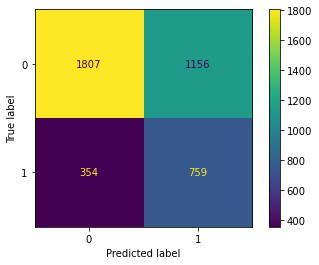

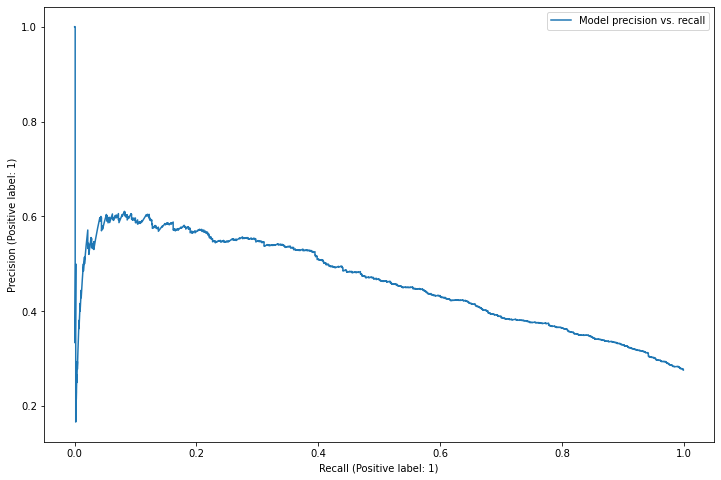

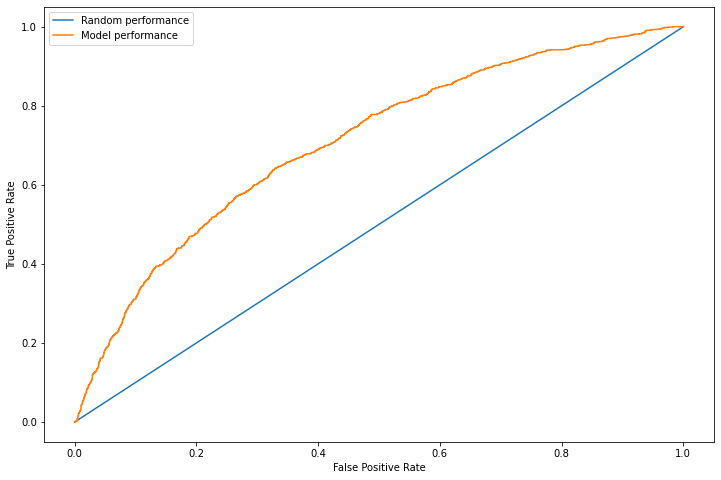

In [10]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [11]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-RMSprop' + date_time
print(result_file_basename)

replication-07-Neural-Network-using-RMSprop20210603-0849


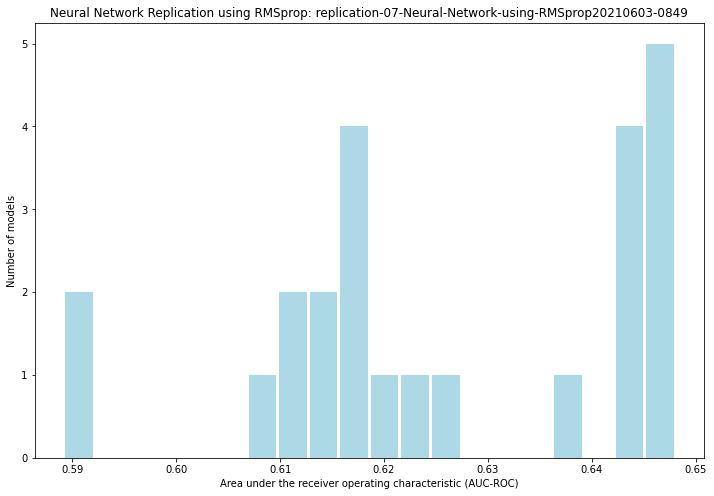

In [12]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using RMSprop: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)

In [13]:
# save the search results dataframe to a file so can retrieve for later data analysis or
# to combine with other grid search results for summaries
result_dir = '../NeuralNetworkResults'
result_file_name = result_file_basename + '.pkl'
result_file_path = os.path.join(result_dir, result_file_name)
df_result.to_pickle(result_file_path)